# FedEP Experiment in Centralized Federated Learning (CFL) Scenario

In [1]:
import os
import sys
import copy
import numpy as np
import matplotlib.pyplot as plt

import torch.multiprocessing
from torch.utils.data import Dataset
from torchvision import transforms
from torchvision.datasets import MNIST

import lightning as pl
from torchmetrics.classification import MulticlassAccuracy, MulticlassRecall, MulticlassPrecision, MulticlassF1Score, MulticlassConfusionMatrix
from torchmetrics import MetricCollection

import torch.nn as nn
import torch.utils.data as data
from torch.utils.data import DataLoader
import torchvision as tv

import pickle


In [2]:
import torch
if torch.backends.mps.is_available():
    mps_device = torch.device("mps")
    x = torch.ones(1, device=mps_device)
    print (x)
else:
    print ("MPS device not found.")

tensor([1.], device='mps:0')


In [3]:
import time

def timing_decorator(func):
    def wrapper(*args, **kwargs):
        start_time = time.time()
        result = func(*args, **kwargs)
        end_time = time.time()
        elapsed_time = end_time - start_time
        print(f"{func.__name__} took {elapsed_time:.4f} seconds")
        return result
    return wrapper

## 1. Preparation

### 1.1 Import MNIST

In [4]:
mnist_train = MNIST(
    f"{sys.path[0]}/data", train=True, download=True, transform=transforms.ToTensor()
)

sorted_indexes = mnist_train.targets.sort()[1]

mnist_train.targets = (
    mnist_train.targets[sorted_indexes]
)
mnist_train.data = mnist_train.data[
    sorted_indexes
]

mnist_val = MNIST(
    f"{sys.path[0]}/data", train=False, download=True, transform=transforms.ToTensor()
)


In [5]:
starters = []

for i in set(mnist_train.targets.tolist()):
    starters.append(mnist_train.targets.tolist().index(i))
starters.append(59999)

print(starters)

[0, 5923, 12665, 18623, 24754, 30596, 36017, 41935, 48200, 54051, 59999]


In [6]:
Y_set = set(mnist_train.targets.tolist())
Y_set

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

## 2. Distribute data (mimic Non-IID scenario)

### Scenario 1: Non-IID (mild situation)

d_global [3100, 2600, 1400, 1100, 2400, 1800, 1300, 1100, 1300, 1900]


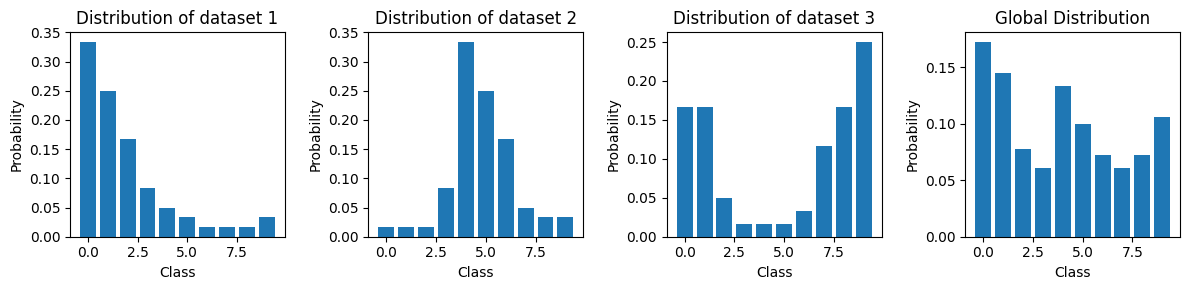

In [7]:
import matplotlib.pyplot as plt

# Number of data samples of each class in each node
d_1 = [2000, 1500, 1000, 500, 300, 200, 100, 100, 100, 200]
d_2 = [100, 100, 100, 500, 2000, 1500, 1000, 300, 200, 200]
d_3 = [1000, 1000, 300, 100, 100, 100, 200, 700, 1000, 1500]
d_global = [ d_1[i] + d_2[i] + d_3[i] for i in range(10)]
print("d_global", d_global)

# Probability of each class in each node
p_1 = [v / sum(d_1) for v in d_1]
p_2 = [v / sum(d_2) for v in d_2]
p_3 = [v / sum(d_3) for v in d_3]
p_global = [v / sum(d_global) for v in d_global]

# Define the data
data = [p_1, p_2, p_3, p_global]

# Plot the histograms
fig, ax = plt.subplots(1, 4, figsize=(12, 3))

for i in range(4):
    ax[i].bar(list(range(10)), data[i])
    ax[i].set_xlabel('Class')
    ax[i].set_ylabel('Probability')
    if i == 3:
        ax[i].set_title(f'Global Distribution')
    else:
        ax[i].set_title(f'Distribution of dataset {i+1}')

plt.tight_layout()
plt.show() 

In [9]:
np.random.seed(2023)

def distrbuted_data(starters, d_1, d_2, d_3):
    train_set1 = copy.deepcopy(mnist_train)
    train_set2 = copy.deepcopy(mnist_train)
    train_set3 = copy.deepcopy(mnist_train)
    test_set = mnist_val

    index_1 = []
    index_2 = []
    index_3 = []
    for i in range(10):
        population = range(starters[i], starters[i+1]-1)
        index_1_i = np.random.choice(population, size=d_1[i], replace=False)

        # Remove the selected index in index_1_i from the population
        population = np.setdiff1d(population, index_1_i)
        index_2_i = np.random.choice(population, size=d_2[i], replace=False)

        # Remove the selected index in index_2_i from the population
        population = np.setdiff1d(population, index_2_i)
        index_3_i = np.random.choice(population, size=d_3[i], replace=False)

        index_1.extend(index_1_i)
        index_2.extend(index_2_i)
        index_3.extend(index_3_i)

    train_set1.data = train_set1.data[index_1]
    train_set1.targets = train_set1.targets[index_1]

    train_set2.data = train_set2.data[index_2]
    train_set2.targets = train_set2.targets[index_2]

    train_set3.data = train_set3.data[index_3]
    train_set3.targets = train_set3.targets[index_3]

    return train_set1, train_set2, train_set3, test_set


    

train_set1, train_set2, train_set3, test_set = distrbuted_data(starters, d_1, d_2, d_3)

### Scenario 2: Non-IID (normal situation)

d_global [2500, 2000, 1500, 2000, 2000, 1500, 1000, 1500, 1500, 2500]


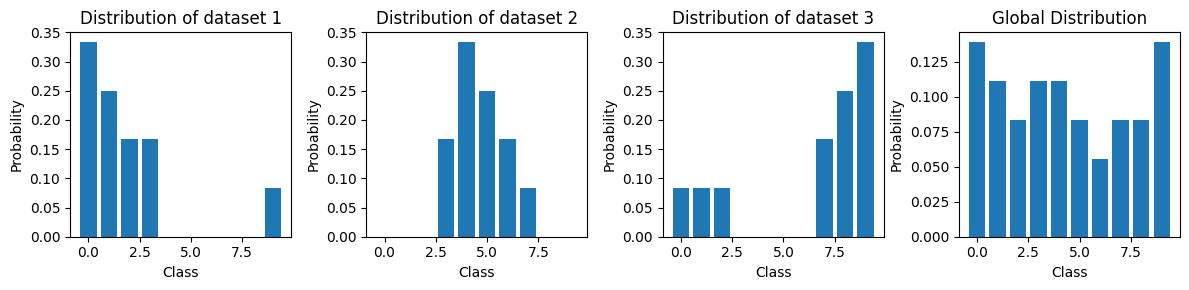

In [9]:
# number of sample in each class
d_1 = [2000, 1500, 1000, 1000, 0, 0, 0, 0, 0, 500]
d_2 = [0, 0, 0, 1000, 2000, 1500, 1000, 500, 0, 0]
d_3 = [500, 500, 500, 0, 0, 0, 0, 1000, 1500, 2000]
d_global = [ d_1[i]+d_2[i]+d_3[i] for i in range(10)]
print("d_global", d_global)

p_1 = [v / sum(d_1) for v in d_1]
p_2 = [v / sum(d_2) for v in d_2]
p_3 = [v / sum(d_3) for v in d_3]
p_global = [v / sum(d_global) for v in d_global]

# Define the class labels
class_labels = list(range(10))

# Define the data
data = [p_1, p_2, p_3, p_global]

# Plot the histograms
fig, ax = plt.subplots(1, 4, figsize=(12, 3))

for i in range(4):
    ax[i].bar(class_labels, data[i])
    ax[i].set_xlabel('Class')
    ax[i].set_ylabel('Probability')
    if i == 3:
        ax[i].set_title(f'Global Distribution')
    else:
        ax[i].set_title(f'Distribution of dataset {i+1}')

plt.tight_layout()
plt.show()


In [10]:
np.random.seed(2023)

train_set1, train_set2, train_set3, test_set = distrbuted_data(starters, d_1, d_2, d_3)

## The MLP model at each client nodes

In [20]:
# first define the model at client nodes

class MNISTModelMLP(pl.LightningModule):
    """
    LightningModule for MNIST.
    """

    def process_metrics(self, phase, y_pred, y, loss=None):
        """
        Calculate and log metrics for the given phase.
        Args:
            phase (str): One of 'Train', 'Validation', or 'Test'
            y_pred (torch.Tensor): Model predictions
            y (torch.Tensor): Ground truth labels
            loss (torch.Tensor, optional): Loss value
        """
        if loss is not None:
            self.log(f"{phase}/Loss", loss, prog_bar=True, logger=True)

        y_pred_classes = torch.argmax(y_pred, dim=1)
        if phase == "Train":
            output = self.train_metrics(y_pred_classes, y)
        elif phase == "Validation":
            output = self.val_metrics(y_pred_classes, y)
        elif phase == "Test":
            output = self.test_metrics(y_pred_classes, y)
        else:
            raise NotImplementedError
        # print(f"y_pred shape: {y_pred.shape}, y_pred_classes shape: {y_pred_classes.shape}, y shape: {y.shape}")  # Debug print
        output = {f"{phase}/{key.replace('Multiclass', '').split('/')[-1]}": value for key, value in output.items()}
        self.log_dict(output, prog_bar=True, logger=True)

        if self.cm is not None:
            self.cm.update(y_pred_classes, y)

    def log_metrics_by_epoch(self, phase, print_cm=False, plot_cm=False):
        """
        Log all metrics at the end of an epoch for the given phase.
        Args:
            phase (str): One of 'Train', 'Validation', or 'Test'
            :param phase:
            :param plot_cm:
        """
        print(f"Epoch end: {phase}, epoch number: {self.epoch_global_number[phase]}")
        if phase == "Train":
            output = self.train_metrics.compute()
            self.train_metrics.reset()
        elif phase == "Validation":
            output = self.val_metrics.compute()
            self.val_metrics.reset()
        elif phase == "Test":
            output = self.test_metrics.compute()
            self.test_metrics.reset()
        else:
            raise NotImplementedError

        output = {f"{phase}Epoch/{key.replace('Multiclass', '').split('/')[-1]}": value for key, value in output.items()}

        self.log_dict(output, prog_bar=True, logger=True)

        if self.cm is not None:
            cm = self.cm.compute().cpu()
            # print(f"{phase}Epoch/CM\n", cm) if print_cm else None
            if plot_cm:
                import seaborn as sns
                import matplotlib.pyplot as plt
                plt.figure(figsize=(10, 7))
                ax = sns.heatmap(cm.numpy(), annot=True, fmt="d", cmap="Blues")
                ax.set_xlabel("Predicted labels")
                ax.set_ylabel("True labels")
                ax.set_title("Confusion Matrix")
                ax.set_xticks(range(10))
                ax.set_yticks(range(10))
                ax.xaxis.set_ticklabels([i for i in range(10)])
                ax.yaxis.set_ticklabels([i for i in range(10)])
                # self.logger.experiment.add_figure(f"{phase}Epoch/CM", ax.get_figure(), global_step=self.epoch_global_number[phase])
                plt.close()

        # Reset metrics

        self.epoch_global_number[phase] += 1

    def __init__(
            self,
            in_channels=1,
            out_channels=10,
            learning_rate=1e-3,
            metrics=None,
            confusion_matrix=None,
            seed=None
    ):
        super().__init__()
        if metrics is None:
            metrics = MetricCollection([
                MulticlassAccuracy(num_classes=out_channels),
                MulticlassPrecision(num_classes=out_channels),
                MulticlassRecall(num_classes=out_channels),
                MulticlassF1Score(num_classes=out_channels)
            ])

        # Define metrics
        self.train_metrics = metrics.clone(prefix="Train/")
        # self.val_metrics = metrics.clone(prefix="Validation/")
        self.test_metrics = metrics.clone(prefix="Test/")

        if confusion_matrix is None:
            self.cm = MulticlassConfusionMatrix(num_classes=out_channels)

        # Set seed for reproducibility initialization
        if seed is not None:
            torch.manual_seed(seed)
            torch.cuda.manual_seed_all(seed)

        self.example_input_array = torch.zeros(1, 1, 28, 28)
        self.learning_rate = learning_rate

        self.criterion = torch.nn.CrossEntropyLoss()

        self.l1 = torch.nn.Linear(28 * 28, 256)
        self.l2 = torch.nn.Linear(256, 128)
        self.l3 = torch.nn.Linear(128, out_channels)
        self.epoch_global_number = {"Train": 0,  "Test": 0}
        # self.epoch_global_number = {"Train": 0, "Validation": 0, "Test": 0}

    def forward(self, x):
        """ """
        batch_size, channels, width, height = x.size()

        # (b, 1, 28, 28) -> (b, 1*28*28)
        x = x.view(batch_size, -1)
        x = self.l1(x)
        x = torch.relu(x)
        x = self.l2(x)
        x = torch.relu(x)
        x = self.l3(x)
        x = torch.log_softmax(x, dim=1)
        return x

    def configure_optimizers(self):
        """ """
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def step(self, batch, phase):
        images, labels = batch
        images = images.to(self.device)
        labels = labels.to(self.device)
        y_pred = self.forward(images)
        loss = self.criterion(y_pred, labels)

        # Get metrics for each batch and log them
        self.log(f"{phase}/Loss", loss, prog_bar=True)
        self.process_metrics(phase, y_pred, labels, loss)

        return loss

    def training_step(self, batch, batch_id):
        """
        Training step for the model.
        Args:
            batch:
            batch_id:

        Returns:
        """
        return self.step(batch, "Train")

    def on_train_epoch_end(self):
        self.log_metrics_by_epoch("Train", print_cm=True, plot_cm=True)

    # def validation_step(self, batch, batch_idx):
    #     """
    #     Validation step for the model.
    #     Args:
    #         batch:
    #         batch_idx:

    #     Returns:
    #     """
    #     return self.step(batch, "Validation")

    # def on_validation_epoch_end(self):
    #     self.log_metrics_by_epoch("Validation", print_cm=True, plot_cm=True)

    def test_step(self, batch, batch_idx):
        """
        Test step for the model.
        Args:
            batch:
            batch_idx:

        Returns:
        """
        return self.step(batch, "Test")

    def on_test_epoch_end(self):
        self.log_metrics_by_epoch("Test", print_cm=True, plot_cm=True)


## FedAvg in Centralized Federated Learning (CFL) Scenario

In [21]:
class Server():
    def __init__(self, model, test_set, batch_size=64):
        self.model = model
        self.test_set = test_set
        self.clients = []
        self.clients_data_size = []
        self.q_k = []
        self.batch_size = batch_size
        self.trainer = pl.Trainer(enable_checkpointing=True)
        self.eval_results = []  # List to store evaluation results

    def add_client(self, client):
        self.clients.append(client)
        self.clients_data_size.append(len(client.train_set))
        self.q_k = [s/sum(self.clients_data_size) for s in self.clients_data_size]

    def aggregate(self):
        # Get the state_dict of each client's model:
        params_list = [client.model.state_dict() for client in self.clients]

        # Initialize params_global with zeros using the first client's parameters as a template
        params_global = {key: np.zeros_like(value) for key, value in params_list[0].items()}

        for i,params in enumerate(params_list):
            # Convert OrderedDict to a numpy array-like object for element-wise multiplication
            params_array = {key: np.array(value) for key, value in params.items()}
            for key in params_global.keys():
                # Accumulate weighted parameters
                params_global[key] += self.q_k[i] * params_array[key]
        # Convert the aggregated parameters back to OrderedDict and load into the model
        aggregated_state_dict = {key: torch.tensor(value) for key, value in params_global.items()}
        self.model.load_state_dict(aggregated_state_dict)
        
    def broadcast(self,params):
        for client in self.clients:
            client.receive(params)

    @timing_decorator
    def train(self, rounds=5):
        for r in range(rounds):
            self.broadcast(self.model.state_dict())
            for client in self.clients:
                client.train()
            self.aggregate()
            self.evaluate()
            print(f"Round {r+1} finished")
        
    def evaluate(self):
        print("Evaluating at Server")
        result = self.trainer.test(self.model, DataLoader(self.test_set, self.batch_size), verbose=True)
        self.eval_results.append(result)
        print("Evaluating at Server finished")
        

class Client():
    def __init__(self, node_name, model, train_set, test_set, Epochs=3, batch_size=64):
        self.node_name = node_name
        self.model = model
        self.train_set = train_set
        self.test_set = test_set
        self.batch_size = batch_size
        self.Epochs = Epochs
        self.eval_results = []  # List to store evaluation results after training

    def train(self):
        print(f"Training at {self.node_name}:")
        trainer = pl.Trainer(max_epochs=self.Epochs, enable_checkpointing=True)
        trainer.fit(self.model, DataLoader(self.train_set, self.batch_size, shuffle=True, num_workers=10))
        print(f"Training at {self.node_name} finished")
        self.evaluate()

    def evaluate(self):
        print(f"Evaluating at {self.node_name}")
        trainer = pl.Trainer(max_epochs=self.Epochs, enable_checkpointing=True)
        result = trainer.test(self.model, DataLoader(self.test_set, self.batch_size,num_workers=10), verbose=True)
        self.eval_results.append(result)
        print(f"Evaluating at {self.node_name} finished")
        
    def receive(self, params):
        self.model.load_state_dict(params)

In [12]:
# Scenario 1: Non-IID (mild)

model_global = MNISTModelMLP()
model1 = MNISTModelMLP()
model2 = MNISTModelMLP()
model3 = MNISTModelMLP()

a = Server(model_global, test_set)
b = Client("node_b", model1, train_set1, test_set, Epochs=3)
c = Client("node_c", model2, train_set2, test_set, Epochs=3)
d = Client("node_d", model3, train_set3, test_set, Epochs=3)
a.add_client(b)
a.add_client(c)
a.add_client(d)

a.train(rounds=8)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] |

Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:08<00:00, 10.47it/s, v_num=596, Train/Loss=0.163, Train/Accuracy=0.952, Train/Precision=0.875, Train/Recall=0.952, Train/F1Score=0.890, TrainEpoch/Accuracy=0.782, TrainEpoch/Precision=0.833, TrainEpoch/Recall=0.782, TrainEpoch/F1Score=0.802] Epoch end: Train, epoch number: 2


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.39it/s, v_num=596, Train/Loss=0.163, Train/Accuracy=0.952, Train/Precision=0.875, Train/Recall=0.952, Train/F1Score=0.890, TrainEpoch/Accuracy=0.782, TrainEpoch/Precision=0.833, TrainEpoch/Recall=0.782, TrainEpoch/F1Score=0.802]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.13it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8553798794746399     │
│       Test/F1Score        │    0.8446422815322876     │
│         Test/Loss         │    0.4650937616825104     │
│      Test/Precision       │    0.8752706050872803     │
│        Test/Recall        │    0.8553798794746399     │
│    TestEpoch/Accuracy     │    0.8582302927970886     │
│     TestEpoch/F1Score     │    0.8574132919311523     │
│    TestEpoch/Precision    │    0.8724070191383362     │
│     TestEpoch/Recall      │    0.8582302927970886     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.33it/s, v_num=598, Train/Loss=0.0675, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.796, TrainEpoch/Precision=0.865, TrainEpoch/Recall=0.796, TrainEpoch/F1Score=0.825]Epoch end: Train, epoch number: 2


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.18it/s, v_num=598, Train/Loss=0.0675, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.796, TrainEpoch/Precision=0.865, TrainEpoch/Recall=0.796, TrainEpoch/F1Score=0.825]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.10it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8809360265731812     │
│       Test/F1Score        │     0.869552731513977     │
│         Test/Loss         │    0.40133482217788696    │
│      Test/Precision       │    0.8916234374046326     │
│        Test/Recall        │    0.8809360265731812     │
│    TestEpoch/Accuracy     │    0.8815820217132568     │
│     TestEpoch/F1Score     │    0.8791970610618591     │
│    TestEpoch/Precision    │    0.8883806467056274     │
│     TestEpoch/Recall      │    0.8815820217132568     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00,  9.97it/s, v_num=600, Train/Loss=0.368, Train/Accuracy=0.672, Train/Precision=0.647, Train/Recall=0.672, Train/F1Score=0.657, TrainEpoch/Accuracy=0.790, TrainEpoch/Precision=0.889, TrainEpoch/Recall=0.790, TrainEpoch/F1Score=0.821] Epoch end: Train, epoch number: 2


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00,  9.89it/s, v_num=600, Train/Loss=0.368, Train/Accuracy=0.672, Train/Precision=0.647, Train/Recall=0.672, Train/F1Score=0.657, TrainEpoch/Accuracy=0.790, TrainEpoch/Precision=0.889, TrainEpoch/Recall=0.790, TrainEpoch/F1Score=0.821]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.27it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8505609631538391     │
│       Test/F1Score        │    0.8360041975975037     │
│         Test/Loss         │    0.44298338890075684    │
│      Test/Precision       │    0.8753814697265625     │
│        Test/Recall        │    0.8505609631538391     │
│    TestEpoch/Accuracy     │    0.8516923189163208     │
│     TestEpoch/F1Score     │    0.8504051566123962     │
│    TestEpoch/Precision    │    0.8788384795188904     │
│     TestEpoch/Recall      │    0.8516923189163208     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.01it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8735451102256775     │
│       Test/F1Score        │    0.8631241321563721     │
│         Test/Loss         │    0.44610264897346497    │
│      Test/Precision       │     0.885537326335907     │
│        Test/Recall        │    0.8735451102256775     │
│    TestEpoch/Accuracy     │    0.8756936192512512     │
│     TestEpoch/F1Score     │    0.8749125003814697     │
│    TestEpoch/Precision    │    0.8840798139572144     │
│     TestEpoch/Recall      │    0.8756936192512512     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 1 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00,  9.90it/s, v_num=603, Train/Loss=0.0472, Train/Accuracy=0.889, Train/Precision=0.833, Train/Recall=0.889, Train/F1Score=0.852, TrainEpoch/Accuracy=0.913, TrainEpoch/Precision=0.931, TrainEpoch/Recall=0.913, TrainEpoch/F1Score=0.921]Epoch end: Train, epoch number: 5


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00,  9.69it/s, v_num=603, Train/Loss=0.0472, Train/Accuracy=0.889, Train/Precision=0.833, Train/Recall=0.889, Train/F1Score=0.852, TrainEpoch/Accuracy=0.913, TrainEpoch/Precision=0.931, TrainEpoch/Recall=0.913, TrainEpoch/F1Score=0.921]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.91it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8885840773582458     │
│       Test/F1Score        │    0.8788086771965027     │
│         Test/Loss         │    0.35344409942626953    │
│      Test/Precision       │    0.9019973874092102     │
│        Test/Recall        │    0.8885840773582458     │
│    TestEpoch/Accuracy     │    0.8893523216247559     │
│     TestEpoch/F1Score     │    0.8888141512870789     │
│    TestEpoch/Precision    │    0.9000594615936279     │
│     TestEpoch/Recall      │    0.8893523216247559     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.06it/s, v_num=605, Train/Loss=0.116, Train/Accuracy=0.875, Train/Precision=0.869, Train/Recall=0.875, Train/F1Score=0.872, TrainEpoch/Accuracy=0.916, TrainEpoch/Precision=0.924, TrainEpoch/Recall=0.916, TrainEpoch/F1Score=0.919] Epoch end: Train, epoch number: 5


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00,  9.98it/s, v_num=605, Train/Loss=0.116, Train/Accuracy=0.875, Train/Precision=0.869, Train/Recall=0.875, Train/F1Score=0.872, TrainEpoch/Accuracy=0.916, TrainEpoch/Precision=0.924, TrainEpoch/Recall=0.916, TrainEpoch/F1Score=0.919]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.03it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.913483202457428     │
│       Test/F1Score        │    0.9048967957496643     │
│         Test/Loss         │    0.2864384055137634     │
│      Test/Precision       │    0.9207817316055298     │
│        Test/Recall        │     0.913483202457428     │
│    TestEpoch/Accuracy     │    0.9131770730018616     │
│     TestEpoch/F1Score     │    0.9115157127380371     │
│    TestEpoch/Precision    │    0.9168946743011475     │
│     TestEpoch/Recall      │    0.9131770730018616     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.43it/s, v_num=607, Train/Loss=0.0604, Train/Accuracy=0.889, Train/Precision=0.833, Train/Recall=0.889, Train/F1Score=0.852, TrainEpoch/Accuracy=0.912, TrainEpoch/Precision=0.934, TrainEpoch/Recall=0.912, TrainEpoch/F1Score=0.922]Epoch end: Train, epoch number: 5


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.35it/s, v_num=607, Train/Loss=0.0604, Train/Accuracy=0.889, Train/Precision=0.833, Train/Recall=0.889, Train/F1Score=0.852, TrainEpoch/Accuracy=0.912, TrainEpoch/Precision=0.934, TrainEpoch/Recall=0.912, TrainEpoch/F1Score=0.922]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.07it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.892888069152832     │
│       Test/F1Score        │    0.8813378214836121     │
│         Test/Loss         │    0.35438841581344604    │
│      Test/Precision       │    0.9053623080253601     │
│        Test/Recall        │     0.892888069152832     │
│    TestEpoch/Accuracy     │    0.8929888606071472     │
│     TestEpoch/F1Score     │    0.8922971487045288     │
│    TestEpoch/Precision    │     0.907390832901001     │
│     TestEpoch/Recall      │    0.8929888606071472     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.84it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9327574372291565     │
│       Test/F1Score        │    0.9272577166557312     │
│         Test/Loss         │    0.21292738616466522    │
│      Test/Precision       │    0.9360445141792297     │
│        Test/Recall        │    0.9327574372291565     │
│    TestEpoch/Accuracy     │    0.9344305992126465     │
│     TestEpoch/F1Score     │    0.9344980716705322     │
│    TestEpoch/Precision    │    0.9354746341705322     │
│     TestEpoch/Recall      │    0.9344305992126465     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 2 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.29it/s, v_num=609, Train/Loss=0.038, Train/Accuracy=0.969, Train/Precision=0.938, Train/Recall=0.969, Train/F1Score=0.940, TrainEpoch/Accuracy=0.960, TrainEpoch/Precision=0.962, TrainEpoch/Recall=0.960, TrainEpoch/F1Score=0.961]  Epoch end: Train, epoch number: 8


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.22it/s, v_num=609, Train/Loss=0.038, Train/Accuracy=0.969, Train/Precision=0.938, Train/Recall=0.969, Train/F1Score=0.940, TrainEpoch/Accuracy=0.960, TrainEpoch/Precision=0.962, TrainEpoch/Recall=0.960, TrainEpoch/F1Score=0.961]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.28it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9109850525856018     │
│       Test/F1Score        │    0.9024538993835449     │
│         Test/Loss         │    0.28442564606666565    │
│      Test/Precision       │    0.9180640578269958     │
│        Test/Recall        │    0.9109850525856018     │
│    TestEpoch/Accuracy     │    0.9136924743652344     │
│     TestEpoch/F1Score     │    0.9117641448974609     │
│    TestEpoch/Precision    │    0.9184830188751221     │
│     TestEpoch/Recall      │    0.9136924743652344     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.12it/s, v_num=611, Train/Loss=0.0146, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.948, TrainEpoch/Precision=0.957, TrainEpoch/Recall=0.948, TrainEpoch/F1Score=0.952] Epoch end: Train, epoch number: 8


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00,  9.97it/s, v_num=611, Train/Loss=0.0146, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.948, TrainEpoch/Precision=0.957, TrainEpoch/Recall=0.948, TrainEpoch/F1Score=0.952]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.08it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9336220622062683     │
│       Test/F1Score        │    0.9280292987823486     │
│         Test/Loss         │    0.21204902231693268    │
│      Test/Precision       │    0.9379541873931885     │
│        Test/Recall        │    0.9336220622062683     │
│    TestEpoch/Accuracy     │    0.9350903034210205     │
│     TestEpoch/F1Score     │     0.934354305267334     │
│    TestEpoch/Precision    │    0.9365023374557495     │
│     TestEpoch/Recall      │    0.9350903034210205     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.44it/s, v_num=613, Train/Loss=0.178, Train/Accuracy=0.901, Train/Precision=0.896, Train/Recall=0.901, Train/F1Score=0.874, TrainEpoch/Accuracy=0.956, TrainEpoch/Precision=0.965, TrainEpoch/Recall=0.956, TrainEpoch/F1Score=0.960]  Epoch end: Train, epoch number: 8


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.37it/s, v_num=613, Train/Loss=0.178, Train/Accuracy=0.901, Train/Precision=0.896, Train/Recall=0.901, Train/F1Score=0.874, TrainEpoch/Accuracy=0.956, TrainEpoch/Precision=0.965, TrainEpoch/Recall=0.956, TrainEpoch/F1Score=0.960]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.16it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9119978547096252     │
│       Test/F1Score        │    0.9044086933135986     │
│         Test/Loss         │    0.30328401923179626    │
│      Test/Precision       │    0.9217625856399536     │
│        Test/Recall        │    0.9119978547096252     │
│    TestEpoch/Accuracy     │    0.9129113554954529     │
│     TestEpoch/F1Score     │     0.912877082824707     │
│    TestEpoch/Precision    │    0.9210430383682251     │
│     TestEpoch/Recall      │    0.9129113554954529     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.01it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9463146328926086     │
│       Test/F1Score        │    0.9425018429756165     │
│         Test/Loss         │    0.17204783856868744    │
│      Test/Precision       │    0.9486421942710876     │
│        Test/Recall        │    0.9463146328926086     │
│    TestEpoch/Accuracy     │    0.9476901292800903     │
│     TestEpoch/F1Score     │    0.9477099180221558     │
│    TestEpoch/Precision    │    0.9481499195098877     │
│     TestEpoch/Recall      │    0.9476901292800903     │
└───────────────────────────┴───────────────────────────┘

Evaluating at Server finished

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param


Round 3 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:08<00:00, 10.55it/s, v_num=615, Train/Loss=0.00841, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.970, TrainEpoch/Precision=0.972, TrainEpoch/Recall=0.970, TrainEpoch/F1Score=0.971]Epoch end: Train, epoch number: 11


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.32it/s, v_num=615, Train/Loss=0.00841, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.970, TrainEpoch/Precision=0.972, TrainEpoch/Recall=0.970, TrainEpoch/F1Score=0.971]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.15it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.912311315536499     │
│       Test/F1Score        │     0.903494119644165     │
│         Test/Loss         │    0.29056763648986816    │
│      Test/Precision       │    0.9198641777038574     │
│        Test/Recall        │     0.912311315536499     │
│    TestEpoch/Accuracy     │    0.9151608943939209     │
│     TestEpoch/F1Score     │    0.9135258197784424     │
│    TestEpoch/Precision    │    0.9209027290344238     │
│     TestEpoch/Recall      │    0.9151608943939209     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.39it/s, v_num=617, Train/Loss=0.0552, Train/Accuracy=0.982, Train/Precision=0.986, Train/Recall=0.982, Train/F1Score=0.983, TrainEpoch/Accuracy=0.968, TrainEpoch/Precision=0.976, TrainEpoch/Recall=0.968, TrainEpoch/F1Score=0.972] Epoch end: Train, epoch number: 11


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.32it/s, v_num=617, Train/Loss=0.0552, Train/Accuracy=0.982, Train/Precision=0.986, Train/Recall=0.982, Train/F1Score=0.983, TrainEpoch/Accuracy=0.968, TrainEpoch/Precision=0.976, TrainEpoch/Recall=0.968, TrainEpoch/F1Score=0.972]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.17it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9364305734634399     │
│       Test/F1Score        │    0.9309473633766174     │
│         Test/Loss         │    0.20189730823040009    │
│      Test/Precision       │    0.9390689730644226     │
│        Test/Recall        │    0.9364305734634399     │
│    TestEpoch/Accuracy     │    0.9379162788391113     │
│     TestEpoch/F1Score     │    0.9370746612548828     │
│    TestEpoch/Precision    │    0.9380660057067871     │
│     TestEpoch/Recall      │    0.9379162788391113     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.22it/s, v_num=619, Train/Loss=0.020, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.975, TrainEpoch/Precision=0.977, TrainEpoch/Recall=0.975, TrainEpoch/F1Score=0.976]  Epoch end: Train, epoch number: 11


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.14it/s, v_num=619, Train/Loss=0.020, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.975, TrainEpoch/Precision=0.977, TrainEpoch/Recall=0.975, TrainEpoch/F1Score=0.976]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.03it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9129236340522766     │
│       Test/F1Score        │    0.9074004888534546     │
│         Test/Loss         │    0.2947615087032318     │
│      Test/Precision       │    0.9269416928291321     │
│        Test/Recall        │    0.9129236340522766     │
│    TestEpoch/Accuracy     │    0.9137105345726013     │
│     TestEpoch/F1Score     │    0.9154378771781921     │
│    TestEpoch/Precision    │     0.926106333732605     │
│     TestEpoch/Recall      │    0.9137105345726013     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.88it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9524356722831726     │
│       Test/F1Score        │    0.9484008550643921     │
│         Test/Loss         │    0.15479600429534912    │
│      Test/Precision       │    0.9531238079071045     │
│        Test/Recall        │    0.9524356722831726     │
│    TestEpoch/Accuracy     │    0.9533540606498718     │
│     TestEpoch/F1Score     │    0.9533758163452148     │
│    TestEpoch/Precision    │    0.9537259340286255     │
│     TestEpoch/Recall      │    0.9533540606498718     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 4 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.17it/s, v_num=621, Train/Loss=0.00216, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.989, TrainEpoch/Precision=0.992, TrainEpoch/Recall=0.989, TrainEpoch/F1Score=0.990] Epoch end: Train, epoch number: 14


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.09it/s, v_num=621, Train/Loss=0.00216, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.989, TrainEpoch/Precision=0.992, TrainEpoch/Recall=0.989, TrainEpoch/F1Score=0.990]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.87it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9286450147628784     │
│       Test/F1Score        │    0.9235184788703918     │
│         Test/Loss         │    0.26478949189186096    │
│      Test/Precision       │    0.9360460042953491     │
│        Test/Recall        │    0.9286450147628784     │
│    TestEpoch/Accuracy     │    0.9301711320877075     │
│     TestEpoch/F1Score     │     0.930654764175415     │
│    TestEpoch/Precision    │    0.9348266124725342     │
│     TestEpoch/Recall      │    0.9301711320877075     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.23it/s, v_num=623, Train/Loss=0.109, Train/Accuracy=0.966, Train/Precision=0.969, Train/Recall=0.966, Train/F1Score=0.965, TrainEpoch/Accuracy=0.981, TrainEpoch/Precision=0.986, TrainEpoch/Recall=0.981, TrainEpoch/F1Score=0.984]  Epoch end: Train, epoch number: 14


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00,  9.98it/s, v_num=623, Train/Loss=0.109, Train/Accuracy=0.966, Train/Precision=0.969, Train/Recall=0.966, Train/F1Score=0.965, TrainEpoch/Accuracy=0.981, TrainEpoch/Precision=0.986, TrainEpoch/Recall=0.981, TrainEpoch/F1Score=0.984]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.07it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9353852272033691     │
│       Test/F1Score        │     0.930217981338501     │
│         Test/Loss         │    0.22350281476974487    │
│      Test/Precision       │    0.9403839707374573     │
│        Test/Recall        │    0.9353852272033691     │
│    TestEpoch/Accuracy     │    0.9365234971046448     │
│     TestEpoch/F1Score     │    0.9364250898361206     │
│    TestEpoch/Precision    │    0.9400967955589294     │
│     TestEpoch/Recall      │    0.9365234971046448     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.39it/s, v_num=625, Train/Loss=0.0293, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.986, TrainEpoch/Precision=0.989, TrainEpoch/Recall=0.986, TrainEpoch/F1Score=0.987] Epoch end: Train, epoch number: 14


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, v_num=625, Train/Loss=0.0293, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.986, TrainEpoch/Precision=0.989, TrainEpoch/Recall=0.986, TrainEpoch/F1Score=0.987]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.02it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.926770806312561     │
│       Test/F1Score        │    0.9222778081893921     │
│         Test/Loss         │    0.2704899311065674     │
│      Test/Precision       │    0.9371581077575684     │
│        Test/Recall        │     0.926770806312561     │
│    TestEpoch/Accuracy     │    0.9274195432662964     │
│     TestEpoch/F1Score     │    0.9285272359848022     │
│    TestEpoch/Precision    │    0.9354774951934814     │
│     TestEpoch/Recall      │    0.9274195432662964     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.91it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9526015520095825     │
│       Test/F1Score        │    0.9489167928695679     │
│         Test/Loss         │     0.156420037150383     │
│      Test/Precision       │    0.9541394710540771     │
│        Test/Recall        │    0.9526015520095825     │
│    TestEpoch/Accuracy     │    0.9551390409469604     │
│     TestEpoch/F1Score     │    0.9553555250167847     │
│    TestEpoch/Precision    │     0.956122636795044     │
│     TestEpoch/Recall      │    0.9551390409469604     │
└───────────────────────────┴───────────────────────────┘

Evaluating at Server finished
Round 5 finished


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.42it/s, v_num=627, Train/Loss=0.00986, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.987, TrainEpoch/Precision=0.991, TrainEpoch/Recall=0.987, TrainEpoch/F1Score=0.989] Epoch end: Train, epoch number: 17


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.34it/s, v_num=627, Train/Loss=0.00986, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.987, TrainEpoch/Precision=0.991, TrainEpoch/Recall=0.987, TrainEpoch/F1Score=0.989]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.11it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9327297806739807     │
│       Test/F1Score        │    0.9277095794677734     │
│         Test/Loss         │    0.24573901295661926    │
│      Test/Precision       │     0.940100908279419     │
│        Test/Recall        │    0.9327297806739807     │
│    TestEpoch/Accuracy     │    0.9344714879989624     │
│     TestEpoch/F1Score     │    0.9347808361053467     │
│    TestEpoch/Precision    │    0.9391855001449585     │
│     TestEpoch/Recall      │    0.9344714879989624     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.34it/s, v_num=629, Train/Loss=0.00282, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.992, TrainEpoch/Precision=0.992, TrainEpoch/Recall=0.992, TrainEpoch/F1Score=0.992]Epoch end: Train, epoch number: 17


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.23it/s, v_num=629, Train/Loss=0.00282, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.992, TrainEpoch/Precision=0.992, TrainEpoch/Recall=0.992, TrainEpoch/F1Score=0.992]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.01it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9519314169883728     │
│       Test/F1Score        │    0.9468644261360168     │
│         Test/Loss         │    0.17576967179775238    │
│      Test/Precision       │    0.9524075984954834     │
│        Test/Recall        │    0.9519314169883728     │
│    TestEpoch/Accuracy     │    0.9522727131843567     │
│     TestEpoch/F1Score     │    0.9516127109527588     │
│    TestEpoch/Precision    │    0.9519254565238953     │
│     TestEpoch/Recall      │    0.9522727131843567     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.36it/s, v_num=631, Train/Loss=0.011, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.993, TrainEpoch/Precision=0.998, TrainEpoch/Recall=0.993, TrainEpoch/F1Score=0.995]  Epoch end: Train, epoch number: 17


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.29it/s, v_num=631, Train/Loss=0.011, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.993, TrainEpoch/Precision=0.998, TrainEpoch/Recall=0.993, TrainEpoch/F1Score=0.995]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:11<00:00, 13.90it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9449504017829895     │
│       Test/F1Score        │    0.9402936697006226     │
│         Test/Loss         │    0.20701487362384796    │
│      Test/Precision       │    0.9483484625816345     │
│        Test/Recall        │    0.9449504017829895     │
│    TestEpoch/Accuracy     │    0.9460917115211487     │
│     TestEpoch/F1Score     │    0.9462715983390808     │
│    TestEpoch/Precision    │     0.948367178440094     │
│     TestEpoch/Recall      │    0.9460917115211487     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.40it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9588497281074524     │
│       Test/F1Score        │    0.9551430940628052     │
│         Test/Loss         │    0.14055778086185455    │
│      Test/Precision       │    0.9594471454620361     │
│        Test/Recall        │    0.9588497281074524     │
│    TestEpoch/Accuracy     │    0.9602986574172974     │
│     TestEpoch/F1Score     │     0.960299551486969     │
│    TestEpoch/Precision    │    0.9604547619819641     │
│     TestEpoch/Recall      │    0.9602986574172974     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 6 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.13it/s, v_num=633, Train/Loss=0.00265, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.994, TrainEpoch/Precision=0.993, TrainEpoch/Recall=0.994, TrainEpoch/F1Score=0.993] Epoch end: Train, epoch number: 20


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, v_num=633, Train/Loss=0.00265, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.994, TrainEpoch/Precision=0.993, TrainEpoch/Recall=0.994, TrainEpoch/F1Score=0.993]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.926259458065033     │
│       Test/F1Score        │    0.9204427599906921     │
│         Test/Loss         │    0.28413504362106323    │
│      Test/Precision       │    0.9351218938827515     │
│        Test/Recall        │     0.926259458065033     │
│    TestEpoch/Accuracy     │    0.9286881685256958     │
│     TestEpoch/F1Score     │     0.928695559501648     │
│    TestEpoch/Precision    │    0.9358449578285217     │
│     TestEpoch/Recall      │    0.9286881685256958     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.21it/s, v_num=635, Train/Loss=0.0104, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.995, TrainEpoch/Precision=0.997, TrainEpoch/Recall=0.995, TrainEpoch/F1Score=0.996]  Epoch end: Train, epoch number: 20


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.13it/s, v_num=635, Train/Loss=0.0104, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.995, TrainEpoch/Precision=0.997, TrainEpoch/Recall=0.995, TrainEpoch/F1Score=0.996]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.90it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9469396471977234     │
│       Test/F1Score        │    0.9420090913772583     │
│         Test/Loss         │     0.206504225730896     │
│      Test/Precision       │    0.9486842751502991     │
│        Test/Recall        │    0.9469396471977234     │
│    TestEpoch/Accuracy     │    0.9479446411132812     │
│     TestEpoch/F1Score     │    0.9472106695175171     │
│    TestEpoch/Precision    │    0.9482253789901733     │
│     TestEpoch/Recall      │    0.9479446411132812     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.20it/s, v_num=637, Train/Loss=0.0111, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.992, TrainEpoch/Precision=0.993, TrainEpoch/Recall=0.992, TrainEpoch/F1Score=0.992]  Epoch end: Train, epoch number: 20


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.12it/s, v_num=637, Train/Loss=0.0111, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.992, TrainEpoch/Precision=0.993, TrainEpoch/Recall=0.992, TrainEpoch/F1Score=0.992]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9234967827796936     │
│       Test/F1Score        │     0.918607234954834     │
│         Test/Loss         │    0.31087806820869446    │
│      Test/Precision       │     0.936288595199585     │
│        Test/Recall        │    0.9234967827796936     │
│    TestEpoch/Accuracy     │    0.9242395758628845     │
│     TestEpoch/F1Score     │    0.9256780743598938     │
│    TestEpoch/Precision    │    0.9355179071426392     │
│     TestEpoch/Recall      │    0.9242395758628845     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.95it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9612139463424683     │
│       Test/F1Score        │    0.9581894278526306     │
│         Test/Loss         │    0.1433989256620407     │
│      Test/Precision       │    0.9625227451324463     │
│        Test/Recall        │    0.9612139463424683     │
│    TestEpoch/Accuracy     │    0.9622766375541687     │
│     TestEpoch/F1Score     │    0.9623732566833496     │
│    TestEpoch/Precision    │    0.9625558853149414     │
│     TestEpoch/Recall      │    0.9622766375541687     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 7 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.38it/s, v_num=639, Train/Loss=0.00116, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.994, TrainEpoch/Precision=0.995, TrainEpoch/Recall=0.994, TrainEpoch/F1Score=0.994] Epoch end: Train, epoch number: 23


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.27it/s, v_num=639, Train/Loss=0.00116, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.994, TrainEpoch/Precision=0.995, TrainEpoch/Recall=0.994, TrainEpoch/F1Score=0.994]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.99it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9333021640777588     │
│       Test/F1Score        │    0.9273693561553955     │
│         Test/Loss         │    0.2699413299560547     │
│      Test/Precision       │     0.939470112323761     │
│        Test/Recall        │    0.9333021640777588     │
│    TestEpoch/Accuracy     │    0.9348146915435791     │
│     TestEpoch/F1Score     │    0.9351314306259155     │
│    TestEpoch/Precision    │    0.9389230608940125     │
│     TestEpoch/Recall      │    0.9348146915435791     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.15it/s, v_num=641, Train/Loss=0.00147, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.995, TrainEpoch/Precision=0.997, TrainEpoch/Recall=0.995, TrainEpoch/F1Score=0.996] Epoch end: Train, epoch number: 23


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.06it/s, v_num=641, Train/Loss=0.00147, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.995, TrainEpoch/Precision=0.997, TrainEpoch/Recall=0.995, TrainEpoch/F1Score=0.996]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.07it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.949635922908783     │
│       Test/F1Score        │    0.9441400170326233     │
│         Test/Loss         │    0.20688708126544952    │
│      Test/Precision       │    0.9499221444129944     │
│        Test/Recall        │     0.949635922908783     │
│    TestEpoch/Accuracy     │    0.9492796659469604     │
│     TestEpoch/F1Score     │    0.9484493732452393     │
│    TestEpoch/Precision    │    0.9488002061843872     │
│     TestEpoch/Recall      │    0.9492796659469604     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.32it/s, v_num=643, Train/Loss=0.00473, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.995, TrainEpoch/Precision=0.997, TrainEpoch/Recall=0.995, TrainEpoch/F1Score=0.996] Epoch end: Train, epoch number: 23


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.24it/s, v_num=643, Train/Loss=0.00473, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.995, TrainEpoch/Precision=0.997, TrainEpoch/Recall=0.995, TrainEpoch/F1Score=0.996]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.93it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.938181459903717     │
│       Test/F1Score        │    0.9335296154022217     │
│         Test/Loss         │    0.26436904072761536    │
│      Test/Precision       │    0.9451303482055664     │
│        Test/Recall        │     0.938181459903717     │
│    TestEpoch/Accuracy     │    0.9380422830581665     │
│     TestEpoch/F1Score     │    0.9388946294784546     │
│    TestEpoch/Precision    │    0.9441993236541748     │
│     TestEpoch/Recall      │    0.9380422830581665     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.84it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.9612394571304321     │
│       Test/F1Score        │     0.957691490650177     │
│         Test/Loss         │    0.14937908947467804    │
│      Test/Precision       │    0.9621433615684509     │
│        Test/Recall        │    0.9612394571304321     │
│    TestEpoch/Accuracy     │    0.9620721340179443     │
│     TestEpoch/F1Score     │    0.9621959924697876     │
│    TestEpoch/Precision    │    0.9625049233436584     │
│     TestEpoch/Recall      │    0.9620721340179443     │
└───────────────────────────┴───────────────────────────┘

Evaluating at Server finished
Round 8 finished
train took 1074.7958 seconds


In [13]:
FedAvg_s1={'Scenario1':[a,b,c,d]}
pickle.dump(FedAvg_s1, open("FedAvg_non_iid_s1.pkl", "wb"))

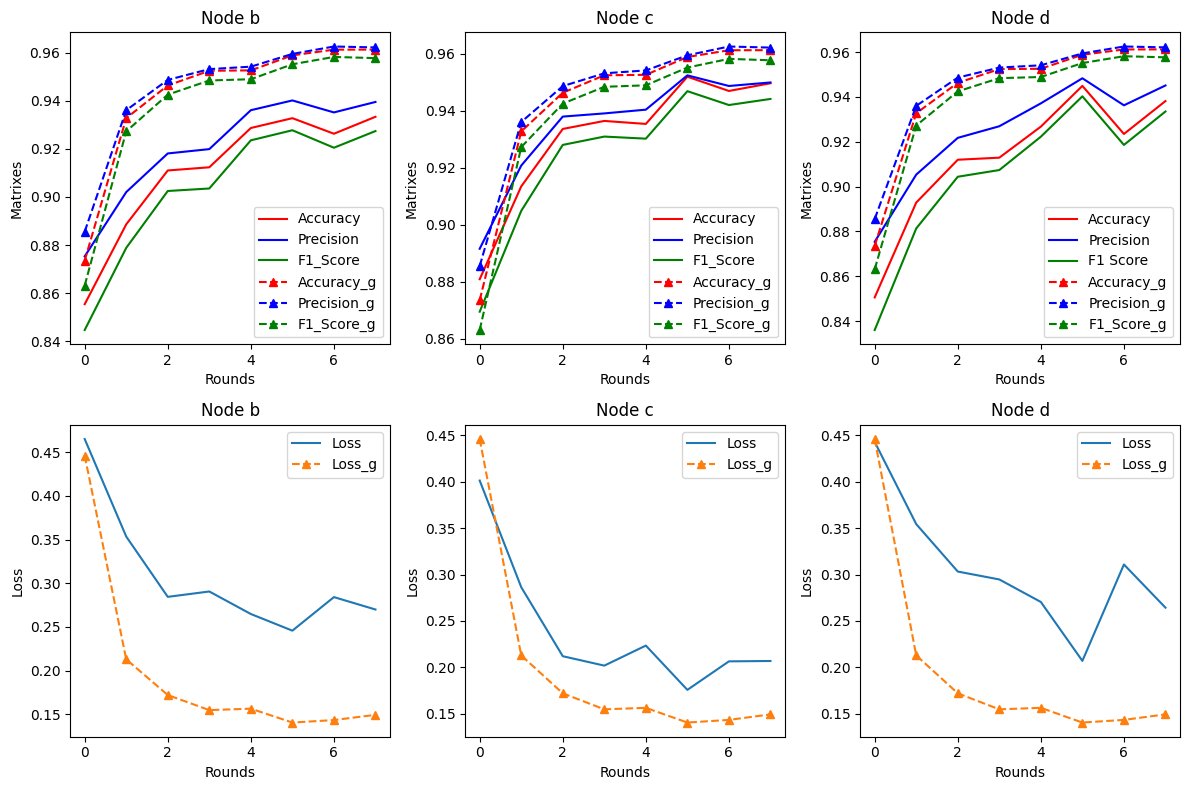

In [14]:
def plot_result(a,b,c,d):
    # Extract the metrics for each node
    rounds = [i for i in range(len(a.eval_results))]
    global_loss = [result[0]['Test/Loss'] for result in a.eval_results]
    global_accuracy = [result[0]['Test/Accuracy'] for result in a.eval_results]
    global_precision = [result[0]['Test/Precision'] for result in a.eval_results]
    global_f1score = [result[0]['Test/F1Score'] for result in a.eval_results]

    # Node b
    node_b_loss = [result[0]['Test/Loss'] for result in b.eval_results]
    node_b_accuracy = [result[0]['Test/Accuracy'] for result in b.eval_results]
    node_b_precision = [result[0]['Test/Precision'] for result in b.eval_results]
    node_b_f1score = [result[0]['Test/F1Score'] for result in b.eval_results]

    # Node c
    node_c_loss = [result[0]['Test/Loss'] for result in c.eval_results]
    node_c_accuracy = [result[0]['Test/Accuracy'] for result in c.eval_results]
    node_c_precision = [result[0]['Test/Precision'] for result in c.eval_results]
    node_c_f1score = [result[0]['Test/F1Score'] for result in c.eval_results]

    # Node d
    node_d_loss = [result[0]['Test/Loss'] for result in d.eval_results]
    node_d_accuracy = [result[0]['Test/Accuracy'] for result in d.eval_results]
    node_d_precision = [result[0]['Test/Precision'] for result in d.eval_results]
    node_d_f1score = [result[0]['Test/F1Score'] for result in d.eval_results]


    # Create subplots for each metric
    fig, axs = plt.subplots(2, 3, figsize=(12, 8))

    # Node b
    axs[0,0].plot(rounds, node_b_accuracy, label='Accuracy',color='red')
    axs[0,0].plot(rounds, node_b_precision, label='Precision',color='blue')
    axs[0,0].plot(rounds, node_b_f1score, label='F1_Score',color='green')
    axs[0,0].plot(rounds, global_accuracy, label='Accuracy_g', linestyle='--',marker='^',color='red')
    axs[0,0].plot(rounds, global_precision, label='Precision_g', linestyle='--',marker='^',color='blue')
    axs[0,0].plot(rounds, global_f1score, label='F1_Score_g', linestyle='--',marker='^',color='green')
    axs[0,0].set_xlabel('Rounds')
    axs[0,0].set_ylabel('Matrixes')
    axs[0,0].set_title('Node b')
    axs[0,0].legend()

    axs[1,0].plot(rounds, node_b_loss, label='Loss')
    axs[1,0].plot(rounds, global_loss, label='Loss_g', linestyle='--',marker='^')
    axs[1,0].set_xlabel('Rounds')
    axs[1,0].set_ylabel('Loss')
    axs[1,0].set_title('Node b')
    axs[1,0].legend()

    # Node c
    axs[0,1].plot(rounds, node_c_accuracy, label='Accuracy',color='red')
    axs[0,1].plot(rounds, node_c_precision, label='Precision', color='blue')
    axs[0,1].plot(rounds, node_c_f1score, label='F1_Score', color='green')
    axs[0,1].plot(rounds, global_accuracy, label='Accuracy_g', linestyle='--',marker='^',color='red')
    axs[0,1].plot(rounds, global_precision, label='Precision_g', linestyle='--',marker='^',color='blue')
    axs[0,1].plot(rounds, global_f1score, label='F1_Score_g', linestyle='--',marker='^',color='green')
    axs[0,1].set_xlabel('Rounds')
    axs[0,1].set_ylabel('Matrixes')
    axs[0,1].set_title('Node c')
    axs[0,1].legend()

    axs[1,1].plot(rounds, node_c_loss, label='Loss')
    axs[1,1].plot(rounds, global_loss, label='Loss_g', linestyle='--',marker='^')
    axs[1,1].set_xlabel('Rounds')
    axs[1,1].set_ylabel('Loss')
    axs[1,1].set_title('Node c')
    axs[1,1].legend()

    # Node d
    axs[0,2].plot(rounds, node_d_accuracy, label='Accuracy',color='red')
    axs[0,2].plot(rounds, node_d_precision, label='Precision', color='blue')
    axs[0,2].plot(rounds, node_d_f1score, label='F1 Score', color='green')
    axs[0,2].plot(rounds, global_accuracy, label='Accuracy_g', linestyle='--',marker='^',color='red')
    axs[0,2].plot(rounds, global_precision, label='Precision_g', linestyle='--',marker='^',color='blue')
    axs[0,2].plot(rounds, global_f1score, label='F1_Score_g', linestyle='--',marker='^',color='green')
    axs[0,2].set_xlabel('Rounds')
    axs[0,2].set_ylabel('Matrixes')
    axs[0,2].set_title('Node d')
    axs[0,2].legend()

    axs[1,2].plot(rounds, node_d_loss, label='Loss')
    axs[1,2].plot(rounds, global_loss, label='Loss_g', linestyle='--',marker='^')
    axs[1,2].set_xlabel('Rounds')
    axs[1,2].set_ylabel('Loss')
    axs[1,2].set_title('Node d')
    axs[1,2].legend()

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()

plot_result(a,b,c,d)


The above experiment is conducted under certain settings:
- 0. Aggregation Function: FedAvg
- 1. Non-IID Scenario 1 (Mild)
- 2. Local training 3 epochs
- 3. Global training 8 Rounds(a round =  broadcast + train + aggregate)

In [13]:
# Scenario 2: Non-IID (normal situation)
# number of sample in each class
d_1 = [2000, 1500, 1000, 1000, 0, 0, 0, 0, 0, 500]
d_2 = [0, 0, 0, 1000, 2000, 1500, 1000, 500, 0, 0]
d_3 = [500, 500, 500, 0, 0, 0, 0, 1000, 1500, 2000]
d_global = [ d_1[i]+d_2[i]+d_3[i] for i in range(10)]
print("d_global", d_global)

train_set1, train_set2, train_set3, test_set = distrbuted_data(starters, d_1, d_2, d_3)

d_global [2500, 2000, 1500, 2000, 2000, 1500, 1000, 1500, 1500, 2500]


In [14]:
model_global = MNISTModelMLP()
model1 = MNISTModelMLP()
model2 = MNISTModelMLP()
model3 = MNISTModelMLP()

a = Server(model_global, test_set)
b = Client("node_b", model1, train_set1, test_set, Epochs=3)
c = Client("node_c", model2, train_set2, test_set, Epochs=3)
d = Client("node_d", model3, train_set3, test_set, Epochs=3)
a.add_client(b)
a.add_client(c)
a.add_client(d)

a.train(rounds=8)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] |

Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.35it/s, v_num=650, Train/Loss=0.0453, Train/Accuracy=0.978, Train/Precision=0.967, Train/Recall=0.978, Train/F1Score=0.970, TrainEpoch/Accuracy=0.959, TrainEpoch/Precision=0.958, TrainEpoch/Recall=0.959, TrainEpoch/F1Score=0.958] Epoch end: Train, epoch number: 2


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.26it/s, v_num=650, Train/Loss=0.0453, Train/Accuracy=0.978, Train/Precision=0.967, Train/Recall=0.978, Train/F1Score=0.970, TrainEpoch/Accuracy=0.959, TrainEpoch/Precision=0.958, TrainEpoch/Recall=0.959, TrainEpoch/F1Score=0.958]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.92it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4852990210056305     │
│       Test/F1Score        │     0.343708872795105     │
│         Test/Loss         │     6.172548770904541     │
│      Test/Precision       │    0.28281334042549133    │
│        Test/Recall        │    0.4852990210056305     │
│    TestEpoch/Accuracy     │    0.4853495955467224     │
│     TestEpoch/F1Score     │    0.3447011113166809     │
│    TestEpoch/Precision    │    0.2772192358970642     │
│     TestEpoch/Recall      │    0.4853495955467224     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, v_num=652, Train/Loss=0.0322, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.947, TrainEpoch/Precision=0.948, TrainEpoch/Recall=0.947, TrainEpoch/F1Score=0.947]Epoch end: Train, epoch number: 2


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.17it/s, v_num=652, Train/Loss=0.0322, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.947, TrainEpoch/Precision=0.948, TrainEpoch/Recall=0.947, TrainEpoch/F1Score=0.947]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.89it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.476703941822052     │
│       Test/F1Score        │    0.32923510670661926    │
│         Test/Loss         │     7.146506309509277     │
│      Test/Precision       │    0.27300357818603516    │
│        Test/Recall        │     0.476703941822052     │
│    TestEpoch/Accuracy     │    0.4780553877353668     │
│     TestEpoch/F1Score     │    0.33264297246932983    │
│    TestEpoch/Precision    │    0.2698832154273987     │
│     TestEpoch/Recall      │    0.4780553877353668     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.22it/s, v_num=654, Train/Loss=0.0729, Train/Accuracy=0.909, Train/Precision=0.978, Train/Recall=0.909, Train/F1Score=0.929, TrainEpoch/Accuracy=0.932, TrainEpoch/Precision=0.938, TrainEpoch/Recall=0.932, TrainEpoch/F1Score=0.935]Epoch end: Train, epoch number: 2


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.14it/s, v_num=654, Train/Loss=0.0729, Train/Accuracy=0.909, Train/Precision=0.978, Train/Recall=0.909, Train/F1Score=0.929, TrainEpoch/Accuracy=0.932, TrainEpoch/Precision=0.938, TrainEpoch/Recall=0.932, TrainEpoch/F1Score=0.935]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.84it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5711889863014221     │
│       Test/F1Score        │    0.4507268965244293     │
│         Test/Loss         │     5.001737117767334     │
│      Test/Precision       │    0.3995494246482849     │
│        Test/Recall        │    0.5711889863014221     │
│    TestEpoch/Accuracy     │     0.572179913520813     │
│     TestEpoch/F1Score     │    0.45381441712379456    │
│    TestEpoch/Precision    │    0.39522773027420044    │
│     TestEpoch/Recall      │     0.572179913520813     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.67it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5613463521003723     │
│       Test/F1Score        │    0.4414213299751282     │
│         Test/Loss         │     1.563139796257019     │
│      Test/Precision       │    0.3919159770011902     │
│        Test/Recall        │    0.5613463521003723     │
│    TestEpoch/Accuracy     │    0.5631391406059265     │
│     TestEpoch/F1Score     │     0.446105420589447     │
│    TestEpoch/Precision    │    0.38805070519447327    │
│     TestEpoch/Recall      │    0.5631391406059265     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 1 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.28it/s, v_num=657, Train/Loss=0.0859, Train/Accuracy=0.943, Train/Precision=0.971, Train/Recall=0.943, Train/F1Score=0.951, TrainEpoch/Accuracy=0.977, TrainEpoch/Precision=0.978, TrainEpoch/Recall=0.977, TrainEpoch/F1Score=0.978] Epoch end: Train, epoch number: 5


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.20it/s, v_num=657, Train/Loss=0.0859, Train/Accuracy=0.943, Train/Precision=0.971, Train/Recall=0.943, Train/F1Score=0.951, TrainEpoch/Accuracy=0.977, TrainEpoch/Precision=0.978, TrainEpoch/Recall=0.977, TrainEpoch/F1Score=0.978]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.79it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4864988625049591     │
│       Test/F1Score        │    0.3407682776451111     │
│         Test/Loss         │     5.341684341430664     │
│      Test/Precision       │    0.2773336172103882     │
│        Test/Recall        │    0.4864988625049591     │
│    TestEpoch/Accuracy     │    0.48664042353630066    │
│     TestEpoch/F1Score     │    0.34149599075317383    │
│    TestEpoch/Precision    │    0.2713673710823059     │
│     TestEpoch/Recall      │    0.48664042353630066    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.08it/s, v_num=659, Train/Loss=0.0824, Train/Accuracy=0.889, Train/Precision=0.889, Train/Recall=0.889, Train/F1Score=0.889, TrainEpoch/Accuracy=0.963, TrainEpoch/Precision=0.965, TrainEpoch/Recall=0.963, TrainEpoch/F1Score=0.964]Epoch end: Train, epoch number: 5


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.00it/s, v_num=659, Train/Loss=0.0824, Train/Accuracy=0.889, Train/Precision=0.889, Train/Recall=0.889, Train/F1Score=0.889, TrainEpoch/Accuracy=0.963, TrainEpoch/Precision=0.965, TrainEpoch/Recall=0.963, TrainEpoch/F1Score=0.964]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.90it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4788515567779541     │
│       Test/F1Score        │    0.32297012209892273    │
│         Test/Loss         │     5.575913429260254     │
│      Test/Precision       │    0.25864532589912415    │
│        Test/Recall        │    0.4788515567779541     │
│    TestEpoch/Accuracy     │    0.4810272455215454     │
│     TestEpoch/F1Score     │    0.32564330101013184    │
│    TestEpoch/Precision    │    0.2535492777824402     │
│     TestEpoch/Recall      │    0.4810272455215454     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.22it/s, v_num=661, Train/Loss=0.141, Train/Accuracy=0.969, Train/Precision=0.867, Train/Recall=0.969, Train/F1Score=0.902, TrainEpoch/Accuracy=0.955, TrainEpoch/Precision=0.957, TrainEpoch/Recall=0.955, TrainEpoch/F1Score=0.956] Epoch end: Train, epoch number: 5


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.14it/s, v_num=661, Train/Loss=0.141, Train/Accuracy=0.969, Train/Precision=0.867, Train/Recall=0.969, Train/F1Score=0.902, TrainEpoch/Accuracy=0.955, TrainEpoch/Precision=0.957, TrainEpoch/Recall=0.955, TrainEpoch/F1Score=0.956]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.87it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5753902792930603     │
│       Test/F1Score        │    0.4500437080860138     │
│         Test/Loss         │    3.9865663051605225     │
│      Test/Precision       │    0.39153239130973816    │
│        Test/Recall        │    0.5753902792930603     │
│    TestEpoch/Accuracy     │    0.5773302316665649     │
│     TestEpoch/F1Score     │    0.45396411418914795    │
│    TestEpoch/Precision    │    0.3885941803455353     │
│     TestEpoch/Recall      │    0.5773302316665649     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.49it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.593604564666748     │
│       Test/F1Score        │    0.47878652811050415    │
│         Test/Loss         │    1.3308686017990112     │
│      Test/Precision       │     0.453457236289978     │
│        Test/Recall        │     0.593604564666748     │
│    TestEpoch/Accuracy     │    0.5938124060630798     │
│     TestEpoch/F1Score     │    0.48523104190826416    │
│    TestEpoch/Precision    │    0.5779540538787842     │
│     TestEpoch/Recall      │    0.5938124060630798     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 2 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.17it/s, v_num=663, Train/Loss=0.0554, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.987, TrainEpoch/Precision=0.987, TrainEpoch/Recall=0.987, TrainEpoch/F1Score=0.987] Epoch end: Train, epoch number: 8


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.08it/s, v_num=663, Train/Loss=0.0554, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.987, TrainEpoch/Precision=0.987, TrainEpoch/Recall=0.987, TrainEpoch/F1Score=0.987]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.83it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.48652783036231995    │
│       Test/F1Score        │    0.34517940878868103    │
│         Test/Loss         │     5.64033317565918      │
│      Test/Precision       │    0.2860320210456848     │
│        Test/Recall        │    0.48652783036231995    │
│    TestEpoch/Accuracy     │    0.4861907362937927     │
│     TestEpoch/F1Score     │    0.3460698425769806     │
│    TestEpoch/Precision    │    0.28042033314704895    │
│     TestEpoch/Recall      │    0.4861907362937927     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.14it/s, v_num=665, Train/Loss=0.0801, Train/Accuracy=0.933, Train/Precision=0.988, Train/Recall=0.933, Train/F1Score=0.954, TrainEpoch/Accuracy=0.976, TrainEpoch/Precision=0.977, TrainEpoch/Recall=0.976, TrainEpoch/F1Score=0.976] Epoch end: Train, epoch number: 8


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.02it/s, v_num=665, Train/Loss=0.0801, Train/Accuracy=0.933, Train/Precision=0.988, Train/Recall=0.933, Train/F1Score=0.954, TrainEpoch/Accuracy=0.976, TrainEpoch/Precision=0.977, TrainEpoch/Recall=0.976, TrainEpoch/F1Score=0.976]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.03it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.48002466559410095    │
│       Test/F1Score        │    0.3271140158176422     │
│         Test/Loss         │     5.098587989807129     │
│      Test/Precision       │    0.2647770941257477     │
│        Test/Recall        │    0.48002466559410095    │
│    TestEpoch/Accuracy     │    0.48162057995796204    │
│     TestEpoch/F1Score     │    0.3298489451408386     │
│    TestEpoch/Precision    │    0.2603846788406372     │
│     TestEpoch/Recall      │    0.48162057995796204    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.26it/s, v_num=667, Train/Loss=0.0849, Train/Accuracy=0.935, Train/Precision=0.963, Train/Recall=0.935, Train/F1Score=0.946, TrainEpoch/Accuracy=0.969, TrainEpoch/Precision=0.970, TrainEpoch/Recall=0.969, TrainEpoch/F1Score=0.969]Epoch end: Train, epoch number: 8


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.17it/s, v_num=667, Train/Loss=0.0849, Train/Accuracy=0.935, Train/Precision=0.963, Train/Recall=0.935, Train/F1Score=0.946, TrainEpoch/Accuracy=0.969, TrainEpoch/Precision=0.970, TrainEpoch/Recall=0.969, TrainEpoch/F1Score=0.969]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.93it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5782902240753174     │
│       Test/F1Score        │     0.457516610622406     │
│         Test/Loss         │    4.0618438720703125     │
│      Test/Precision       │    0.4055226743221283     │
│        Test/Recall        │    0.5782902240753174     │
│    TestEpoch/Accuracy     │    0.5792653560638428     │
│     TestEpoch/F1Score     │     0.46104896068573      │
│    TestEpoch/Precision    │    0.40336886048316956    │
│     TestEpoch/Recall      │    0.5792653560638428     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.30it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.6128993034362793     │
│       Test/F1Score        │     0.509787380695343     │
│         Test/Loss         │    1.3167617321014404     │
│      Test/Precision       │    0.5069701671600342     │
│        Test/Recall        │    0.6128993034362793     │
│    TestEpoch/Accuracy     │    0.6128161549568176     │
│     TestEpoch/F1Score     │    0.5177115201950073     │
│    TestEpoch/Precision    │     0.793329119682312     │
│     TestEpoch/Recall      │    0.6128161549568176     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 3 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.35it/s, v_num=669, Train/Loss=0.000121, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.992, TrainEpoch/Precision=0.993, TrainEpoch/Recall=0.992, TrainEpoch/F1Score=0.993]Epoch end: Train, epoch number: 11


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.27it/s, v_num=669, Train/Loss=0.000121, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.992, TrainEpoch/Precision=0.993, TrainEpoch/Recall=0.992, TrainEpoch/F1Score=0.993]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:11<00:00, 13.94it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4921877980232239     │
│       Test/F1Score        │    0.34569185972213745    │
│         Test/Loss         │    5.6160125732421875     │
│      Test/Precision       │    0.2877398133277893     │
│        Test/Recall        │    0.4921877980232239     │
│    TestEpoch/Accuracy     │    0.4917333126068115     │
│     TestEpoch/F1Score     │    0.3469691276550293     │
│    TestEpoch/Precision    │    0.36971181631088257    │
│     TestEpoch/Recall      │    0.4917333126068115     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00,  9.86it/s, v_num=671, Train/Loss=0.0039, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.984, TrainEpoch/Precision=0.985, TrainEpoch/Recall=0.984, TrainEpoch/F1Score=0.984] Epoch end: Train, epoch number: 11


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00,  9.78it/s, v_num=671, Train/Loss=0.0039, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.984, TrainEpoch/Precision=0.985, TrainEpoch/Recall=0.984, TrainEpoch/F1Score=0.984]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.64it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.48090532422065735    │
│       Test/F1Score        │     0.318683922290802     │
│         Test/Loss         │     4.99398136138916      │
│      Test/Precision       │    0.24976642429828644    │
│        Test/Recall        │    0.48090532422065735    │
│    TestEpoch/Accuracy     │    0.4820774793624878     │
│     TestEpoch/F1Score     │    0.32060933113098145    │
│    TestEpoch/Precision    │    0.24352963268756866    │
│     TestEpoch/Recall      │    0.4820774793624878     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.39it/s, v_num=673, Train/Loss=0.0315, Train/Accuracy=0.989, Train/Precision=0.986, Train/Recall=0.989, Train/F1Score=0.987, TrainEpoch/Accuracy=0.977, TrainEpoch/Precision=0.977, TrainEpoch/Recall=0.977, TrainEpoch/F1Score=0.977] Epoch end: Train, epoch number: 11


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, v_num=673, Train/Loss=0.0315, Train/Accuracy=0.989, Train/Precision=0.986, Train/Recall=0.989, Train/F1Score=0.987, TrainEpoch/Accuracy=0.977, TrainEpoch/Precision=0.977, TrainEpoch/Recall=0.977, TrainEpoch/F1Score=0.977]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.09it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5786662697792053     │
│       Test/F1Score        │    0.46400830149650574    │
│         Test/Loss         │     4.09635066986084      │
│      Test/Precision       │    0.4192812442779541     │
│        Test/Recall        │    0.5786662697792053     │
│    TestEpoch/Accuracy     │    0.5801724195480347     │
│     TestEpoch/F1Score     │    0.46785032749176025    │
│    TestEpoch/Precision    │    0.5149049162864685     │
│     TestEpoch/Recall      │    0.5801724195480347     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.87it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.6464142203330994     │
│       Test/F1Score        │    0.5587410926818848     │
│         Test/Loss         │    1.1150519847869873     │
│      Test/Precision       │    0.5880222320556641     │
│        Test/Recall        │    0.6464142203330994     │
│    TestEpoch/Accuracy     │    0.6454941034317017     │
│     TestEpoch/F1Score     │    0.5701341032981873     │
│    TestEpoch/Precision    │    0.8028554916381836     │
│     TestEpoch/Recall      │    0.6454941034317017     │
└───────────────────────────┴───────────────────────────┘

Evaluating at Server finished
Round 4 finished
Training at node_b:


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.26it/s, v_num=675, Train/Loss=0.00348, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.996, TrainEpoch/Precision=0.996, TrainEpoch/Recall=0.996, TrainEpoch/F1Score=0.996] Epoch end: Train, epoch number: 14


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.16it/s, v_num=675, Train/Loss=0.00348, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.996, TrainEpoch/Precision=0.996, TrainEpoch/Recall=0.996, TrainEpoch/F1Score=0.996]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.44it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4949115812778473     │
│       Test/F1Score        │    0.34908825159072876    │
│         Test/Loss         │     5.638856887817383     │
│      Test/Precision       │    0.2973850965499878     │
│        Test/Recall        │    0.4949115812778473     │
│    TestEpoch/Accuracy     │    0.49496957659721375    │
│     TestEpoch/F1Score     │    0.3512938320636749     │
│    TestEpoch/Precision    │    0.36908096075057983    │
│     TestEpoch/Recall      │    0.49496957659721375    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.14it/s, v_num=677, Train/Loss=0.110, Train/Accuracy=0.986, Train/Precision=0.960, Train/Recall=0.986, Train/F1Score=0.970, TrainEpoch/Accuracy=0.986, TrainEpoch/Precision=0.987, TrainEpoch/Recall=0.986, TrainEpoch/F1Score=0.986]  Epoch end: Train, epoch number: 14


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.06it/s, v_num=677, Train/Loss=0.110, Train/Accuracy=0.986, Train/Precision=0.960, Train/Recall=0.986, Train/F1Score=0.970, TrainEpoch/Accuracy=0.986, TrainEpoch/Precision=0.987, TrainEpoch/Recall=0.986, TrainEpoch/F1Score=0.986]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.87it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.483718603849411     │
│       Test/F1Score        │    0.3255605697631836     │
│         Test/Loss         │     4.904936790466309     │
│      Test/Precision       │    0.26152923703193665    │
│        Test/Recall        │     0.483718603849411     │
│    TestEpoch/Accuracy     │    0.4849839210510254     │
│     TestEpoch/F1Score     │    0.32838335633277893    │
│    TestEpoch/Precision    │    0.35639071464538574    │
│     TestEpoch/Recall      │    0.4849839210510254     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.13it/s, v_num=679, Train/Loss=0.0633, Train/Accuracy=0.993, Train/Precision=0.981, Train/Recall=0.993, Train/F1Score=0.986, TrainEpoch/Accuracy=0.986, TrainEpoch/Precision=0.986, TrainEpoch/Recall=0.986, TrainEpoch/F1Score=0.986] Epoch end: Train, epoch number: 14


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, v_num=679, Train/Loss=0.0633, Train/Accuracy=0.993, Train/Precision=0.981, Train/Recall=0.993, Train/F1Score=0.986, TrainEpoch/Accuracy=0.986, TrainEpoch/Precision=0.986, TrainEpoch/Recall=0.986, TrainEpoch/F1Score=0.986]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.87it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.583102285861969     │
│       Test/F1Score        │    0.4638247489929199     │
│         Test/Loss         │    3.7599964141845703     │
│      Test/Precision       │    0.41745850443840027    │
│        Test/Recall        │     0.583102285861969     │
│    TestEpoch/Accuracy     │    0.5844798684120178     │
│     TestEpoch/F1Score     │    0.4677211344242096     │
│    TestEpoch/Precision    │    0.5036010146141052     │
│     TestEpoch/Recall      │    0.5844798684120178     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.69it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.6773847937583923     │
│       Test/F1Score        │     0.602591872215271     │
│         Test/Loss         │    1.0435118675231934     │
│      Test/Precision       │    0.6504878401756287     │
│        Test/Recall        │    0.6773847937583923     │
│    TestEpoch/Accuracy     │    0.6769194602966309     │
│     TestEpoch/F1Score     │    0.6153784990310669     │
│    TestEpoch/Precision    │    0.8119399547576904     │
│     TestEpoch/Recall      │    0.6769194602966309     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 5 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.14it/s, v_num=681, Train/Loss=0.000678, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.995, TrainEpoch/Precision=0.995, TrainEpoch/Recall=0.995, TrainEpoch/F1Score=0.995]Epoch end: Train, epoch number: 17


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.06it/s, v_num=681, Train/Loss=0.000678, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.995, TrainEpoch/Precision=0.995, TrainEpoch/Recall=0.995, TrainEpoch/F1Score=0.995]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.82it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5008935928344727     │
│       Test/F1Score        │    0.3583945631980896     │
│         Test/Loss         │     4.96069860458374      │
│      Test/Precision       │    0.32265105843544006    │
│        Test/Recall        │    0.5008935928344727     │
│    TestEpoch/Accuracy     │     0.500504195690155     │
│     TestEpoch/F1Score     │    0.36127781867980957    │
│    TestEpoch/Precision    │    0.36776140332221985    │
│     TestEpoch/Recall      │     0.500504195690155     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.22it/s, v_num=683, Train/Loss=0.00319, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.991, TrainEpoch/Precision=0.992, TrainEpoch/Recall=0.991, TrainEpoch/F1Score=0.992]Epoch end: Train, epoch number: 17


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.11it/s, v_num=683, Train/Loss=0.00319, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.991, TrainEpoch/Precision=0.992, TrainEpoch/Recall=0.991, TrainEpoch/F1Score=0.992]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.89it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4877385199069977     │
│       Test/F1Score        │    0.33203643560409546    │
│         Test/Loss         │     4.540739059448242     │
│      Test/Precision       │    0.2872069776058197     │
│        Test/Recall        │    0.4877385199069977     │
│    TestEpoch/Accuracy     │    0.4887104332447052     │
│     TestEpoch/F1Score     │    0.33634036779403687    │
│    TestEpoch/Precision    │    0.45185011625289917    │
│     TestEpoch/Recall      │    0.4887104332447052     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.09it/s, v_num=685, Train/Loss=0.00966, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.991, TrainEpoch/Precision=0.990, TrainEpoch/Recall=0.991, TrainEpoch/F1Score=0.990]Epoch end: Train, epoch number: 17


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00,  9.75it/s, v_num=685, Train/Loss=0.00966, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.991, TrainEpoch/Precision=0.990, TrainEpoch/Recall=0.991, TrainEpoch/F1Score=0.990]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.93it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5863596200942993     │
│       Test/F1Score        │    0.4653983414173126     │
│         Test/Loss         │     3.783930540084839     │
│      Test/Precision       │    0.42020630836486816    │
│        Test/Recall        │    0.5863596200942993     │
│    TestEpoch/Accuracy     │     0.587584376335144     │
│     TestEpoch/F1Score     │    0.4693140685558319     │
│    TestEpoch/Precision    │    0.5016549229621887     │
│     TestEpoch/Recall      │     0.587584376335144     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.79it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.712835967540741     │
│       Test/F1Score        │    0.6507472991943359     │
│         Test/Loss         │    0.8857488036155701     │
│      Test/Precision       │    0.7093393802642822     │
│        Test/Recall        │     0.712835967540741     │
│    TestEpoch/Accuracy     │    0.7127982378005981     │
│     TestEpoch/F1Score     │    0.6655817627906799     │
│    TestEpoch/Precision    │    0.8180246353149414     │
│     TestEpoch/Recall      │    0.7127982378005981     │
└───────────────────────────┴───────────────────────────┘

Evaluating at Server finished
Round 6 finished


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.00it/s, v_num=687, Train/Loss=0.00116, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.999, TrainEpoch/Precision=0.999, TrainEpoch/Recall=0.999, TrainEpoch/F1Score=0.999] Epoch end: Train, epoch number: 20


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00,  9.90it/s, v_num=687, Train/Loss=0.00116, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.999, TrainEpoch/Precision=0.999, TrainEpoch/Recall=0.999, TrainEpoch/F1Score=0.999]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.90it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4982963800430298     │
│       Test/F1Score        │     0.353617399930954     │
│         Test/Loss         │     5.575506687164307     │
│      Test/Precision       │    0.3074207603931427     │
│        Test/Recall        │    0.4982963800430298     │
│    TestEpoch/Accuracy     │    0.49838975071907043    │
│     TestEpoch/F1Score     │    0.3570669889450073     │
│    TestEpoch/Precision    │    0.3721393048763275     │
│     TestEpoch/Recall      │    0.49838975071907043    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.34it/s, v_num=689, Train/Loss=0.0245, Train/Accuracy=0.986, Train/Precision=0.975, Train/Recall=0.986, Train/F1Score=0.979, TrainEpoch/Accuracy=0.996, TrainEpoch/Precision=0.996, TrainEpoch/Recall=0.996, TrainEpoch/F1Score=0.996]  Epoch end: Train, epoch number: 20


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.26it/s, v_num=689, Train/Loss=0.0245, Train/Accuracy=0.986, Train/Precision=0.975, Train/Recall=0.986, Train/F1Score=0.979, TrainEpoch/Accuracy=0.996, TrainEpoch/Precision=0.996, TrainEpoch/Recall=0.996, TrainEpoch/F1Score=0.996]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.96it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.48789268732070923    │
│       Test/F1Score        │    0.3344593048095703     │
│         Test/Loss         │     4.599153995513916     │
│      Test/Precision       │    0.2858283221721649     │
│        Test/Recall        │    0.48789268732070923    │
│    TestEpoch/Accuracy     │    0.4884321987628937     │
│     TestEpoch/F1Score     │    0.33751267194747925    │
│    TestEpoch/Precision    │    0.4524162709712982     │
│     TestEpoch/Recall      │    0.4884321987628937     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.18it/s, v_num=691, Train/Loss=0.0259, Train/Accuracy=0.944, Train/Precision=0.983, Train/Recall=0.944, Train/F1Score=0.958, TrainEpoch/Accuracy=0.995, TrainEpoch/Precision=0.995, TrainEpoch/Recall=0.995, TrainEpoch/F1Score=0.995]  Epoch end: Train, epoch number: 20


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.10it/s, v_num=691, Train/Loss=0.0259, Train/Accuracy=0.944, Train/Precision=0.983, Train/Recall=0.944, Train/F1Score=0.958, TrainEpoch/Accuracy=0.995, TrainEpoch/Precision=0.995, TrainEpoch/Recall=0.995, TrainEpoch/F1Score=0.995]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:11<00:00, 13.20it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5859346389770508     │
│       Test/F1Score        │    0.4702681601047516     │
│         Test/Loss         │     3.929518699645996     │
│      Test/Precision       │    0.43369877338409424    │
│        Test/Recall        │    0.5859346389770508     │
│    TestEpoch/Accuracy     │    0.5872366428375244     │
│     TestEpoch/F1Score     │    0.47483009099960327    │
│    TestEpoch/Precision    │    0.5093331336975098     │
│     TestEpoch/Recall      │    0.5872366428375244     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:11<00:00, 14.21it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.7339602708816528     │
│       Test/F1Score        │    0.6829544901847839     │
│         Test/Loss         │    0.8642025589942932     │
│      Test/Precision       │    0.7442156672477722     │
│        Test/Recall        │    0.7339602708816528     │
│    TestEpoch/Accuracy     │    0.7328578233718872     │
│     TestEpoch/F1Score     │    0.6964813470840454     │
│    TestEpoch/Precision    │    0.8330948352813721     │
│     TestEpoch/Recall      │    0.7328578233718872     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 7 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00,  9.67it/s, v_num=693, Train/Loss=0.000857, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.995, TrainEpoch/Precision=0.995, TrainEpoch/Recall=0.995, TrainEpoch/F1Score=0.995]Epoch end: Train, epoch number: 23


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00,  9.53it/s, v_num=693, Train/Loss=0.000857, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.995, TrainEpoch/Precision=0.995, TrainEpoch/Recall=0.995, TrainEpoch/F1Score=0.995]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:11<00:00, 14.07it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.49654731154441833    │
│       Test/F1Score        │    0.3603977560997009     │
│         Test/Loss         │     5.895594120025635     │
│      Test/Precision       │    0.3228316903114319     │
│        Test/Recall        │    0.49654731154441833    │
│    TestEpoch/Accuracy     │    0.4963810443878174     │
│     TestEpoch/F1Score     │    0.36297446489334106    │
│    TestEpoch/Precision    │    0.3890097737312317     │
│     TestEpoch/Recall      │    0.4963810443878174     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.04it/s, v_num=695, Train/Loss=0.0113, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.997, TrainEpoch/Precision=0.997, TrainEpoch/Recall=0.997, TrainEpoch/F1Score=0.997]  Epoch end: Train, epoch number: 23


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00,  9.97it/s, v_num=695, Train/Loss=0.0113, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.997, TrainEpoch/Precision=0.997, TrainEpoch/Recall=0.997, TrainEpoch/F1Score=0.997]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.96it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4924549460411072     │
│       Test/F1Score        │    0.3335973918437958     │
│         Test/Loss         │     4.59010648727417      │
│      Test/Precision       │    0.2890223562717438     │
│        Test/Recall        │    0.4924549460411072     │
│    TestEpoch/Accuracy     │    0.49355149269104004    │
│     TestEpoch/F1Score     │    0.3380758762359619     │
│    TestEpoch/Precision    │    0.44800516963005066    │
│     TestEpoch/Recall      │    0.49355149269104004    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.12it/s, v_num=697, Train/Loss=0.00466, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.997, TrainEpoch/Precision=0.997, TrainEpoch/Recall=0.997, TrainEpoch/F1Score=0.997] Epoch end: Train, epoch number: 23


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.02it/s, v_num=697, Train/Loss=0.00466, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.997, TrainEpoch/Precision=0.997, TrainEpoch/Recall=0.997, TrainEpoch/F1Score=0.997]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.11it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5890455842018127     │
│       Test/F1Score        │    0.4744739830493927     │
│         Test/Loss         │    4.1570611000061035     │
│      Test/Precision       │    0.44455233216285706    │
│        Test/Recall        │    0.5890455842018127     │
│    TestEpoch/Accuracy     │    0.5904313325881958     │
│     TestEpoch/F1Score     │    0.4792920649051666     │
│    TestEpoch/Precision    │    0.5098697543144226     │
│     TestEpoch/Recall      │    0.5904313325881958     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.94it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.7491034865379333     │
│       Test/F1Score        │    0.7045047879219055     │
│         Test/Loss         │    0.8613114953041077     │
│      Test/Precision       │    0.7669392228126526     │
│        Test/Recall        │    0.7491034865379333     │
│    TestEpoch/Accuracy     │    0.7478897571563721     │
│     TestEpoch/F1Score     │    0.7164129018783569     │
│    TestEpoch/Precision    │    0.8456255793571472     │
│     TestEpoch/Recall      │    0.7478897571563721     │
└───────────────────────────┴───────────────────────────┘

Evaluating at Server finished
Round 8 finished
train took 1090.0250 seconds


In [15]:
FedAvg_s2={'Scenario2':[a,b,c,d]}
pickle.dump(FedAvg_s2, open("FedAvg_non_iid_s2.pkl", "wb"))

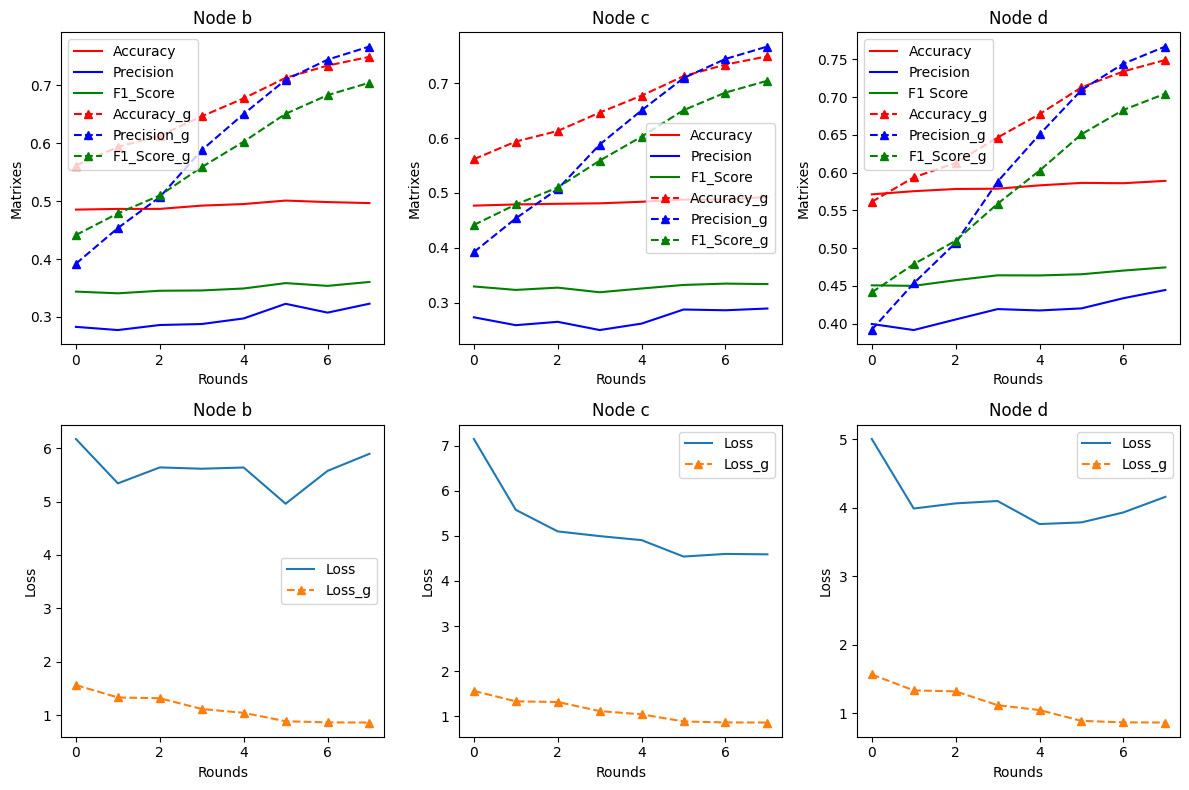

In [17]:
plot_result(a,b,c,d)

The above experiment is conducted under certain settings:
- 0. Aggregation Function: FedAvg
- 1. Non-IID Scenario 2 (Normal)
- 2. Local training 3 epochs
- 3. Global training 8 Rounds(a round =  broadcast + train + aggregate)

## FedEP in Centralized Federated Learning (CFL) Scenario

We propose a method involving:

- 1.Fitting the data distribution of each client's dataset to a Gaussian Mixture Model (GMM) with an Expectation-Maximization (EM) method.
- 2.Sharing the parameters of the GMM as statistical characteristics of each client.
- 3.Using the shared statistical characteristics to calculate the global distribution.
- 4.Calculating the distance (KL divergence) between the global distribution and each client's local distribution
- 5.Utilizing this distance as a parameter in model aggregation.

We first examine step 1 to 3:

In [18]:
# using data distributions in Scenario 2: Non-IID (normal) as example
# number of sample in each class
d_1 = [2000, 1500, 1000, 1000, 0, 0, 0, 0, 0, 500]
d_2 = [0, 0, 0, 1000, 2000, 1500, 1000, 500, 0, 0]
d_3 = [500, 500, 500, 0, 0, 0, 0, 1000, 1500, 2000]
d_global = [ d_1[i]+d_2[i]+d_3[i] for i in range(10)]


In [19]:
np.random.seed(2023)

train_set1, train_set2, train_set3, test_set = distrbuted_data(starters, d_1, d_2, d_3)

In [22]:
import math

epsilon_prime = 0.1

def gaussian(Y, mu, sigma_squared):
    return np.exp(-np.square(Y-mu+epsilon_prime)/(2*(sigma_squared+epsilon_prime)))/(np.sqrt(2 * np.pi * (sigma_squared+epsilon_prime)))

def E_step(theta,Y):
    M = theta.shape[0]
    gamma_lm = np.zeros((len(Y),M))
    n_m = np.zeros(M)
    sum_gaussians = torch.zeros([len(Y)])
    for m in range(M):
        sum_gaussians += theta[m,0] * gaussian(Y, theta[m,1], theta[m,2])
    for m in range(M):
        gamma_lm[:,m] = theta[m,0] * gaussian(Y, theta[m,1], theta[m,2])/ sum_gaussians
        n_m[m] = np.sum(gamma_lm[:,m])
    return gamma_lm, n_m


def M_step(gamma, n_m, Y):
    pi_h = n_m/len(Y)
    mu_h = np.array([gamma[:,m]@Y.numpy()/n_m[m] for m in range(len(n_m))])
    sigma_squared_h = np.array([gamma[:,m]@((Y.numpy()-mu_h[m])**2+epsilon_prime)/n_m[m] for m in range(len(n_m))])
    theta_h = np.column_stack((pi_h, mu_h, sigma_squared_h))

    likelihood = np.sum([n_m[m] * np.log(pi_h[m])+ gamma[:,m] @ np.log(gaussian(Y.numpy(), mu_h[m], sigma_squared_h[m])+epsilon_prime) for m in range(len(n_m))])
    return theta_h, likelihood

def parameter_initialization(M,Y):
    L=len(Y)
    # π (mixture weights)
    pi = np.random.rand(M)
    pi /= np.sum(pi)
    # μ (means)
    mu = Y[np.random.choice(L, M, replace=False)]
    # ϵ^2 (variances)
    sigma_squared = [np.var(Y.tolist())] * M
    # theta_0
    return np.column_stack((pi, mu, sigma_squared))

def Expectation_Maximum_Algorithm(M,Y, max_iterations=50, epsilon=1e-6):
    theta = parameter_initialization(M,Y)
    # print(f"-------- M = {M} --------")
    likelihood_prev = 0
    theta_prev = theta
    iteration = 0
    while iteration < max_iterations:
        gamma, n_m = E_step(theta,Y)
        theta, likelihood = M_step(gamma, n_m, Y)
        iteration += 1
        if likelihood == np.NINF or math.isnan(likelihood):
            # print(f"iteration: {iteration}, likelihood: {likelihood_prev}, theta: {theta_prev}")
            return theta_prev, likelihood_prev
        if abs(likelihood - likelihood_prev) < epsilon:
            break
        likelihood_prev = likelihood
        theta_prev = theta
    # print(f"iteration: {iteration}, likelihood: {likelihood}, theta: {theta}")
    return theta, likelihood


def Distribution_Fitting(Y, max_components_fraction=0.5):
    # deciede the maximum number of mixture components
    Ms = math.ceil(len(set(Y.tolist())) * max_components_fraction) 
    print(f"Ms: {Ms}")
    theta_hs = np.empty(Ms, dtype=object)
    likelihood_hs = np.zeros(Ms)
    BICs = np.zeros(Ms)
    AICs = np.zeros(Ms)
    for M in range(0,Ms):
        theta_hs[M], likelihood_hs[M] = Expectation_Maximum_Algorithm(M+1,Y)
        BICs[M] = -2*likelihood_hs[M] + M * np.log(len(Y))
        AICs[M] = -2*likelihood_hs[M] + 2 * M
    # print(f"theta_hs: {theta_hs}")
    print(f"likelihood_hs: {likelihood_hs}")
    print(f"BICs: {BICs}")
    # print(f"AICs: {AICs}")
    min_BIC_index = np.argmin(BICs)
    # print(f"min_BIC_index: {min_BIC_index}")
    return theta_hs[min_BIC_index], likelihood_hs[min_BIC_index]

def predict_likelihood(theta, labels, precision=3):
    prob = np.zeros(len(labels))
    for i in range(len(prob)): 
        prob[i] = np.round(np.sum(theta[:,0] * gaussian(labels[i], theta[:,1], theta[:,2])),precision)
    return prob

In [22]:
np.random.seed(2023)

unique_sorted_labels_list = torch.unique(mnist_train.targets, sorted=True).tolist()

Y = train_set1.targets
theta1, likelihood1 = Distribution_Fitting(Y)

print(f"theta1: {theta1}")
print(f"likelihood1: {likelihood1}")

prob1 = predict_likelihood(theta1, unique_sorted_labels_list)
print(f"prob1: {prob1}")


Ms: 3
likelihood_hs: [ -8911.95074005  -7968.29019162 -10253.51083029]
BICs: [17823.9014801  15945.27989798 20524.42069007]
theta1: [[0.08333333 9.         0.1       ]
 [0.91666667 1.18181818 1.33966943]]
likelihood1: -7968.290191617825
prob1: [0.203 0.304 0.227 0.085 0.016 0.001 0.    0.    0.01  0.073]


In [23]:
np.random.seed(2023)

Y = train_set2.targets
theta2, likelihood2 = Distribution_Fitting(Y)
print(f"theta2: {theta2}")
print(f"likelihood2: {likelihood2}")

prob2 = predict_likelihood(theta2,unique_sorted_labels_list)
print(f"prob2: {prob2}")

Ms: 3
likelihood_hs: [ -6962.3448647   -9256.01780401 -11420.68515198]
BICs: [13924.6897294  18520.73512277 22858.76933345]
theta2: [[1.         4.66666667 1.48888889]]
likelihood2: -6962.3448646996185
prob2: [0.    0.006 0.04  0.146 0.286 0.298 0.166 0.049 0.008 0.001]


In [24]:
np.random.seed(2023)

Y = train_set3.targets
theta3, likelihood3 = Distribution_Fitting(Y)

print(f"theta3: {theta3}")
print(f"likelihood3: {likelihood3}")

prob3 = predict_likelihood(theta3,unique_sorted_labels_list)
print(f"prob3: {prob3}")

Ms: 3
likelihood_hs: [-10249.58881831  -8855.91689667  -9788.31219583]
BICs: [20499.17763662 17720.53330809 19594.02342116]
theta3: [[0.75       8.22222222 0.71728395]
 [0.25       1.         0.76666667]]
likelihood3: -8855.91689667205
prob3: [0.067 0.107 0.053 0.008 0.    0.001 0.021 0.153 0.328 0.207]


theta_global: [[0.02777778 9.         0.1       ]
 [0.30555556 1.18181818 1.33966943]
 [0.33333333 4.66666667 1.48888889]
 [0.25       8.22222222 0.71728395]
 [0.08333333 1.         0.76666667]]


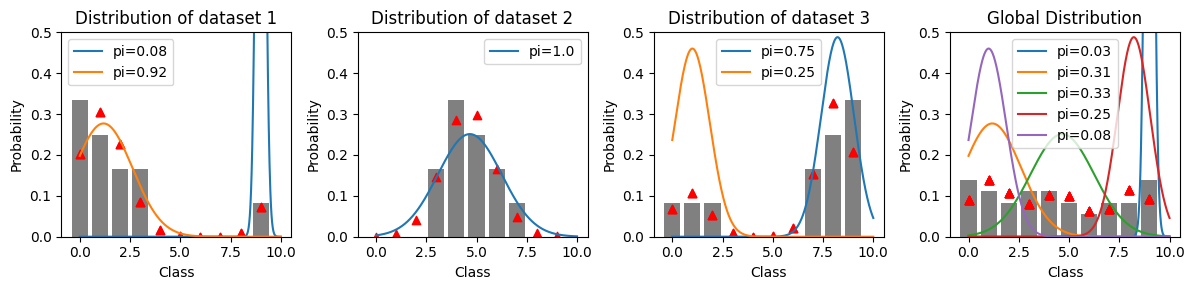

In [25]:

# Scenario 2: Non-IID (normal situation)

from scipy.stats import norm

normalized_d_1 = [v / sum(d_1) for v in d_1]
normalized_d_2 = [v / sum(d_2) for v in d_2]
normalized_d_3 = [v / sum(d_3) for v in d_3]
normalized_d_global = [v / sum(d_global) for v in d_global]

def normalize_global_pi(theta, data_client, data_global):
    theta_new = np.copy(theta)
    theta_new[:,0] = theta[:,0]*data_client/data_global
    return theta_new

data1 = len(train_set1.targets)
data2 = len(train_set2.targets)
data3 = len(train_set3.targets)
data_global = data1 + data2 + data3

theta_global = np.vstack((normalize_global_pi(theta1, data1, data_global),normalize_global_pi(theta2, data2, data_global),normalize_global_pi(theta3, data3, data_global)))
print(f"theta_global: {theta_global}")

# Define the class labels
class_labels = list(range(10))

# Define the data
data = [normalized_d_1, normalized_d_2, normalized_d_3, normalized_d_global]
theta = [theta1, theta2, theta3, theta_global]


prob_global = predict_likelihood(theta_global,unique_sorted_labels_list)
prob = [prob1, prob2, prob3, prob_global]

# Plot the histograms
fig, ax = plt.subplots(1, 4, figsize=(12, 3))

for i in range(4):
    ax[i].bar(class_labels, data[i], color='grey')
    ax[i].set_xlabel('Class')
    ax[i].set_ylabel('Probability')
    ax[i].set_ylim(0, 0.5)
    
    for m in range(len(theta[i])):
        x = np.linspace(0, 10, 1000)
        ax[i].plot(x, norm.pdf(x, theta[i][m,1], theta[i][m,2]+epsilon_prime), label=f"pi={round(theta[i][m,0],2)}" )
        ax[i].scatter(class_labels, prob[i][class_labels], marker='^', color='red')
        ax[i].legend()
    if i == 3:
        ax[i].set_title(f'Global Distribution')
    else:
        ax[i].set_title(f'Distribution of dataset {i+1}')

plt.tight_layout()
plt.show()

The above distribution fitting used the Expectation-Maximixation(EM) Algorithm to fit a Gaussian Mixture Model (GMM) on each dataset. In the GMM model, there is an important hyper-parameter, M, which refers to the number of gaussian distributions used. 

For example, in dataset 1, 2 and 3, M equals to 2, 1 and 2 respectively.

M influences the fitting result and hence the later probability prediction of each classes.

To determined the ideal M, we assume:

- max_components_fraction=0.5: This fraction determined the $M_{max}=0.5*Num(Classes)$, and then for each $M$ from 1 to $M_{max}$, we do one fitting;
- Bayesian Information Criterion(BIC) is used: Once we get fittings for multiple $M$ s, we choose the best fitting according to BIC.

The red triganles are the probability of each classes predicted by the server(in CFL case) or other nodes(DFL case) given the parameter $\theta$. These probabilities are used to calculate the KL divergence afterward.



In [23]:
epsilon_prime = 0.01


class Server_FedEP(Server):
    def __init__(self, model, test_set, batch_size=64):
        super().__init__(model, test_set, batch_size)
        self.labels = torch.unique(mnist_train.targets, sorted=True).numpy()
        
        
    def aggregate(self):
        # Get the state_dict of each client's model:
        params_list = [client.model.state_dict() for client in self.clients]

        # Initialize params_global with zeros using the first client's parameters as a template
        params_global = {key: np.zeros_like(value) for key, value in params_list[0].items()}

        for i,params in enumerate(params_list):
            # Convert OrderedDict to a numpy array-like object for element-wise multiplication
            params_array = {key: np.array(value) for key, value in params.items()}
            for key in params_global.keys():
                # Accumulate weighted parameters
                params_global[key] += self.alpha_k[i] * params_array[key]
        aggregated_state_dict = {key: torch.tensor(value) for key, value in params_global.items()}
        self.model.load_state_dict(aggregated_state_dict)

    @timing_decorator
    def train(self, rounds=5):
        self.pooling()
        for r in range(rounds):
            self.broadcast(self.model.state_dict())
            for client in self.clients:
                client.train()
            self.aggregate()
            self.evaluate()
            print(f"Round {r+1} finished")
    
    def predict_likelihood(self, client_theta, precision=4):
        prob = np.zeros(len(self.labels))
        for i in range(len(prob)):
            prob[i] = np.round(np.sum(client_theta[:,0] * (gaussian(self.labels[i], client_theta[:,1], client_theta[:,2]))),precision)
        return prob
    
    def pooling(self):
        # Update client thetas
        normalized_thetas = []
        for i, client in enumerate(self.clients):
            new_theta = np.copy(client.theta)
            new_theta[:,0] = new_theta[:,0] * self.q_k[i]
            normalized_thetas.append(new_theta)
        self.theta_global = np.vstack(normalized_thetas)

        print(f"theta_global: {self.theta_global}")
        print(np.sum(self.theta_global[:,0]))
        print(np.sum(self.theta_global[:,1]))
        print(np.sum(self.theta_global[:,2]))

        # Calculate global probability
        self.prob_global = []
        for i in range(len(self.labels)):
            self.prob_global.append(np.round(np.sum([self.theta_global[m,0] * gaussian(self.labels[i], self.theta_global[m,1], self.theta_global[m,2]) for m in range(len(self.theta_global))]),4))
        print(f"prob_global: {self.prob_global}")
        print(f"sum prob_global: {np.sum(self.prob_global)}")

        # Calculate client probabilities
        self.client_probs = []
        for client in self.clients:
            self.client_probs.append(self.predict_likelihood(client.theta))

        # Calculate KL divergences
        self.KL_divergence = []
        for client_prob in self.client_probs:
            sum_divergence = 0
            for i in range(len(client_prob)):
                sum_divergence += self.prob_global[i] * np.log2((self.prob_global[i] + epsilon_prime) / (client_prob[i] + epsilon_prime))
            self.KL_divergence.append(sum_divergence)    
        print(f"KL_divergence: {self.KL_divergence}")
        # Calculate alpha_k
        self.alpha_k = [kl_div / np.sum(self.KL_divergence) for kl_div in self.KL_divergence]
        print(f"alpha_k: {self.alpha_k}")


class Client_FedEP(Client):
    def __init__(self, node_name, model, train_set, test_set, Epochs=3, batch_size=64):
        super().__init__(node_name, model, train_set, test_set, Epochs, batch_size)
        self.theta, _ = Distribution_Fitting(train_set.targets)
        self.labels = torch.unique(mnist_train.targets, sorted=True).numpy()


Start FedEP training:

In [26]:
model_global = MNISTModelMLP()
model1 = MNISTModelMLP()
model2 = MNISTModelMLP()
model3 = MNISTModelMLP()

a = Server_FedEP(model_global, test_set)
b = Client_FedEP("node_b", model1, train_set1, test_set, Epochs=3)
c = Client_FedEP("node_c", model2, train_set2, test_set, Epochs=3)
d = Client_FedEP("node_d", model3, train_set3, test_set, Epochs=3)
a.add_client(b)
a.add_client(c)
a.add_client(d)

a.train(rounds=8)


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] |

Ms: 3
likelihood_hs: [-12518.90905291  -9323.61302493  -9497.43900047]
BICs: [25037.81810581 18655.92556461 19012.27703045]
Ms: 3
likelihood_hs: [ -9160.05634124 -11043.12836172 -12452.08582874]
BICs: [18320.11268248 22094.95623818 24921.57068697]
Ms: 3
likelihood_hs: [-14655.72114018 -10291.27413321 -13386.22136274]
BICs: [29311.44228036 20591.24778117 26789.84175498]
theta_global: [[0.30555556 1.18181818 1.24966942]
 [0.02777778 9.         0.01      ]
 [0.33333333 4.66666667 1.39888889]
 [0.08333333 1.         0.67666667]
 [0.25       8.22222222 0.62728395]]
1.0000000000012803
24.070707070749002
3.9625089279595684
prob_global: [0.0827, 0.1484, 0.111, 0.0732, 0.1007, 0.1078, 0.0617, 0.0554, 0.1227, 0.1551]
sum prob_global: 1.0187
KL_divergence: [0.9020061727985555, 1.5429719180927495, 0.8732378145650697]
alpha_k: [0.2718346842094644, 0.465000458696956, 0.2631648570935796]
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:08<00:00, 10.55it/s, v_num=699, Train/Loss=0.0554, Train/Accuracy=0.950, Train/Precision=0.982, Train/Recall=0.950, Train/F1Score=0.962, TrainEpoch/Accuracy=0.953, TrainEpoch/Precision=0.954, TrainEpoch/Recall=0.953, TrainEpoch/F1Score=0.954]Epoch end: Train, epoch number: 2


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:08<00:00, 10.47it/s, v_num=699, Train/Loss=0.0554, Train/Accuracy=0.950, Train/Precision=0.982, Train/Recall=0.950, Train/F1Score=0.962, TrainEpoch/Accuracy=0.953, TrainEpoch/Precision=0.954, TrainEpoch/Recall=0.953, TrainEpoch/F1Score=0.954]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.54it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.48388975858688354    │
│       Test/F1Score        │    0.3402235209941864     │
│         Test/Loss         │     6.074483394622803     │
│      Test/Precision       │    0.27723947167396545    │
│        Test/Recall        │    0.48388975858688354    │
│    TestEpoch/Accuracy     │    0.4838997721672058     │
│     TestEpoch/F1Score     │    0.34099191427230835    │
│    TestEpoch/Precision    │    0.2714219391345978     │
│     TestEpoch/Recall      │    0.4838997721672058     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.35it/s, v_num=701, Train/Loss=0.0884, Train/Accuracy=0.939, Train/Precision=0.962, Train/Recall=0.939, Train/F1Score=0.947, TrainEpoch/Accuracy=0.947, TrainEpoch/Precision=0.951, TrainEpoch/Recall=0.947, TrainEpoch/F1Score=0.949]Epoch end: Train, epoch number: 2


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.27it/s, v_num=701, Train/Loss=0.0884, Train/Accuracy=0.939, Train/Precision=0.962, Train/Recall=0.939, Train/F1Score=0.947, TrainEpoch/Accuracy=0.947, TrainEpoch/Precision=0.951, TrainEpoch/Recall=0.947, TrainEpoch/F1Score=0.949]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.56it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.47698837518692017    │
│       Test/F1Score        │    0.3169761598110199     │
│         Test/Loss         │     6.900361061096191     │
│      Test/Precision       │    0.24930386245250702    │
│        Test/Recall        │    0.47698837518692017    │
│    TestEpoch/Accuracy     │    0.47783392667770386    │
│     TestEpoch/F1Score     │    0.32011857628822327    │
│    TestEpoch/Precision    │    0.24522972106933594    │
│     TestEpoch/Recall      │    0.47783392667770386    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, v_num=703, Train/Loss=0.0416, Train/Accuracy=0.985, Train/Precision=0.988, Train/Recall=0.985, Train/F1Score=0.986, TrainEpoch/Accuracy=0.939, TrainEpoch/Precision=0.942, TrainEpoch/Recall=0.939, TrainEpoch/F1Score=0.940]Epoch end: Train, epoch number: 2


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00,  9.92it/s, v_num=703, Train/Loss=0.0416, Train/Accuracy=0.985, Train/Precision=0.988, Train/Recall=0.985, Train/F1Score=0.986, TrainEpoch/Accuracy=0.939, TrainEpoch/Precision=0.942, TrainEpoch/Recall=0.939, TrainEpoch/F1Score=0.940]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.43it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5727667212486267     │
│       Test/F1Score        │    0.44968900084495544    │
│         Test/Loss         │    4.9278435707092285     │
│      Test/Precision       │    0.3949710428714752     │
│        Test/Recall        │    0.5727667212486267     │
│    TestEpoch/Accuracy     │    0.5731236338615417     │
│     TestEpoch/F1Score     │    0.4522470235824585     │
│    TestEpoch/Precision    │    0.3899839520454407     │
│     TestEpoch/Recall      │    0.5731236338615417     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.14it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4508017599582672     │
│       Test/F1Score        │    0.37526634335517883    │
│         Test/Loss         │    1.6224727630615234     │
│      Test/Precision       │    0.44850003719329834    │
│        Test/Recall        │    0.4508017599582672     │
│    TestEpoch/Accuracy     │    0.4487740099430084     │
│     TestEpoch/F1Score     │    0.39388081431388855    │
│    TestEpoch/Precision    │    0.5863649249076843     │
│     TestEpoch/Recall      │    0.4487740099430084     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 1 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:08<00:00, 10.45it/s, v_num=706, Train/Loss=0.0126, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.964, TrainEpoch/Precision=0.965, TrainEpoch/Recall=0.964, TrainEpoch/F1Score=0.965] Epoch end: Train, epoch number: 5


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.36it/s, v_num=706, Train/Loss=0.0126, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.964, TrainEpoch/Precision=0.965, TrainEpoch/Recall=0.964, TrainEpoch/F1Score=0.965]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.23it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4856383800506592     │
│       Test/F1Score        │    0.33865538239479065    │
│         Test/Loss         │     5.003293514251709     │
│      Test/Precision       │    0.2730424702167511     │
│        Test/Recall        │    0.4856383800506592     │
│    TestEpoch/Accuracy     │    0.48608458042144775    │
│     TestEpoch/F1Score     │    0.34006673097610474    │
│    TestEpoch/Precision    │    0.26700448989868164    │
│     TestEpoch/Recall      │    0.48608458042144775    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00,  9.69it/s, v_num=708, Train/Loss=0.0837, Train/Accuracy=0.971, Train/Precision=0.978, Train/Recall=0.971, Train/F1Score=0.973, TrainEpoch/Accuracy=0.963, TrainEpoch/Precision=0.963, TrainEpoch/Recall=0.963, TrainEpoch/F1Score=0.963]Epoch end: Train, epoch number: 5


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, v_num=708, Train/Loss=0.0837, Train/Accuracy=0.971, Train/Precision=0.978, Train/Recall=0.971, Train/F1Score=0.973, TrainEpoch/Accuracy=0.963, TrainEpoch/Precision=0.963, TrainEpoch/Recall=0.963, TrainEpoch/F1Score=0.963]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:11<00:00, 13.76it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4758421778678894     │
│       Test/F1Score        │    0.3212766945362091     │
│         Test/Loss         │     5.423591613769531     │
│      Test/Precision       │    0.2592288851737976     │
│        Test/Recall        │    0.4758421778678894     │
│    TestEpoch/Accuracy     │    0.4772484302520752     │
│     TestEpoch/F1Score     │     0.324640691280365     │
│    TestEpoch/Precision    │    0.2558019757270813     │
│     TestEpoch/Recall      │    0.4772484302520752     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.28it/s, v_num=710, Train/Loss=0.0692, Train/Accuracy=0.989, Train/Precision=0.989, Train/Recall=0.989, Train/F1Score=0.989, TrainEpoch/Accuracy=0.956, TrainEpoch/Precision=0.959, TrainEpoch/Recall=0.956, TrainEpoch/F1Score=0.958]Epoch end: Train, epoch number: 5


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.20it/s, v_num=710, Train/Loss=0.0692, Train/Accuracy=0.989, Train/Precision=0.989, Train/Recall=0.989, Train/F1Score=0.989, TrainEpoch/Accuracy=0.956, TrainEpoch/Precision=0.959, TrainEpoch/Recall=0.956, TrainEpoch/F1Score=0.958]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5776547193527222     │
│       Test/F1Score        │    0.45834019780158997    │
│         Test/Loss         │     3.819227695465088     │
│      Test/Precision       │    0.4082914888858795     │
│        Test/Recall        │    0.5776547193527222     │
│    TestEpoch/Accuracy     │    0.5779976844787598     │
│     TestEpoch/F1Score     │    0.4608707129955292     │
│    TestEpoch/Precision    │    0.4047524333000183     │
│     TestEpoch/Recall      │    0.5779976844787598     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.45it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.7362777590751648     │
│       Test/F1Score        │    0.6963121294975281     │
│         Test/Loss         │    0.9879246950149536     │
│      Test/Precision       │    0.7179327607154846     │
│        Test/Recall        │    0.7362777590751648     │
│    TestEpoch/Accuracy     │    0.7387341260910034     │
│     TestEpoch/F1Score     │    0.7104043364524841     │
│    TestEpoch/Precision    │    0.7128065824508667     │
│     TestEpoch/Recall      │    0.7387341260910034     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 2 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00,  9.97it/s, v_num=712, Train/Loss=0.0641, Train/Accuracy=0.987, Train/Precision=0.983, Train/Recall=0.987, Train/F1Score=0.985, TrainEpoch/Accuracy=0.976, TrainEpoch/Precision=0.977, TrainEpoch/Recall=0.976, TrainEpoch/F1Score=0.977] Epoch end: Train, epoch number: 8


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00,  9.89it/s, v_num=712, Train/Loss=0.0641, Train/Accuracy=0.987, Train/Precision=0.983, Train/Recall=0.987, Train/F1Score=0.985, TrainEpoch/Accuracy=0.976, TrainEpoch/Precision=0.977, TrainEpoch/Recall=0.976, TrainEpoch/F1Score=0.977]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.78it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4899331033229828     │
│       Test/F1Score        │    0.3428895175457001     │
│         Test/Loss         │     4.660971164703369     │
│      Test/Precision       │    0.2769530713558197     │
│        Test/Recall        │    0.4899331033229828     │
│    TestEpoch/Accuracy     │    0.48968207836151123    │
│     TestEpoch/F1Score     │    0.3432466685771942     │
│    TestEpoch/Precision    │    0.2701490521430969     │
│     TestEpoch/Recall      │    0.48968207836151123    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.21it/s, v_num=714, Train/Loss=0.0412, Train/Accuracy=0.980, Train/Precision=0.975, Train/Recall=0.980, Train/F1Score=0.976, TrainEpoch/Accuracy=0.979, TrainEpoch/Precision=0.980, TrainEpoch/Recall=0.979, TrainEpoch/F1Score=0.979] Epoch end: Train, epoch number: 8


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.13it/s, v_num=714, Train/Loss=0.0412, Train/Accuracy=0.980, Train/Precision=0.975, Train/Recall=0.980, Train/F1Score=0.976, TrainEpoch/Accuracy=0.979, TrainEpoch/Precision=0.980, TrainEpoch/Recall=0.979, TrainEpoch/F1Score=0.979]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.48it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.485302597284317     │
│       Test/F1Score        │    0.3251669704914093     │
│         Test/Loss         │     4.935517311096191     │
│      Test/Precision       │    0.2567131817340851     │
│        Test/Recall        │     0.485302597284317     │
│    TestEpoch/Accuracy     │    0.48577815294265747    │
│     TestEpoch/F1Score     │    0.3273407816886902     │
│    TestEpoch/Precision    │    0.2515779733657837     │
│     TestEpoch/Recall      │    0.48577815294265747    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, v_num=716, Train/Loss=0.030, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.973, TrainEpoch/Precision=0.973, TrainEpoch/Recall=0.973, TrainEpoch/F1Score=0.973]  Epoch end: Train, epoch number: 8


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00,  9.94it/s, v_num=716, Train/Loss=0.030, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.973, TrainEpoch/Precision=0.973, TrainEpoch/Recall=0.973, TrainEpoch/F1Score=0.973]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.06it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5748950839042664     │
│       Test/F1Score        │    0.4584027826786041     │
│         Test/Loss         │     3.48876690864563      │
│      Test/Precision       │    0.4086362421512604     │
│        Test/Recall        │    0.5748950839042664     │
│    TestEpoch/Accuracy     │    0.5759209394454956     │
│     TestEpoch/F1Score     │    0.4611097276210785     │
│    TestEpoch/Precision    │    0.5046299695968628     │
│     TestEpoch/Recall      │    0.5759209394454956     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.81it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.7786872982978821     │
│       Test/F1Score        │     0.738304615020752     │
│         Test/Loss         │    0.8843486309051514     │
│      Test/Precision       │    0.7444770932197571     │
│        Test/Recall        │    0.7786872982978821     │
│    TestEpoch/Accuracy     │    0.7798024415969849     │
│     TestEpoch/F1Score     │    0.7483194470405579     │
│    TestEpoch/Precision    │    0.7392353415489197     │
│     TestEpoch/Recall      │    0.7798024415969849     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 3 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.28it/s, v_num=718, Train/Loss=0.00521, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.985, TrainEpoch/Precision=0.986, TrainEpoch/Recall=0.985, TrainEpoch/F1Score=0.986]Epoch end: Train, epoch number: 11


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.20it/s, v_num=718, Train/Loss=0.00521, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.985, TrainEpoch/Precision=0.986, TrainEpoch/Recall=0.985, TrainEpoch/F1Score=0.986]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.92it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4920400381088257     │
│       Test/F1Score        │    0.3468250632286072     │
│         Test/Loss         │     4.65702486038208      │
│      Test/Precision       │    0.2876863479614258     │
│        Test/Recall        │    0.4920400381088257     │
│    TestEpoch/Accuracy     │    0.4919024705886841     │
│     TestEpoch/F1Score     │    0.3481696844100952     │
│    TestEpoch/Precision    │    0.3750133216381073     │
│     TestEpoch/Recall      │    0.4919024705886841     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00,  9.88it/s, v_num=720, Train/Loss=0.0431, Train/Accuracy=0.986, Train/Precision=0.985, Train/Recall=0.986, Train/F1Score=0.985, TrainEpoch/Accuracy=0.989, TrainEpoch/Precision=0.990, TrainEpoch/Recall=0.989, TrainEpoch/F1Score=0.989] Epoch end: Train, epoch number: 11


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00,  9.81it/s, v_num=720, Train/Loss=0.0431, Train/Accuracy=0.986, Train/Precision=0.985, Train/Recall=0.986, Train/F1Score=0.985, TrainEpoch/Accuracy=0.989, TrainEpoch/Precision=0.990, TrainEpoch/Recall=0.989, TrainEpoch/F1Score=0.989]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.43it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.485352098941803     │
│       Test/F1Score        │    0.31931740045547485    │
│         Test/Loss         │     4.600122928619385     │
│      Test/Precision       │     0.247878298163414     │
│        Test/Recall        │     0.485352098941803     │
│    TestEpoch/Accuracy     │    0.4859260022640228     │
│     TestEpoch/F1Score     │    0.3205087184906006     │
│    TestEpoch/Precision    │    0.24076536297798157    │
│     TestEpoch/Recall      │    0.4859260022640228     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.44it/s, v_num=722, Train/Loss=0.0396, Train/Accuracy=0.972, Train/Precision=0.992, Train/Recall=0.972, Train/F1Score=0.981, TrainEpoch/Accuracy=0.984, TrainEpoch/Precision=0.985, TrainEpoch/Recall=0.984, TrainEpoch/F1Score=0.985] Epoch end: Train, epoch number: 11


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.08it/s, v_num=722, Train/Loss=0.0396, Train/Accuracy=0.972, Train/Precision=0.992, Train/Recall=0.972, Train/F1Score=0.981, TrainEpoch/Accuracy=0.984, TrainEpoch/Precision=0.985, TrainEpoch/Recall=0.984, TrainEpoch/F1Score=0.985]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.07it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5810388922691345     │
│       Test/F1Score        │    0.4621397852897644     │
│         Test/Loss         │    3.1720783710479736     │
│      Test/Precision       │    0.41616103053092957    │
│        Test/Recall        │    0.5810388922691345     │
│    TestEpoch/Accuracy     │    0.5812761187553406     │
│     TestEpoch/F1Score     │    0.4653325080871582     │
│    TestEpoch/Precision    │    0.5067696571350098     │
│     TestEpoch/Recall      │    0.5812761187553406     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.03it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8131569027900696     │
│       Test/F1Score        │    0.7723875641822815     │
│         Test/Loss         │    0.8293983340263367     │
│      Test/Precision       │    0.7657050490379333     │
│        Test/Recall        │    0.8131569027900696     │
│    TestEpoch/Accuracy     │    0.8144583106040955     │
│     TestEpoch/F1Score     │    0.7801811099052429     │
│    TestEpoch/Precision    │    0.7605603337287903     │
│     TestEpoch/Recall      │    0.8144583106040955     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 4 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.42it/s, v_num=724, Train/Loss=0.0123, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.989, TrainEpoch/Precision=0.989, TrainEpoch/Recall=0.989, TrainEpoch/F1Score=0.989]  Epoch end: Train, epoch number: 14


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.33it/s, v_num=724, Train/Loss=0.0123, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.989, TrainEpoch/Precision=0.989, TrainEpoch/Recall=0.989, TrainEpoch/F1Score=0.989]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.08it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.49624204635620117    │
│       Test/F1Score        │    0.3555135130882263     │
│         Test/Loss         │     4.642055988311768     │
│      Test/Precision       │    0.3107694983482361     │
│        Test/Recall        │    0.49624204635620117    │
│    TestEpoch/Accuracy     │    0.4961889386177063     │
│     TestEpoch/F1Score     │    0.35781997442245483    │
│    TestEpoch/Precision    │    0.47816765308380127    │
│     TestEpoch/Recall      │    0.4961889386177063     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.38it/s, v_num=726, Train/Loss=0.0137, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.996, TrainEpoch/Precision=0.996, TrainEpoch/Recall=0.996, TrainEpoch/F1Score=0.996]  Epoch end: Train, epoch number: 14


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.30it/s, v_num=726, Train/Loss=0.0137, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.996, TrainEpoch/Precision=0.996, TrainEpoch/Recall=0.996, TrainEpoch/F1Score=0.996]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.06it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.48723533749580383    │
│       Test/F1Score        │    0.3188767433166504     │
│         Test/Loss         │     4.826126575469971     │
│      Test/Precision       │    0.24514105916023254    │
│        Test/Recall        │    0.48723533749580383    │
│    TestEpoch/Accuracy     │    0.4878319799900055     │
│     TestEpoch/F1Score     │    0.32032299041748047    │
│    TestEpoch/Precision    │    0.23889967799186707    │
│     TestEpoch/Recall      │    0.4878319799900055     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, v_num=728, Train/Loss=0.0115, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.986, TrainEpoch/Precision=0.987, TrainEpoch/Recall=0.986, TrainEpoch/F1Score=0.987] Epoch end: Train, epoch number: 14


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.24it/s, v_num=728, Train/Loss=0.0115, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.986, TrainEpoch/Precision=0.987, TrainEpoch/Recall=0.986, TrainEpoch/F1Score=0.987]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.34it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5879048109054565     │
│       Test/F1Score        │    0.4736720621585846     │
│         Test/Loss         │     2.903438091278076     │
│      Test/Precision       │    0.44577857851982117    │
│        Test/Recall        │    0.5879048109054565     │
│    TestEpoch/Accuracy     │    0.5882232189178467     │
│     TestEpoch/F1Score     │    0.4781346321105957     │
│    TestEpoch/Precision    │    0.5097985863685608     │
│     TestEpoch/Recall      │    0.5882232189178467     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.15it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8275811672210693     │
│       Test/F1Score        │    0.7855100631713867     │
│         Test/Loss         │    0.8681672811508179     │
│      Test/Precision       │    0.7728462815284729     │
│        Test/Recall        │    0.8275811672210693     │
│    TestEpoch/Accuracy     │    0.8286986351013184     │
│     TestEpoch/F1Score     │    0.7916659116744995     │
│    TestEpoch/Precision    │    0.7672041654586792     │
│     TestEpoch/Recall      │    0.8286986351013184     │
└───────────────────────────┴───────────────────────────┘

Evaluating at Server finished
Round 5 finished
Training at node_b:


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.44it/s, v_num=730, Train/Loss=0.0075, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.993, TrainEpoch/Precision=0.994, TrainEpoch/Recall=0.993, TrainEpoch/F1Score=0.993]  Epoch end: Train, epoch number: 17


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.36it/s, v_num=730, Train/Loss=0.0075, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.993, TrainEpoch/Precision=0.994, TrainEpoch/Recall=0.993, TrainEpoch/F1Score=0.993]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.02it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5089358687400818     │
│       Test/F1Score        │    0.36990970373153687    │
│         Test/Loss         │     4.271522045135498     │
│      Test/Precision       │    0.3448600471019745     │
│        Test/Recall        │    0.5089358687400818     │
│    TestEpoch/Accuracy     │    0.5074838995933533     │
│     TestEpoch/F1Score     │    0.37354904413223267    │
│    TestEpoch/Precision    │    0.4654758870601654     │
│     TestEpoch/Recall      │    0.5074838995933533     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.27it/s, v_num=732, Train/Loss=0.00367, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.994, TrainEpoch/Precision=0.995, TrainEpoch/Recall=0.994, TrainEpoch/F1Score=0.995] Epoch end: Train, epoch number: 17


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.18it/s, v_num=732, Train/Loss=0.00367, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.994, TrainEpoch/Precision=0.995, TrainEpoch/Recall=0.994, TrainEpoch/F1Score=0.995]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.14it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4915098249912262     │
│       Test/F1Score        │    0.33796918392181396    │
│         Test/Loss         │     4.486881256103516     │
│      Test/Precision       │    0.29754188656806946    │
│        Test/Recall        │    0.4915098249912262     │
│    TestEpoch/Accuracy     │    0.4924387037754059     │
│     TestEpoch/F1Score     │    0.3411855101585388     │
│    TestEpoch/Precision    │    0.4538782238960266     │
│     TestEpoch/Recall      │    0.4924387037754059     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.38it/s, v_num=734, Train/Loss=0.0251, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.990, TrainEpoch/Precision=0.991, TrainEpoch/Recall=0.990, TrainEpoch/F1Score=0.990] Epoch end: Train, epoch number: 17


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.29it/s, v_num=734, Train/Loss=0.0251, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.990, TrainEpoch/Precision=0.991, TrainEpoch/Recall=0.990, TrainEpoch/F1Score=0.990]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.92it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5879707932472229     │
│       Test/F1Score        │    0.47190600633621216    │
│         Test/Loss         │    2.8991715908050537     │
│      Test/Precision       │    0.4418787658214569     │
│        Test/Recall        │    0.5879707932472229     │
│    TestEpoch/Accuracy     │    0.5877653360366821     │
│     TestEpoch/F1Score     │    0.47544071078300476    │
│    TestEpoch/Precision    │    0.6063844561576843     │
│     TestEpoch/Recall      │    0.5877653360366821     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.94it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8387088179588318     │
│       Test/F1Score        │    0.7943989634513855     │
│         Test/Loss         │    0.7966150641441345     │
│      Test/Precision       │    0.7777519822120667     │
│        Test/Recall        │    0.8387088179588318     │
│    TestEpoch/Accuracy     │    0.8389029502868652     │
│     TestEpoch/F1Score     │    0.7993980646133423     │
│    TestEpoch/Precision    │    0.7717758417129517     │
│     TestEpoch/Recall      │    0.8389029502868652     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 6 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.42it/s, v_num=736, Train/Loss=0.00307, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.998, TrainEpoch/Precision=0.998, TrainEpoch/Recall=0.998, TrainEpoch/F1Score=0.998] Epoch end: Train, epoch number: 20


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, v_num=736, Train/Loss=0.00307, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.998, TrainEpoch/Precision=0.998, TrainEpoch/Recall=0.998, TrainEpoch/F1Score=0.998]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.37it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5103344917297363     │
│       Test/F1Score        │    0.37560388445854187    │
│         Test/Loss         │     4.272700309753418     │
│      Test/Precision       │    0.3608473241329193     │
│        Test/Recall        │    0.5103344917297363     │
│    TestEpoch/Accuracy     │     0.508904755115509     │
│     TestEpoch/F1Score     │    0.3801475167274475     │
│    TestEpoch/Precision    │    0.4755131006240845     │
│     TestEpoch/Recall      │     0.508904755115509     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.02it/s, v_num=738, Train/Loss=0.000746, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.996, TrainEpoch/Precision=0.996, TrainEpoch/Recall=0.996, TrainEpoch/F1Score=0.996]Epoch end: Train, epoch number: 20


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00,  9.94it/s, v_num=738, Train/Loss=0.000746, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.996, TrainEpoch/Precision=0.996, TrainEpoch/Recall=0.996, TrainEpoch/F1Score=0.996]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.77it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.49515533447265625    │
│       Test/F1Score        │    0.3342079520225525     │
│         Test/Loss         │    4.5846943855285645     │
│      Test/Precision       │    0.2904287278652191     │
│        Test/Recall        │    0.49515533447265625    │
│    TestEpoch/Accuracy     │    0.4960034489631653     │
│     TestEpoch/F1Score     │    0.33737361431121826    │
│    TestEpoch/Precision    │    0.5443017482757568     │
│     TestEpoch/Recall      │    0.4960034489631653     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.00it/s, v_num=740, Train/Loss=0.097, Train/Accuracy=0.939, Train/Precision=0.976, Train/Recall=0.939, Train/F1Score=0.954, TrainEpoch/Accuracy=0.993, TrainEpoch/Precision=0.994, TrainEpoch/Recall=0.993, TrainEpoch/F1Score=0.993]  Epoch end: Train, epoch number: 20


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00,  9.93it/s, v_num=740, Train/Loss=0.097, Train/Accuracy=0.939, Train/Precision=0.976, Train/Recall=0.939, Train/F1Score=0.954, TrainEpoch/Accuracy=0.993, TrainEpoch/Precision=0.994, TrainEpoch/Recall=0.993, TrainEpoch/F1Score=0.993]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.76it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5892414450645447     │
│       Test/F1Score        │    0.4807089865207672     │
│         Test/Loss         │    2.7551329135894775     │
│      Test/Precision       │    0.47206416726112366    │
│        Test/Recall        │    0.5892414450645447     │
│    TestEpoch/Accuracy     │    0.5885318517684937     │
│     TestEpoch/F1Score     │    0.48654934763908386    │
│    TestEpoch/Precision    │    0.6075670719146729     │
│     TestEpoch/Recall      │    0.5885318517684937     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.67it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8433244824409485     │
│       Test/F1Score        │    0.8002539277076721     │
│         Test/Loss         │    0.8438477516174316     │
│      Test/Precision       │     0.783287525177002     │
│        Test/Recall        │    0.8433244824409485     │
│    TestEpoch/Accuracy     │    0.8442601561546326     │
│     TestEpoch/F1Score     │    0.8054354190826416     │
│    TestEpoch/Precision    │    0.7787258625030518     │
│     TestEpoch/Recall      │    0.8442601561546326     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 7 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.12it/s, v_num=742, Train/Loss=0.0101, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.996, TrainEpoch/Precision=0.997, TrainEpoch/Recall=0.996, TrainEpoch/F1Score=0.996]  Epoch end: Train, epoch number: 23


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.05it/s, v_num=742, Train/Loss=0.0101, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.996, TrainEpoch/Precision=0.997, TrainEpoch/Recall=0.996, TrainEpoch/F1Score=0.996]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.08it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5139566659927368     │
│       Test/F1Score        │    0.3826580345630646     │
│         Test/Loss         │     4.481232166290283     │
│      Test/Precision       │    0.3735915422439575     │
│        Test/Recall        │    0.5139566659927368     │
│    TestEpoch/Accuracy     │    0.5119756460189819     │
│     TestEpoch/F1Score     │    0.3876780569553375     │
│    TestEpoch/Precision    │    0.4767005741596222     │
│     TestEpoch/Recall      │    0.5119756460189819     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.26it/s, v_num=744, Train/Loss=0.000466, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.998, TrainEpoch/Precision=0.998, TrainEpoch/Recall=0.998, TrainEpoch/F1Score=0.998]Epoch end: Train, epoch number: 23


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.17it/s, v_num=744, Train/Loss=0.000466, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.998, TrainEpoch/Precision=0.998, TrainEpoch/Recall=0.998, TrainEpoch/F1Score=0.998]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.92it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4928477108478546     │
│       Test/F1Score        │    0.3367360532283783     │
│         Test/Loss         │    4.9695281982421875     │
│      Test/Precision       │    0.2998020350933075     │
│        Test/Recall        │    0.4928477108478546     │
│    TestEpoch/Accuracy     │    0.4932716488838196     │
│     TestEpoch/F1Score     │    0.3397054672241211     │
│    TestEpoch/Precision    │    0.5477664470672607     │
│     TestEpoch/Recall      │    0.4932716488838196     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, v_num=746, Train/Loss=0.0113, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.993, TrainEpoch/Precision=0.993, TrainEpoch/Recall=0.993, TrainEpoch/F1Score=0.993] Epoch end: Train, epoch number: 23


`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 94/94 [00:09<00:00, 10.21it/s, v_num=746, Train/Loss=0.0113, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.993, TrainEpoch/Precision=0.993, TrainEpoch/Recall=0.993, TrainEpoch/F1Score=0.993]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.83it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.6030306816101074     │
│       Test/F1Score        │    0.49595385789871216    │
│         Test/Loss         │     2.52482533454895      │
│      Test/Precision       │    0.49258172512054443    │
│        Test/Recall        │    0.6030306816101074     │
│    TestEpoch/Accuracy     │    0.6034013032913208     │
│     TestEpoch/F1Score     │    0.5035425424575806     │
│    TestEpoch/Precision    │    0.7079923152923584     │
│     TestEpoch/Recall      │    0.6034013032913208     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.83it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8387370109558105     │
│       Test/F1Score        │    0.7969242334365845     │
│         Test/Loss         │     0.974045991897583     │
│      Test/Precision       │     0.78401780128479      │
│        Test/Recall        │    0.8387370109558105     │
│    TestEpoch/Accuracy     │    0.8387631773948669     │
│     TestEpoch/F1Score     │    0.8021824359893799     │
│    TestEpoch/Precision    │    0.7796416282653809     │
│     TestEpoch/Recall      │    0.8387631773948669     │
└───────────────────────────┴───────────────────────────┘

Evaluating at Server finished
Round 8 finished
train took 1162.2589 seconds


In [27]:
FedEP_s2={'Scenario2':[a,b,c,d]}
pickle.dump(FedEP_s2, open("FedEP_non_iid_s2.pkl", "wb"))

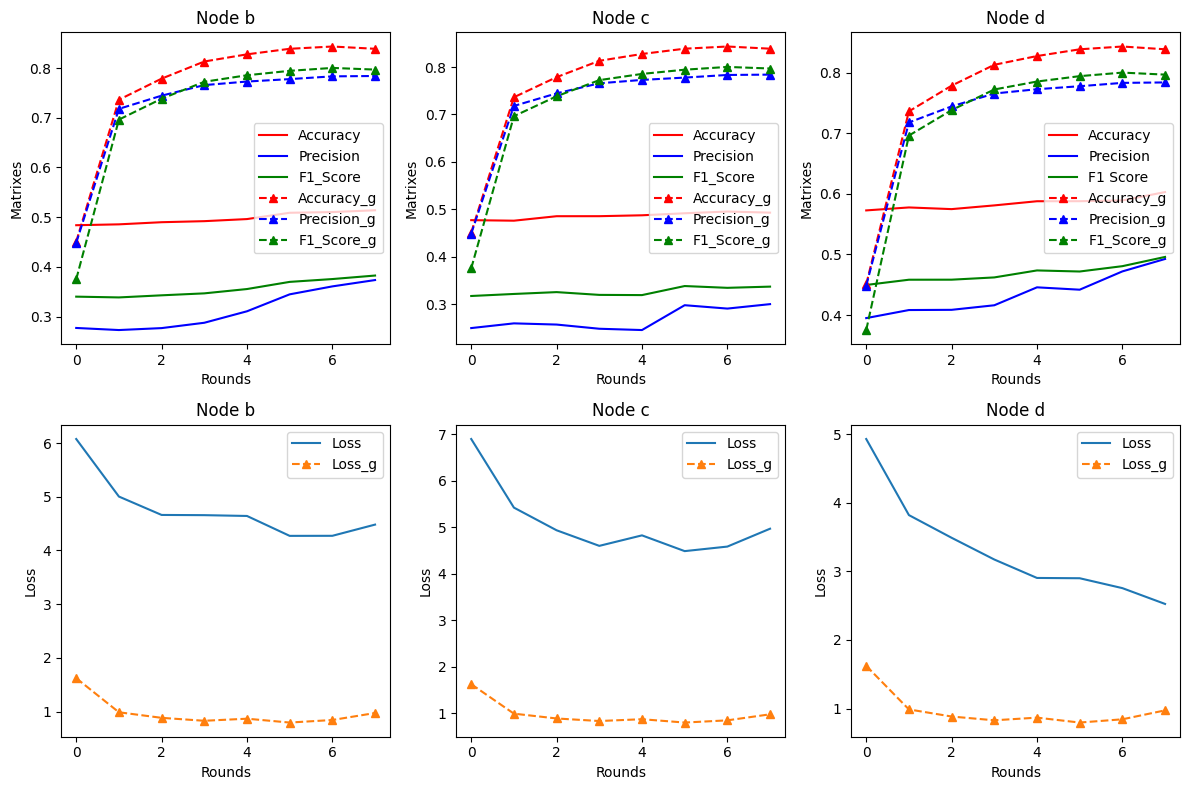

In [28]:
plot_result(a,b,c,d)


The above experiment is conducted under certain settings:
- 0. Aggregation Function: FedEP
- 1. Non-IID Scenario 2 (Normal)
- 2. Local training 3 epochs
- 3. Global training 8 Rounds(a round =  broadcast + train + aggregate)

## Comparison: FedAvg vs FedEP

In [30]:

def load_result(url,scenario):
    with open(url, "rb") as file:
        loaded_data = pickle.load(file)[scenario]
        return loaded_data


[FedAvg_a, FedAvg_b, FedAvg_c, FedAvg_d] = load_result("FedAvg_non_iid_s2.pkl","Scenario2")
[FedEP_a, FedEP_b, FedEP_c, FedEP_d] = load_result("FedEP_non_iid_s2.pkl","Scenario2")

In [38]:
FedAvg_a.eval_results

[[{'Test/Loss': 1.563139796257019,
   'Test/Accuracy': 0.5613463521003723,
   'Test/Precision': 0.3919159770011902,
   'Test/Recall': 0.5613463521003723,
   'Test/F1Score': 0.4414213299751282,
   'TestEpoch/Accuracy': 0.5631391406059265,
   'TestEpoch/Precision': 0.38805070519447327,
   'TestEpoch/Recall': 0.5631391406059265,
   'TestEpoch/F1Score': 0.446105420589447}],
 [{'Test/Loss': 1.3308686017990112,
   'Test/Accuracy': 0.593604564666748,
   'Test/Precision': 0.453457236289978,
   'Test/Recall': 0.593604564666748,
   'Test/F1Score': 0.47878652811050415,
   'TestEpoch/Accuracy': 0.5938124060630798,
   'TestEpoch/Precision': 0.5779540538787842,
   'TestEpoch/Recall': 0.5938124060630798,
   'TestEpoch/F1Score': 0.48523104190826416}],
 [{'Test/Loss': 1.3167617321014404,
   'Test/Accuracy': 0.6128993034362793,
   'Test/Precision': 0.5069701671600342,
   'Test/Recall': 0.6128993034362793,
   'Test/F1Score': 0.509787380695343,
   'TestEpoch/Accuracy': 0.6128161549568176,
   'TestEpoch/Pr

In [28]:

def plot_result_comapare(FedAvg_a, FedEP_a):
    # Extract the metrics for each node
    rounds = [i for i in range(len(FedAvg_a.eval_results))]
    FedAvg_loss = [result[0]['Test/Loss'] for result in FedAvg_a.eval_results]
    FedAvg_accuracy = [result[0]['Test/Accuracy'] for result in FedAvg_a.eval_results]
    FedAvg_precision = [result[0]['Test/Precision'] for result in FedAvg_a.eval_results]
    FedAvg_f1score = [result[0]['Test/F1Score'] for result in FedAvg_a.eval_results]

    FedEP_loss = [result[0]['Test/Loss'] for result in FedEP_a.eval_results]
    FedEP_accuracy = [result[0]['Test/Accuracy'] for result in FedEP_a.eval_results]
    FedEP_precision = [result[0]['Test/Precision'] for result in FedEP_a.eval_results]
    FedEP_f1score = [result[0]['Test/F1Score'] for result in FedEP_a.eval_results]


    # Create subplots for each metric
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    axs[0].plot(rounds, FedAvg_accuracy, label='FedAvg Accuracy',linestyle='--',marker='^',color='red')
    axs[0].plot(rounds, FedAvg_precision, label='FedAvg Precision',linestyle='--',marker='^',color='blue')
    axs[0].plot(rounds, FedAvg_f1score, label='FedAvg F1',linestyle='--',marker='^',color='green')
    axs[0].plot(rounds, FedEP_accuracy, label='FedEP Accuracy', linestyle='-',marker='o',color='red')
    axs[0].plot(rounds, FedEP_precision, label='FedEP Precision', linestyle='-',marker='o',color='blue')
    axs[0].plot(rounds, FedEP_f1score, label='FedEP F1', linestyle='-',marker='o',color='green')
    axs[0].set_xlabel('Rounds')
    axs[0].set_ylabel('Matrixes')
    axs[0].set_title('Accuracy, Precision, F1_Score')
    axs[0].legend()

    axs[1].plot(rounds, FedAvg_loss, label='FedAvg Loss',linestyle='--',marker='^',color='brown')
    axs[1].plot(rounds, FedEP_loss, label='FedEP Loss', linestyle='-',marker='o',color='brown')
    axs[1].set_xlabel('Rounds')
    axs[1].set_ylabel('Loss')
    axs[1].set_title('Loss')
    axs[1].legend()


    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plots
    plt.show()


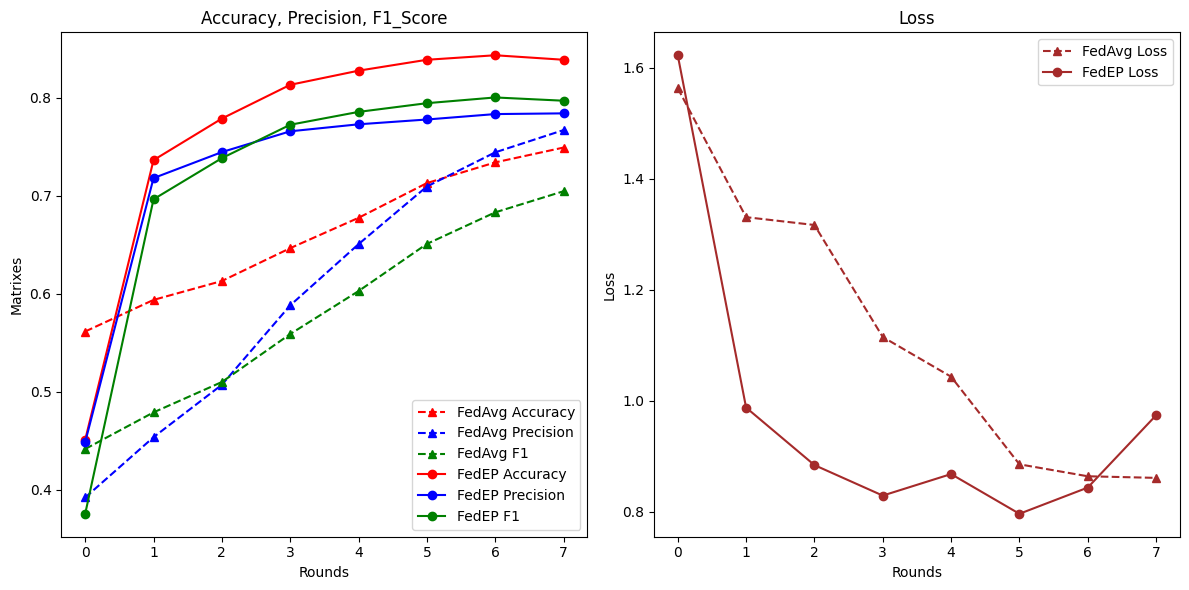

In [49]:
plot_result_comapare(FedAvg_a, FedEP_a)

The above experiment is conducted under certain settings:
- 1. Non-iid Scenario 2 (Normal)
- 2. Local training 3 epochs
- 3. 8 Rounds

To further check the result, now we run an experiment of 12 rounds and 2 epochs to compare the results:

In [16]:
# Aggregation: FedAvg
# Data Distribution: Scenario 2: Non-IID (Normal)
# Epochs = 2
# Rounds = 12

model_global = MNISTModelMLP()
model1 = MNISTModelMLP()
model2 = MNISTModelMLP()
model3 = MNISTModelMLP()

a = Server(model_global, test_set)
b = Client("node_b", model1, train_set1, test_set, Epochs=2)
c = Client("node_c", model2, train_set2, test_set, Epochs=2)
d = Client("node_d", model3, train_set3, test_set, Epochs=2)
a.add_client(b)
a.add_client(c)
a.add_client(d)

a.train(rounds=12)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] |

Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.44it/s, v_num=748, Train/Loss=0.043, Train/Accuracy=0.960, Train/Precision=0.989, Train/Recall=0.960, Train/F1Score=0.972, TrainEpoch/Accuracy=0.692, TrainEpoch/Precision=0.744, TrainEpoch/Recall=0.692, TrainEpoch/F1Score=0.714] Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.36it/s, v_num=748, Train/Loss=0.043, Train/Accuracy=0.960, Train/Precision=0.989, Train/Recall=0.960, Train/F1Score=0.972, TrainEpoch/Accuracy=0.692, TrainEpoch/Precision=0.744, TrainEpoch/Recall=0.692, TrainEpoch/F1Score=0.714]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.95it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4820723533630371     │
│       Test/F1Score        │    0.3390345871448517     │
│         Test/Loss         │     6.971428871154785     │
│      Test/Precision       │    0.2780372202396393     │
│        Test/Recall        │    0.4820723533630371     │
│    TestEpoch/Accuracy     │    0.4816867709159851     │
│     TestEpoch/F1Score     │    0.3400108814239502     │
│    TestEpoch/Precision    │    0.27234405279159546    │
│     TestEpoch/Recall      │    0.4816867709159851     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.40it/s, v_num=750, Train/Loss=0.254, Train/Accuracy=0.914, Train/Precision=0.871, Train/Recall=0.914, Train/F1Score=0.886, TrainEpoch/Accuracy=0.504, TrainEpoch/Precision=0.535, TrainEpoch/Recall=0.504, TrainEpoch/F1Score=0.517] Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, v_num=750, Train/Loss=0.254, Train/Accuracy=0.914, Train/Precision=0.871, Train/Recall=0.914, Train/F1Score=0.886, TrainEpoch/Accuracy=0.504, TrainEpoch/Precision=0.535, TrainEpoch/Recall=0.504, TrainEpoch/F1Score=0.517]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.69it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.47123876214027405    │
│       Test/F1Score        │    0.3233973979949951     │
│         Test/Loss         │     7.378396034240723     │
│      Test/Precision       │    0.2665743827819824     │
│        Test/Recall        │    0.47123876214027405    │
│    TestEpoch/Accuracy     │    0.4733157455921173     │
│     TestEpoch/F1Score     │    0.3270057737827301     │
│    TestEpoch/Precision    │    0.2639392018318176     │
│     TestEpoch/Recall      │    0.4733157455921173     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.85it/s, v_num=752, Train/Loss=0.105, Train/Accuracy=0.972, Train/Precision=0.979, Train/Recall=0.972, Train/F1Score=0.974, TrainEpoch/Accuracy=0.748, TrainEpoch/Precision=0.845, TrainEpoch/Recall=0.748, TrainEpoch/F1Score=0.783] Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.78it/s, v_num=752, Train/Loss=0.105, Train/Accuracy=0.972, Train/Precision=0.979, Train/Recall=0.972, Train/F1Score=0.974, TrainEpoch/Accuracy=0.748, TrainEpoch/Precision=0.845, TrainEpoch/Recall=0.748, TrainEpoch/F1Score=0.783]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.62it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5623944401741028     │
│       Test/F1Score        │     0.448376327753067     │
│         Test/Loss         │     5.573604106903076     │
│      Test/Precision       │    0.40392789244651794    │
│        Test/Recall        │    0.5623944401741028     │
│    TestEpoch/Accuracy     │    0.5629726648330688     │
│     TestEpoch/F1Score     │    0.4517890214920044     │
│    TestEpoch/Precision    │     0.400974303483963     │
│     TestEpoch/Recall      │    0.5629726648330688     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.91it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5532362461090088     │
│       Test/F1Score        │    0.43271663784980774    │
│         Test/Loss         │     1.89024019241333      │
│      Test/Precision       │    0.3839055299758911     │
│        Test/Recall        │    0.5532362461090088     │
│    TestEpoch/Accuracy     │    0.5553662776947021     │
│     TestEpoch/F1Score     │    0.4384206235408783     │
│    TestEpoch/Precision    │    0.3819713592529297     │
│     TestEpoch/Recall      │    0.5553662776947021     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 1 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.06it/s, v_num=755, Train/Loss=0.0962, Train/Accuracy=0.987, Train/Precision=0.933, Train/Recall=0.987, Train/F1Score=0.953, TrainEpoch/Accuracy=0.792, TrainEpoch/Precision=0.793, TrainEpoch/Recall=0.792, TrainEpoch/F1Score=0.792] Epoch end: Train, epoch number: 3


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.98it/s, v_num=755, Train/Loss=0.0962, Train/Accuracy=0.987, Train/Precision=0.933, Train/Recall=0.987, Train/F1Score=0.953, TrainEpoch/Accuracy=0.792, TrainEpoch/Precision=0.793, TrainEpoch/Recall=0.792, TrainEpoch/F1Score=0.792]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.87it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4852272868156433     │
│       Test/F1Score        │    0.3405442237854004     │
│         Test/Loss         │     5.522983551025391     │
│      Test/Precision       │    0.2780607044696808     │
│        Test/Recall        │    0.4852272868156433     │
│    TestEpoch/Accuracy     │    0.48517653346061707    │
│     TestEpoch/F1Score     │    0.34132903814315796    │
│    TestEpoch/Precision    │    0.2726232409477234     │
│     TestEpoch/Recall      │    0.48517653346061707    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.30it/s, v_num=757, Train/Loss=0.0541, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.506, TrainEpoch/Precision=0.518, TrainEpoch/Recall=0.506, TrainEpoch/F1Score=0.512]Epoch end: Train, epoch number: 3


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.12it/s, v_num=757, Train/Loss=0.0541, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.506, TrainEpoch/Precision=0.518, TrainEpoch/Recall=0.506, TrainEpoch/F1Score=0.512]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.55it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.47619467973709106    │
│       Test/F1Score        │    0.3266772925853729     │
│         Test/Loss         │     6.078180313110352     │
│      Test/Precision       │    0.2651887536048889     │
│        Test/Recall        │    0.47619467973709106    │
│    TestEpoch/Accuracy     │     0.477235347032547     │
│     TestEpoch/F1Score     │    0.32972437143325806    │
│    TestEpoch/Precision    │    0.26104578375816345    │
│     TestEpoch/Recall      │     0.477235347032547     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.21it/s, v_num=759, Train/Loss=0.122, Train/Accuracy=0.968, Train/Precision=0.961, Train/Recall=0.968, Train/F1Score=0.964, TrainEpoch/Accuracy=0.785, TrainEpoch/Precision=0.791, TrainEpoch/Recall=0.785, TrainEpoch/F1Score=0.788] Epoch end: Train, epoch number: 3


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.13it/s, v_num=759, Train/Loss=0.122, Train/Accuracy=0.968, Train/Precision=0.961, Train/Recall=0.968, Train/F1Score=0.964, TrainEpoch/Accuracy=0.785, TrainEpoch/Precision=0.791, TrainEpoch/Recall=0.785, TrainEpoch/F1Score=0.788]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.12it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5698251724243164     │
│       Test/F1Score        │    0.45098236203193665    │
│         Test/Loss         │     4.248297691345215     │
│      Test/Precision       │    0.3988123834133148     │
│        Test/Recall        │    0.5698251724243164     │
│    TestEpoch/Accuracy     │    0.5711274147033691     │
│     TestEpoch/F1Score     │    0.45426619052886963    │
│    TestEpoch/Precision    │     0.395111083984375     │
│     TestEpoch/Recall      │    0.5711274147033691     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:11<00:00, 14.23it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5625849366188049     │
│       Test/F1Score        │    0.43837445974349976    │
│         Test/Loss         │     1.608371376991272     │
│      Test/Precision       │    0.3804371654987335     │
│        Test/Recall        │    0.5625849366188049     │
│    TestEpoch/Accuracy     │    0.5641884803771973     │
│     TestEpoch/F1Score     │    0.44156312942504883    │
│    TestEpoch/Precision    │    0.5715328454971313     │
│     TestEpoch/Recall      │    0.5641884803771973     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 2 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.81it/s, v_num=761, Train/Loss=0.0334, Train/Accuracy=0.990, Train/Precision=0.983, Train/Recall=0.990, Train/F1Score=0.986, TrainEpoch/Accuracy=0.966, TrainEpoch/Precision=0.968, TrainEpoch/Recall=0.966, TrainEpoch/F1Score=0.967] Epoch end: Train, epoch number: 5


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.73it/s, v_num=761, Train/Loss=0.0334, Train/Accuracy=0.990, Train/Precision=0.983, Train/Recall=0.990, Train/F1Score=0.986, TrainEpoch/Accuracy=0.966, TrainEpoch/Precision=0.968, TrainEpoch/Recall=0.966, TrainEpoch/F1Score=0.967]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.93it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4877094328403473     │
│       Test/F1Score        │    0.34188416600227356    │
│         Test/Loss         │     5.079782485961914     │
│      Test/Precision       │    0.27796074748039246    │
│        Test/Recall        │    0.4877094328403473     │
│    TestEpoch/Accuracy     │    0.48758476972579956    │
│     TestEpoch/F1Score     │     0.342244952917099     │
│    TestEpoch/Precision    │    0.27169597148895264    │
│     TestEpoch/Recall      │    0.48758476972579956    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.89it/s, v_num=763, Train/Loss=0.0576, Train/Accuracy=0.980, Train/Precision=0.960, Train/Recall=0.980, Train/F1Score=0.967, TrainEpoch/Accuracy=0.519, TrainEpoch/Precision=0.528, TrainEpoch/Recall=0.519, TrainEpoch/F1Score=0.524]Epoch end: Train, epoch number: 5


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.81it/s, v_num=763, Train/Loss=0.0576, Train/Accuracy=0.980, Train/Precision=0.960, Train/Recall=0.980, Train/F1Score=0.967, TrainEpoch/Accuracy=0.519, TrainEpoch/Precision=0.528, TrainEpoch/Recall=0.519, TrainEpoch/F1Score=0.524]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.37it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4807003438472748     │
│       Test/F1Score        │    0.32343223690986633    │
│         Test/Loss         │    5.5362443923950195     │
│      Test/Precision       │    0.25696608424186707    │
│        Test/Recall        │    0.4807003438472748     │
│    TestEpoch/Accuracy     │    0.4822595417499542     │
│     TestEpoch/F1Score     │    0.32641828060150146    │
│    TestEpoch/Precision    │    0.25315025448799133    │
│     TestEpoch/Recall      │    0.4822595417499542     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.09it/s, v_num=765, Train/Loss=0.117, Train/Accuracy=0.984, Train/Precision=0.965, Train/Recall=0.984, Train/F1Score=0.973, TrainEpoch/Accuracy=0.803, TrainEpoch/Precision=0.808, TrainEpoch/Recall=0.803, TrainEpoch/F1Score=0.805] Epoch end: Train, epoch number: 5


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, v_num=765, Train/Loss=0.117, Train/Accuracy=0.984, Train/Precision=0.965, Train/Recall=0.984, Train/F1Score=0.973, TrainEpoch/Accuracy=0.803, TrainEpoch/Precision=0.808, TrainEpoch/Recall=0.803, TrainEpoch/F1Score=0.805]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.97it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5737202167510986     │
│       Test/F1Score        │    0.45611175894737244    │
│         Test/Loss         │     4.000258922576904     │
│      Test/Precision       │    0.4090525507926941     │
│        Test/Recall        │    0.5737202167510986     │
│    TestEpoch/Accuracy     │     0.574764609336853     │
│     TestEpoch/F1Score     │    0.4603577256202698     │
│    TestEpoch/Precision    │     0.507384181022644     │
│     TestEpoch/Recall      │     0.574764609336853     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.42it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.576323390007019     │
│       Test/F1Score        │    0.45569556951522827    │
│         Test/Loss         │    1.4202122688293457     │
│      Test/Precision       │    0.41422340273857117    │
│        Test/Recall        │     0.576323390007019     │
│    TestEpoch/Accuracy     │    0.5775288939476013     │
│     TestEpoch/F1Score     │    0.4597970247268677     │
│    TestEpoch/Precision    │    0.7749180793762207     │
│     TestEpoch/Recall      │    0.5775288939476013     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 3 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.14it/s, v_num=767, Train/Loss=0.0112, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.811, TrainEpoch/Precision=0.811, TrainEpoch/Recall=0.811, TrainEpoch/F1Score=0.811] Epoch end: Train, epoch number: 7


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.05it/s, v_num=767, Train/Loss=0.0112, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.811, TrainEpoch/Precision=0.811, TrainEpoch/Recall=0.811, TrainEpoch/F1Score=0.811]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.62it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.48808902502059937    │
│       Test/F1Score        │    0.34380435943603516    │
│         Test/Loss         │     5.479223251342773     │
│      Test/Precision       │    0.2829909026622772     │
│        Test/Recall        │    0.48808902502059937    │
│    TestEpoch/Accuracy     │    0.48812898993492126    │
│     TestEpoch/F1Score     │    0.34437936544418335    │
│    TestEpoch/Precision    │     0.277249813079834     │
│     TestEpoch/Recall      │    0.48812898993492126    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.12it/s, v_num=769, Train/Loss=0.0303, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.525, TrainEpoch/Precision=0.530, TrainEpoch/Recall=0.525, TrainEpoch/F1Score=0.527] Epoch end: Train, epoch number: 7


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.02it/s, v_num=769, Train/Loss=0.0303, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.525, TrainEpoch/Precision=0.530, TrainEpoch/Recall=0.525, TrainEpoch/F1Score=0.527]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.98it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4826951026916504     │
│       Test/F1Score        │    0.32821565866470337    │
│         Test/Loss         │    4.8813252449035645     │
│      Test/Precision       │     0.264117568731308     │
│        Test/Recall        │    0.4826951026916504     │
│    TestEpoch/Accuracy     │    0.48401305079460144    │
│     TestEpoch/F1Score     │    0.3311755061149597     │
│    TestEpoch/Precision    │    0.26025527715682983    │
│     TestEpoch/Recall      │    0.48401305079460144    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.15it/s, v_num=771, Train/Loss=0.0862, Train/Accuracy=0.967, Train/Precision=0.990, Train/Recall=0.967, Train/F1Score=0.976, TrainEpoch/Accuracy=0.812, TrainEpoch/Precision=0.815, TrainEpoch/Recall=0.812, TrainEpoch/F1Score=0.813]Epoch end: Train, epoch number: 7


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.02it/s, v_num=771, Train/Loss=0.0862, Train/Accuracy=0.967, Train/Precision=0.990, Train/Recall=0.967, Train/F1Score=0.976, TrainEpoch/Accuracy=0.812, TrainEpoch/Precision=0.815, TrainEpoch/Recall=0.812, TrainEpoch/F1Score=0.813]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.53it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.577267587184906     │
│       Test/F1Score        │    0.4548814594745636     │
│         Test/Loss         │     3.630962610244751     │
│      Test/Precision       │    0.4011457860469818     │
│        Test/Recall        │     0.577267587184906     │
│    TestEpoch/Accuracy     │    0.5788235664367676     │
│     TestEpoch/F1Score     │    0.4585610032081604     │
│    TestEpoch/Precision    │    0.4964773654937744     │
│     TestEpoch/Recall      │    0.5788235664367676     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.74it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5901011824607849     │
│       Test/F1Score        │    0.4742385149002075     │
│         Test/Loss         │    1.3231838941574097     │
│      Test/Precision       │    0.45110395550727844    │
│        Test/Recall        │    0.5901011824607849     │
│    TestEpoch/Accuracy     │    0.5899387001991272     │
│     TestEpoch/F1Score     │    0.47894376516342163    │
│    TestEpoch/Precision    │    0.7833149433135986     │
│     TestEpoch/Recall      │    0.5899387001991272     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 4 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, v_num=773, Train/Loss=0.0119, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.819, TrainEpoch/Precision=0.819, TrainEpoch/Recall=0.819, TrainEpoch/F1Score=0.819] Epoch end: Train, epoch number: 9


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.24it/s, v_num=773, Train/Loss=0.0119, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.819, TrainEpoch/Precision=0.819, TrainEpoch/Recall=0.819, TrainEpoch/F1Score=0.819]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.00it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4900669455528259     │
│       Test/F1Score        │    0.3449344038963318     │
│         Test/Loss         │     5.182448863983154     │
│      Test/Precision       │    0.2872948944568634     │
│        Test/Recall        │    0.4900669455528259     │
│    TestEpoch/Accuracy     │    0.49027538299560547    │
│     TestEpoch/F1Score     │    0.34658363461494446    │
│    TestEpoch/Precision    │    0.37759965658187866    │
│     TestEpoch/Recall      │    0.49027538299560547    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.07it/s, v_num=775, Train/Loss=0.0201, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.528, TrainEpoch/Precision=0.536, TrainEpoch/Recall=0.528, TrainEpoch/F1Score=0.532]Epoch end: Train, epoch number: 9


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.98it/s, v_num=775, Train/Loss=0.0201, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.528, TrainEpoch/Precision=0.536, TrainEpoch/Recall=0.528, TrainEpoch/F1Score=0.532]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.04it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4798729419708252     │
│       Test/F1Score        │    0.3312360644340515     │
│         Test/Loss         │     5.416891574859619     │
│      Test/Precision       │    0.27246516942977905    │
│        Test/Recall        │    0.4798729419708252     │
│    TestEpoch/Accuracy     │    0.48125705122947693    │
│     TestEpoch/F1Score     │    0.3344002962112427     │
│    TestEpoch/Precision    │    0.26890134811401367    │
│     TestEpoch/Recall      │    0.48125705122947693    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.22it/s, v_num=777, Train/Loss=0.0197, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.818, TrainEpoch/Precision=0.822, TrainEpoch/Recall=0.818, TrainEpoch/F1Score=0.820]Epoch end: Train, epoch number: 9


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.12it/s, v_num=777, Train/Loss=0.0197, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.818, TrainEpoch/Precision=0.822, TrainEpoch/Recall=0.818, TrainEpoch/F1Score=0.820]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.59it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5760958194732666     │
│       Test/F1Score        │    0.4545154869556427     │
│         Test/Loss         │     3.686875820159912     │
│      Test/Precision       │    0.4050583243370056     │
│        Test/Recall        │    0.5760958194732666     │
│    TestEpoch/Accuracy     │    0.5775067806243896     │
│     TestEpoch/F1Score     │    0.4582589566707611     │
│    TestEpoch/Precision    │    0.49753308296203613    │
│     TestEpoch/Recall      │    0.5775067806243896     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.36it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.6024999022483826     │
│       Test/F1Score        │    0.49469229578971863    │
│         Test/Loss         │    1.2403442859649658     │
│      Test/Precision       │    0.4957273006439209     │
│        Test/Recall        │    0.6024999022483826     │
│    TestEpoch/Accuracy     │    0.6017577052116394     │
│     TestEpoch/F1Score     │    0.5013091564178467     │
│    TestEpoch/Precision    │    0.7904711961746216     │
│     TestEpoch/Recall      │    0.6017577052116394     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 5 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.51it/s, v_num=779, Train/Loss=0.00522, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.822, TrainEpoch/Precision=0.823, TrainEpoch/Recall=0.822, TrainEpoch/F1Score=0.823] Epoch end: Train, epoch number: 11


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.40it/s, v_num=779, Train/Loss=0.00522, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.822, TrainEpoch/Precision=0.823, TrainEpoch/Recall=0.822, TrainEpoch/F1Score=0.823]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:11<00:00, 13.35it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.49178656935691833    │
│       Test/F1Score        │    0.3463226556777954     │
│         Test/Loss         │     5.234922885894775     │
│      Test/Precision       │    0.29456189274787903    │
│        Test/Recall        │    0.49178656935691833    │
│    TestEpoch/Accuracy     │     0.491771399974823     │
│     TestEpoch/F1Score     │    0.3478662371635437     │
│    TestEpoch/Precision    │    0.3731742799282074     │
│     TestEpoch/Recall      │     0.491771399974823     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:10<00:00,  8.66it/s, v_num=781, Train/Loss=0.0412, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.531, TrainEpoch/Precision=0.540, TrainEpoch/Recall=0.531, TrainEpoch/F1Score=0.536] Epoch end: Train, epoch number: 11


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:11<00:00,  8.53it/s, v_num=781, Train/Loss=0.0412, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.531, TrainEpoch/Precision=0.540, TrainEpoch/Recall=0.531, TrainEpoch/F1Score=0.536]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.78it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.48529052734375      │
│       Test/F1Score        │    0.32109102606773376    │
│         Test/Loss         │     4.928208827972412     │
│      Test/Precision       │    0.2504070997238159     │
│        Test/Recall        │     0.48529052734375      │
│    TestEpoch/Accuracy     │    0.48648619651794434    │
│     TestEpoch/F1Score     │    0.3229992389678955     │
│    TestEpoch/Precision    │    0.3441934883594513     │
│     TestEpoch/Recall      │    0.48648619651794434    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, v_num=783, Train/Loss=0.00981, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.826, TrainEpoch/Precision=0.828, TrainEpoch/Recall=0.826, TrainEpoch/F1Score=0.827]Epoch end: Train, epoch number: 11


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.95it/s, v_num=783, Train/Loss=0.00981, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.826, TrainEpoch/Precision=0.828, TrainEpoch/Recall=0.826, TrainEpoch/F1Score=0.827]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.03it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5911412835121155     │
│       Test/F1Score        │    0.47509467601776123    │
│         Test/Loss         │    3.4570140838623047     │
│      Test/Precision       │    0.4478502869606018     │
│        Test/Recall        │    0.5911412835121155     │
│    TestEpoch/Accuracy     │    0.5929204821586609     │
│     TestEpoch/F1Score     │    0.48177698254585266    │
│    TestEpoch/Precision    │    0.4976377487182617     │
│     TestEpoch/Recall      │    0.5929204821586609     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.96it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.6301232576370239     │
│       Test/F1Score        │    0.5374500751495361     │
│         Test/Loss         │     1.109697937965393     │
│      Test/Precision       │    0.5738779902458191     │
│        Test/Recall        │    0.6301232576370239     │
│    TestEpoch/Accuracy     │    0.6295034289360046     │
│     TestEpoch/F1Score     │    0.5483063459396362     │
│    TestEpoch/Precision    │    0.7951356768608093     │
│     TestEpoch/Recall      │    0.6295034289360046     │
└───────────────────────────┴───────────────────────────┘

Evaluating at Server finished
Round 6 finished


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.42it/s, v_num=785, Train/Loss=0.0147, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.823, TrainEpoch/Precision=0.824, TrainEpoch/Recall=0.823, TrainEpoch/F1Score=0.824] Epoch end: Train, epoch number: 13


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.34it/s, v_num=785, Train/Loss=0.0147, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.823, TrainEpoch/Precision=0.824, TrainEpoch/Recall=0.823, TrainEpoch/F1Score=0.824]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.09it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.49393990635871887    │
│       Test/F1Score        │    0.35414519906044006    │
│         Test/Loss         │     5.040563106536865     │
│      Test/Precision       │    0.3128565549850464     │
│        Test/Recall        │    0.49393990635871887    │
│    TestEpoch/Accuracy     │    0.49473249912261963    │
│     TestEpoch/F1Score     │    0.3568101227283478     │
│    TestEpoch/Precision    │    0.3731386363506317     │
│     TestEpoch/Recall      │    0.49473249912261963    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:08<00:00, 10.49it/s, v_num=787, Train/Loss=0.0279, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.536, TrainEpoch/Precision=0.542, TrainEpoch/Recall=0.536, TrainEpoch/F1Score=0.539] Epoch end: Train, epoch number: 13


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.41it/s, v_num=787, Train/Loss=0.0279, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.536, TrainEpoch/Precision=0.542, TrainEpoch/Recall=0.536, TrainEpoch/F1Score=0.539]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.17it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.487537145614624     │
│       Test/F1Score        │    0.3263513743877411     │
│         Test/Loss         │     4.516475200653076     │
│      Test/Precision       │    0.26418304443359375    │
│        Test/Recall        │     0.487537145614624     │
│    TestEpoch/Accuracy     │    0.48862457275390625    │
│     TestEpoch/F1Score     │    0.3289794325828552     │
│    TestEpoch/Precision    │    0.44644954800605774    │
│     TestEpoch/Recall      │    0.48862457275390625    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.31it/s, v_num=789, Train/Loss=0.0158, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.831, TrainEpoch/Precision=0.831, TrainEpoch/Recall=0.831, TrainEpoch/F1Score=0.831] Epoch end: Train, epoch number: 13


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.23it/s, v_num=789, Train/Loss=0.0158, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.831, TrainEpoch/Precision=0.831, TrainEpoch/Recall=0.831, TrainEpoch/F1Score=0.831]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.12it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5921396017074585     │
│       Test/F1Score        │    0.4751284718513489     │
│         Test/Loss         │    3.3010993003845215     │
│      Test/Precision       │    0.4454386830329895     │
│        Test/Recall        │    0.5921396017074585     │
│    TestEpoch/Accuracy     │     0.593860924243927     │
│     TestEpoch/F1Score     │    0.48115599155426025    │
│    TestEpoch/Precision    │    0.49829789996147156    │
│     TestEpoch/Recall      │     0.593860924243927     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.07it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.6756476759910583     │
│       Test/F1Score        │    0.6086550354957581     │
│         Test/Loss         │    0.9164865016937256     │
│      Test/Precision       │    0.6907158493995667     │
│        Test/Recall        │    0.6756476759910583     │
│    TestEpoch/Accuracy     │    0.6759557127952576     │
│     TestEpoch/F1Score     │    0.6257525086402893     │
│    TestEpoch/Precision    │    0.8092069029808044     │
│     TestEpoch/Recall      │    0.6759557127952576     │
└───────────────────────────┴───────────────────────────┘

Evaluating at Server finished
Round 7 finished


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.38it/s, v_num=791, Train/Loss=0.00108, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.825, TrainEpoch/Precision=0.825, TrainEpoch/Recall=0.825, TrainEpoch/F1Score=0.825] Epoch end: Train, epoch number: 15


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.30it/s, v_num=791, Train/Loss=0.00108, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.825, TrainEpoch/Precision=0.825, TrainEpoch/Recall=0.825, TrainEpoch/F1Score=0.825]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.81it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.49177148938179016    │
│       Test/F1Score        │    0.3469949960708618     │
│         Test/Loss         │     5.161715030670166     │
│      Test/Precision       │    0.2953019142150879     │
│        Test/Recall        │    0.49177148938179016    │
│    TestEpoch/Accuracy     │    0.4918513894081116     │
│     TestEpoch/F1Score     │    0.3488911986351013     │
│    TestEpoch/Precision    │    0.3742201328277588     │
│     TestEpoch/Recall      │    0.4918513894081116     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.27it/s, v_num=793, Train/Loss=0.172, Train/Accuracy=0.987, Train/Precision=0.975, Train/Recall=0.987, Train/F1Score=0.980, TrainEpoch/Accuracy=0.485, TrainEpoch/Precision=0.490, TrainEpoch/Recall=0.485, TrainEpoch/F1Score=0.487]  Epoch end: Train, epoch number: 15


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.19it/s, v_num=793, Train/Loss=0.172, Train/Accuracy=0.987, Train/Precision=0.975, Train/Recall=0.987, Train/F1Score=0.980, TrainEpoch/Accuracy=0.485, TrainEpoch/Precision=0.490, TrainEpoch/Recall=0.485, TrainEpoch/F1Score=0.487]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.87it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4868099093437195     │
│       Test/F1Score        │    0.3258092999458313     │
│         Test/Loss         │    4.3218560218811035     │
│      Test/Precision       │    0.2737191319465637     │
│        Test/Recall        │    0.4868099093437195     │
│    TestEpoch/Accuracy     │    0.4875117838382721     │
│     TestEpoch/F1Score     │    0.3292994201183319     │
│    TestEpoch/Precision    │    0.4419505000114441     │
│     TestEpoch/Recall      │    0.4875117838382721     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.00it/s, v_num=795, Train/Loss=0.00844, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.835, TrainEpoch/Precision=0.834, TrainEpoch/Recall=0.835, TrainEpoch/F1Score=0.834]Epoch end: Train, epoch number: 15


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.92it/s, v_num=795, Train/Loss=0.00844, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.835, TrainEpoch/Precision=0.834, TrainEpoch/Recall=0.835, TrainEpoch/F1Score=0.834]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.05it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5872007608413696     │
│       Test/F1Score        │    0.47212812304496765    │
│         Test/Loss         │     3.91849684715271      │
│      Test/Precision       │     0.441410094499588     │
│        Test/Recall        │    0.5872007608413696     │
│    TestEpoch/Accuracy     │    0.5883662700653076     │
│     TestEpoch/F1Score     │     0.476918488740921     │
│    TestEpoch/Precision    │    0.5064685940742493     │
│     TestEpoch/Recall      │    0.5883662700653076     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.11it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.7112298607826233     │
│       Test/F1Score        │    0.6558887958526611     │
│         Test/Loss         │     0.861491322517395     │
│      Test/Precision       │    0.7246906757354736     │
│        Test/Recall        │    0.7112298607826233     │
│    TestEpoch/Accuracy     │    0.7103840112686157     │
│     TestEpoch/F1Score     │    0.6724064946174622     │
│    TestEpoch/Precision    │    0.8269703388214111     │
│     TestEpoch/Recall      │    0.7103840112686157     │
└───────────────────────────┴───────────────────────────┘

Evaluating at Server finished
Round 8 finished


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.98it/s, v_num=797, Train/Loss=0.00396, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.827, TrainEpoch/Precision=0.827, TrainEpoch/Recall=0.827, TrainEpoch/F1Score=0.827] Epoch end: Train, epoch number: 17


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.91it/s, v_num=797, Train/Loss=0.00396, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.827, TrainEpoch/Precision=0.827, TrainEpoch/Recall=0.827, TrainEpoch/F1Score=0.827]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.21it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4936904311180115     │
│       Test/F1Score        │    0.3491680920124054     │
│         Test/Loss         │     5.070014953613281     │
│      Test/Precision       │    0.3007628321647644     │
│        Test/Recall        │    0.4936904311180115     │
│    TestEpoch/Accuracy     │     0.493632972240448     │
│     TestEpoch/F1Score     │    0.35078778862953186    │
│    TestEpoch/Precision    │    0.37485724687576294    │
│     TestEpoch/Recall      │     0.493632972240448     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.40it/s, v_num=799, Train/Loss=0.0743, Train/Accuracy=0.960, Train/Precision=0.987, Train/Recall=0.960, Train/F1Score=0.971, TrainEpoch/Accuracy=0.543, TrainEpoch/Precision=0.548, TrainEpoch/Recall=0.543, TrainEpoch/F1Score=0.546] Epoch end: Train, epoch number: 17


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.32it/s, v_num=799, Train/Loss=0.0743, Train/Accuracy=0.960, Train/Precision=0.987, Train/Recall=0.960, Train/F1Score=0.971, TrainEpoch/Accuracy=0.543, TrainEpoch/Precision=0.548, TrainEpoch/Recall=0.543, TrainEpoch/F1Score=0.546]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.22it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4834774434566498     │
│       Test/F1Score        │    0.3290783166885376     │
│         Test/Loss         │     4.686620235443115     │
│      Test/Precision       │    0.27519160509109497    │
│        Test/Recall        │    0.4834774434566498     │
│    TestEpoch/Accuracy     │     0.484503835439682     │
│     TestEpoch/F1Score     │     0.332030713558197     │
│    TestEpoch/Precision    │    0.4562475085258484     │
│     TestEpoch/Recall      │     0.484503835439682     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:08<00:00, 10.47it/s, v_num=801, Train/Loss=0.0742, Train/Accuracy=0.990, Train/Precision=0.981, Train/Recall=0.990, Train/F1Score=0.985, TrainEpoch/Accuracy=0.736, TrainEpoch/Precision=0.735, TrainEpoch/Recall=0.736, TrainEpoch/F1Score=0.735] Epoch end: Train, epoch number: 17


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.39it/s, v_num=801, Train/Loss=0.0742, Train/Accuracy=0.990, Train/Precision=0.981, Train/Recall=0.990, Train/F1Score=0.985, TrainEpoch/Accuracy=0.736, TrainEpoch/Precision=0.735, TrainEpoch/Recall=0.736, TrainEpoch/F1Score=0.735]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.26it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5946868062019348     │
│       Test/F1Score        │    0.4842498004436493     │
│         Test/Loss         │     3.673692464828491     │
│      Test/Precision       │    0.4697536528110504     │
│        Test/Recall        │    0.5946868062019348     │
│    TestEpoch/Accuracy     │    0.5962564945220947     │
│     TestEpoch/F1Score     │    0.4906464219093323     │
│    TestEpoch/Precision    │    0.5039788484573364     │
│     TestEpoch/Recall      │    0.5962564945220947     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.22it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.7403115630149841     │
│       Test/F1Score        │    0.6985428929328918     │
│         Test/Loss         │    0.7971338033676147     │
│      Test/Precision       │    0.7817326188087463     │
│        Test/Recall        │    0.7403115630149841     │
│    TestEpoch/Accuracy     │    0.7405186891555786     │
│     TestEpoch/F1Score     │    0.7155252695083618     │
│    TestEpoch/Precision    │    0.8362314701080322     │
│     TestEpoch/Recall      │    0.7405186891555786     │
└───────────────────────────┴───────────────────────────┘

Evaluating at Server finished
Round 9 finished
Training at node_b:


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.57it/s, v_num=803, Train/Loss=0.00542, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.993, TrainEpoch/Precision=0.993, TrainEpoch/Recall=0.993, TrainEpoch/F1Score=0.993] Epoch end: Train, epoch number: 19


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.49it/s, v_num=803, Train/Loss=0.00542, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.993, TrainEpoch/Precision=0.993, TrainEpoch/Recall=0.993, TrainEpoch/F1Score=0.993]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:11<00:00, 13.60it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4977189600467682     │
│       Test/F1Score        │    0.35976260900497437    │
│         Test/Loss         │     5.154890060424805     │
│      Test/Precision       │    0.32440975308418274    │
│        Test/Recall        │    0.4977189600467682     │
│    TestEpoch/Accuracy     │    0.49762704968452454    │
│     TestEpoch/F1Score     │    0.3630397915840149     │
│    TestEpoch/Precision    │    0.3802306056022644     │
│     TestEpoch/Recall      │    0.49762704968452454    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:10<00:00,  9.29it/s, v_num=805, Train/Loss=0.000556, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.492, TrainEpoch/Precision=0.495, TrainEpoch/Recall=0.492, TrainEpoch/F1Score=0.493]Epoch end: Train, epoch number: 19


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:10<00:00,  9.20it/s, v_num=805, Train/Loss=0.000556, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.492, TrainEpoch/Precision=0.495, TrainEpoch/Recall=0.492, TrainEpoch/F1Score=0.493]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:12<00:00, 12.87it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4932006001472473     │
│       Test/F1Score        │    0.3381688892841339     │
│         Test/Loss         │     4.468662261962891     │
│      Test/Precision       │    0.30187103152275085    │
│        Test/Recall        │    0.4932006001472473     │
│    TestEpoch/Accuracy     │    0.49499639868736267    │
│     TestEpoch/F1Score     │    0.34373483061790466    │
│    TestEpoch/Precision    │    0.5477817058563232     │
│     TestEpoch/Recall      │    0.49499639868736267    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:10<00:00,  9.15it/s, v_num=807, Train/Loss=0.0425, Train/Accuracy=0.968, Train/Precision=0.973, Train/Recall=0.968, Train/F1Score=0.970, TrainEpoch/Accuracy=0.841, TrainEpoch/Precision=0.843, TrainEpoch/Recall=0.841, TrainEpoch/F1Score=0.842] Epoch end: Train, epoch number: 19


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:10<00:00,  9.06it/s, v_num=807, Train/Loss=0.0425, Train/Accuracy=0.968, Train/Precision=0.973, Train/Recall=0.968, Train/F1Score=0.970, TrainEpoch/Accuracy=0.841, TrainEpoch/Precision=0.843, TrainEpoch/Recall=0.841, TrainEpoch/F1Score=0.842]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:12<00:00, 12.89it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5902061462402344     │
│       Test/F1Score        │    0.47402334213256836    │
│         Test/Loss         │     3.712759017944336     │
│      Test/Precision       │    0.44160252809524536    │
│        Test/Recall        │    0.5902061462402344     │
│    TestEpoch/Accuracy     │    0.5914085507392883     │
│     TestEpoch/F1Score     │    0.4790312945842743     │
│    TestEpoch/Precision    │    0.5066508650779724     │
│     TestEpoch/Recall      │    0.5914085507392883     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:11<00:00, 13.36it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.752538800239563     │
│       Test/F1Score        │    0.7147718071937561     │
│         Test/Loss         │    0.7539099454879761     │
│      Test/Precision       │    0.8020185232162476     │
│        Test/Recall        │     0.752538800239563     │
│    TestEpoch/Accuracy     │    0.7521867156028748     │
│     TestEpoch/F1Score     │    0.7323368787765503     │
│    TestEpoch/Precision    │    0.8401593565940857     │
│     TestEpoch/Recall      │    0.7521867156028748     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 10 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:11<00:00,  8.49it/s, v_num=809, Train/Loss=0.00134, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.829, TrainEpoch/Precision=0.829, TrainEpoch/Recall=0.829, TrainEpoch/F1Score=0.829] Epoch end: Train, epoch number: 21


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:11<00:00,  8.43it/s, v_num=809, Train/Loss=0.00134, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.829, TrainEpoch/Precision=0.829, TrainEpoch/Recall=0.829, TrainEpoch/F1Score=0.829]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:11<00:00, 13.74it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4960419833660126     │
│       Test/F1Score        │    0.3526241183280945     │
│         Test/Loss         │     4.730990409851074     │
│      Test/Precision       │    0.30479636788368225    │
│        Test/Recall        │    0.4960419833660126     │
│    TestEpoch/Accuracy     │    0.49597418308258057    │
│     TestEpoch/F1Score     │    0.3543531894683838     │
│    TestEpoch/Precision    │    0.4767921268939972     │
│     TestEpoch/Recall      │    0.49597418308258057    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:10<00:00,  8.99it/s, v_num=811, Train/Loss=0.00151, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.547, TrainEpoch/Precision=0.551, TrainEpoch/Recall=0.547, TrainEpoch/F1Score=0.549] Epoch end: Train, epoch number: 21


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:10<00:00,  8.87it/s, v_num=811, Train/Loss=0.00151, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.547, TrainEpoch/Precision=0.551, TrainEpoch/Recall=0.547, TrainEpoch/F1Score=0.549]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:11<00:00, 13.20it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.49321869015693665    │
│       Test/F1Score        │    0.3339158296585083     │
│         Test/Loss         │    4.4077582359313965     │
│      Test/Precision       │    0.29118770360946655    │
│        Test/Recall        │    0.49321869015693665    │
│    TestEpoch/Accuracy     │    0.49401068687438965    │
│     TestEpoch/F1Score     │    0.3371877074241638     │
│    TestEpoch/Precision    │    0.5444731712341309     │
│     TestEpoch/Recall      │    0.49401068687438965    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:10<00:00,  8.84it/s, v_num=813, Train/Loss=0.0066, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.845, TrainEpoch/Precision=0.845, TrainEpoch/Recall=0.845, TrainEpoch/F1Score=0.845] Epoch end: Train, epoch number: 21


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:10<00:00,  8.75it/s, v_num=813, Train/Loss=0.0066, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.845, TrainEpoch/Precision=0.845, TrainEpoch/Recall=0.845, TrainEpoch/F1Score=0.845]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:11<00:00, 13.21it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5924824476242065     │
│       Test/F1Score        │    0.47936704754829407    │
│         Test/Loss         │     3.548532724380493     │
│      Test/Precision       │    0.45163896679878235    │
│        Test/Recall        │    0.5924824476242065     │
│    TestEpoch/Accuracy     │    0.5935755968093872     │
│     TestEpoch/F1Score     │    0.4851204752922058     │
│    TestEpoch/Precision    │    0.5047677755355835     │
│     TestEpoch/Recall      │    0.5935755968093872     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:11<00:00, 13.32it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8002482652664185     │
│       Test/F1Score        │    0.7754738330841064     │
│         Test/Loss         │    0.6223392486572266     │
│      Test/Precision       │    0.8428010940551758     │
│        Test/Recall        │    0.8002482652664185     │
│    TestEpoch/Accuracy     │    0.7987478971481323     │
│     TestEpoch/F1Score     │    0.7897732257843018     │
│    TestEpoch/Precision    │    0.8629095554351807     │
│     TestEpoch/Recall      │    0.7987478971481323     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Evaluating at Server finished
Round 11 finished
Training at node_b:



  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.941     Total estimated model params size (MB)
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connecto

Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.69it/s, v_num=815, Train/Loss=0.000181, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.995, TrainEpoch/Precision=0.995, TrainEpoch/Recall=0.995, TrainEpoch/F1Score=0.995]Epoch end: Train, epoch number: 23


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.60it/s, v_num=815, Train/Loss=0.000181, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.995, TrainEpoch/Precision=0.995, TrainEpoch/Recall=0.995, TrainEpoch/F1Score=0.995]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.02it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.49535390734672546    │
│       Test/F1Score        │    0.3557559847831726     │
│         Test/Loss         │     5.315646648406982     │
│      Test/Precision       │    0.3120369017124176     │
│        Test/Recall        │    0.49535390734672546    │
│    TestEpoch/Accuracy     │    0.4954430162906647     │
│     TestEpoch/F1Score     │    0.35889390110969543    │
│    TestEpoch/Precision    │     0.48206627368927      │
│     TestEpoch/Recall      │    0.4954430162906647     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.30it/s, v_num=817, Train/Loss=0.0326, Train/Accuracy=0.984, Train/Precision=0.964, Train/Recall=0.984, Train/F1Score=0.973, TrainEpoch/Accuracy=0.549, TrainEpoch/Precision=0.552, TrainEpoch/Recall=0.549, TrainEpoch/F1Score=0.550]  Epoch end: Train, epoch number: 23


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.21it/s, v_num=817, Train/Loss=0.0326, Train/Accuracy=0.984, Train/Precision=0.964, Train/Recall=0.984, Train/F1Score=0.973, TrainEpoch/Accuracy=0.549, TrainEpoch/Precision=0.552, TrainEpoch/Recall=0.549, TrainEpoch/F1Score=0.550]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.09it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4910867214202881     │
│       Test/F1Score        │    0.34275466203689575    │
│         Test/Loss         │     4.681122303009033     │
│      Test/Precision       │    0.3138512670993805     │
│        Test/Recall        │    0.4910867214202881     │
│    TestEpoch/Accuracy     │    0.49164944887161255    │
│     TestEpoch/F1Score     │    0.34735557436943054    │
│    TestEpoch/Precision    │    0.5534037351608276     │
│     TestEpoch/Recall      │    0.49164944887161255    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.32it/s, v_num=819, Train/Loss=0.00111, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.849, TrainEpoch/Precision=0.848, TrainEpoch/Recall=0.849, TrainEpoch/F1Score=0.849] Epoch end: Train, epoch number: 23


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.25it/s, v_num=819, Train/Loss=0.00111, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.849, TrainEpoch/Precision=0.848, TrainEpoch/Recall=0.849, TrainEpoch/F1Score=0.849]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.25it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5961493253707886     │
│       Test/F1Score        │    0.48715463280677795    │
│         Test/Loss         │     3.881072759628296     │
│      Test/Precision       │    0.4745238721370697     │
│        Test/Recall        │    0.5961493253707886     │
│    TestEpoch/Accuracy     │      0.5974081158638      │
│     TestEpoch/F1Score     │    0.49380528926849365    │
│    TestEpoch/Precision    │    0.5108546018600464     │
│     TestEpoch/Recall      │      0.5974081158638      │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.87it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.7932159900665283     │
│       Test/F1Score        │    0.7659333348274231     │
│         Test/Loss         │    0.6711416244506836     │
│      Test/Precision       │    0.8345446586608887     │
│        Test/Recall        │    0.7932159900665283     │
│    TestEpoch/Accuracy     │     0.792314887046814     │
│     TestEpoch/F1Score     │    0.7815447449684143     │
│    TestEpoch/Precision    │    0.8598911762237549     │
│     TestEpoch/Recall      │     0.792314887046814     │
└───────────────────────────┴───────────────────────────┘

Evaluating at Server finished
Round 12 finished
train took 1313.3408 seconds


In [17]:
FedAvg_non_iid_s2_r12_e2={'Scenario2':[a,b,c,d]}
pickle.dump(FedAvg_non_iid_s2_r12_e2, open("FedAvg_non_iid_s2_r12_e2.pkl", "wb"))

In [18]:
# Aggregation: FedEP
# Data Distribution: Scenario 2: Non-IID (Normal)
# Epochs = 2
# Rounds = 12

model_global = MNISTModelMLP()
model1 = MNISTModelMLP()
model2 = MNISTModelMLP()
model3 = MNISTModelMLP()

a = Server_FedEP(model_global, test_set)
b = Client_FedEP("node_b", model1, train_set1, test_set, Epochs=2)
c = Client_FedEP("node_c", model2, train_set2, test_set, Epochs=2)
d = Client_FedEP("node_d", model3, train_set3, test_set, Epochs=2)
a.add_client(b)
a.add_client(c)
a.add_client(d)

a.train(rounds=12)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] |

Ms: 3
likelihood_hs: [-12518.90905291  -9323.61302493 -13075.86907446]
BICs: [25037.81810581 18655.92556461 26169.13717842]
Ms: 3
likelihood_hs: [ -9160.05634124 -10638.97811586 -12319.7803437 ]
BICs: [18320.11268248 21286.65574647 24656.9597169 ]
Ms: 3
likelihood_hs: [-14655.72114018 -10291.27413321 -11041.63395953]
BICs: [29311.44228036 20591.24778117 22100.66694856]
theta_global: [[0.02777778 9.         0.01      ]
 [0.30555556 1.18181818 1.24966942]
 [0.33333333 4.66666667 1.39888889]
 [0.08333333 1.         0.67666667]
 [0.25       8.22222222 0.62728395]]
1.0000000000012803
24.070707070749002
3.9625089279595684
prob_global: [0.0827, 0.1484, 0.111, 0.0732, 0.1007, 0.1078, 0.0617, 0.0554, 0.1227, 0.1551]
sum prob_global: 1.0187
KL_divergence: [0.9020061727985555, 1.5429719180927495, 0.8732378145650697]
alpha_k: [0.2718346842094644, 0.465000458696956, 0.2631648570935796]
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:08<00:00, 10.63it/s, v_num=821, Train/Loss=0.198, Train/Accuracy=0.921, Train/Precision=0.893, Train/Recall=0.921, Train/F1Score=0.903, TrainEpoch/Accuracy=0.699, TrainEpoch/Precision=0.746, TrainEpoch/Recall=0.699, TrainEpoch/F1Score=0.718] Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:08<00:00, 10.51it/s, v_num=821, Train/Loss=0.198, Train/Accuracy=0.921, Train/Precision=0.893, Train/Recall=0.921, Train/F1Score=0.903, TrainEpoch/Accuracy=0.699, TrainEpoch/Precision=0.746, TrainEpoch/Recall=0.699, TrainEpoch/F1Score=0.718]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.28it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.48268944025039673    │
│       Test/F1Score        │    0.3406725227832794     │
│         Test/Loss         │    6.0940093994140625     │
│      Test/Precision       │    0.2787291705608368     │
│        Test/Recall        │    0.48268944025039673    │
│    TestEpoch/Accuracy     │    0.4825700521469116     │
│     TestEpoch/F1Score     │    0.3418111801147461     │
│    TestEpoch/Precision    │    0.2728964388370514     │
│     TestEpoch/Recall      │    0.4825700521469116     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.29it/s, v_num=823, Train/Loss=0.194, Train/Accuracy=0.971, Train/Precision=0.960, Train/Recall=0.971, Train/F1Score=0.963, TrainEpoch/Accuracy=0.564, TrainEpoch/Precision=0.619, TrainEpoch/Recall=0.564, TrainEpoch/F1Score=0.585] Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.21it/s, v_num=823, Train/Loss=0.194, Train/Accuracy=0.971, Train/Precision=0.960, Train/Recall=0.971, Train/F1Score=0.963, TrainEpoch/Accuracy=0.564, TrainEpoch/Precision=0.619, TrainEpoch/Recall=0.564, TrainEpoch/F1Score=0.585]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.36it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.47466781735420227    │
│       Test/F1Score        │    0.32908669114112854    │
│         Test/Loss         │     7.023881912231445     │
│      Test/Precision       │    0.27250564098358154    │
│        Test/Recall        │    0.47466781735420227    │
│    TestEpoch/Accuracy     │    0.47629085183143616    │
│     TestEpoch/F1Score     │    0.3325212895870209     │
│    TestEpoch/Precision    │    0.26994138956069946    │
│     TestEpoch/Recall      │    0.47629085183143616    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:08<00:00, 10.47it/s, v_num=825, Train/Loss=0.184, Train/Accuracy=0.928, Train/Precision=0.956, Train/Recall=0.928, Train/F1Score=0.937, TrainEpoch/Accuracy=0.764, TrainEpoch/Precision=0.834, TrainEpoch/Recall=0.764, TrainEpoch/F1Score=0.792] Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.37it/s, v_num=825, Train/Loss=0.184, Train/Accuracy=0.928, Train/Precision=0.956, Train/Recall=0.928, Train/F1Score=0.937, TrainEpoch/Accuracy=0.764, TrainEpoch/Precision=0.834, TrainEpoch/Recall=0.764, TrainEpoch/F1Score=0.792]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.44it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5653607249259949     │
│       Test/F1Score        │    0.44975122809410095    │
│         Test/Loss         │     5.147874355316162     │
│      Test/Precision       │    0.4049728512763977     │
│        Test/Recall        │    0.5653607249259949     │
│    TestEpoch/Accuracy     │    0.5664158463478088     │
│     TestEpoch/F1Score     │    0.4536697268486023     │
│    TestEpoch/Precision    │    0.40209269523620605    │
│     TestEpoch/Recall      │    0.5664158463478088     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.03it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4566501975059509     │
│       Test/F1Score        │     0.419567346572876     │
│         Test/Loss         │     1.663936972618103     │
│      Test/Precision       │    0.5429954528808594     │
│        Test/Recall        │    0.4566501975059509     │
│    TestEpoch/Accuracy     │    0.45800989866256714    │
│     TestEpoch/F1Score     │     0.44417604804039      │
│    TestEpoch/Precision    │    0.6767385005950928     │
│     TestEpoch/Recall      │    0.45800989866256714    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 1 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.37it/s, v_num=828, Train/Loss=0.0149, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.588, TrainEpoch/Precision=0.590, TrainEpoch/Recall=0.588, TrainEpoch/F1Score=0.589]Epoch end: Train, epoch number: 3


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.27it/s, v_num=828, Train/Loss=0.0149, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.588, TrainEpoch/Precision=0.590, TrainEpoch/Recall=0.588, TrainEpoch/F1Score=0.589]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.20it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.48624366521835327    │
│       Test/F1Score        │    0.3428846597671509     │
│         Test/Loss         │     4.762874126434326     │
│      Test/Precision       │    0.2805124819278717     │
│        Test/Recall        │    0.48624366521835327    │
│    TestEpoch/Accuracy     │    0.48609644174575806    │
│     TestEpoch/F1Score     │    0.3434373438358307     │
│    TestEpoch/Precision    │    0.2744443118572235     │
│     TestEpoch/Recall      │    0.48609644174575806    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.16it/s, v_num=830, Train/Loss=0.038, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.784, TrainEpoch/Precision=0.786, TrainEpoch/Recall=0.784, TrainEpoch/F1Score=0.785] Epoch end: Train, epoch number: 3


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.07it/s, v_num=830, Train/Loss=0.038, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.784, TrainEpoch/Precision=0.786, TrainEpoch/Recall=0.784, TrainEpoch/F1Score=0.785]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.86it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4795214831829071     │
│       Test/F1Score        │    0.3253377676010132     │
│         Test/Loss         │     5.218106269836426     │
│      Test/Precision       │    0.26209554076194763    │
│        Test/Recall        │    0.4795214831829071     │
│    TestEpoch/Accuracy     │    0.48134738206863403    │
│     TestEpoch/F1Score     │    0.32805123925209045    │
│    TestEpoch/Precision    │    0.25776857137680054    │
│     TestEpoch/Recall      │    0.48134738206863403    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.05it/s, v_num=832, Train/Loss=0.0796, Train/Accuracy=0.958, Train/Precision=0.985, Train/Recall=0.958, Train/F1Score=0.968, TrainEpoch/Accuracy=0.541, TrainEpoch/Precision=0.556, TrainEpoch/Recall=0.541, TrainEpoch/F1Score=0.548]Epoch end: Train, epoch number: 3


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.96it/s, v_num=832, Train/Loss=0.0796, Train/Accuracy=0.958, Train/Precision=0.985, Train/Recall=0.958, Train/F1Score=0.968, TrainEpoch/Accuracy=0.541, TrainEpoch/Precision=0.556, TrainEpoch/Recall=0.541, TrainEpoch/F1Score=0.548]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:11<00:00, 13.88it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5635516047477722     │
│       Test/F1Score        │    0.4448677599430084     │
│         Test/Loss         │     4.051467418670654     │
│      Test/Precision       │    0.3985428810119629     │
│        Test/Recall        │    0.5635516047477722     │
│    TestEpoch/Accuracy     │    0.5653648972511292     │
│     TestEpoch/F1Score     │    0.44924384355545044    │
│    TestEpoch/Precision    │    0.39567071199417114    │
│     TestEpoch/Recall      │    0.5653648972511292     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.64it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.7251595258712769     │
│       Test/F1Score        │    0.6873060464859009     │
│         Test/Loss         │    0.9492636919021606     │
│      Test/Precision       │    0.7113276720046997     │
│        Test/Recall        │    0.7251595258712769     │
│    TestEpoch/Accuracy     │    0.7272898554801941     │
│     TestEpoch/F1Score     │    0.7004905939102173     │
│    TestEpoch/Precision    │    0.7064262628555298     │
│     TestEpoch/Recall      │    0.7272898554801941     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 2 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.99it/s, v_num=834, Train/Loss=0.165, Train/Accuracy=0.943, Train/Precision=0.964, Train/Recall=0.943, Train/F1Score=0.947, TrainEpoch/Accuracy=0.686, TrainEpoch/Precision=0.687, TrainEpoch/Recall=0.686, TrainEpoch/F1Score=0.687]  Epoch end: Train, epoch number: 5


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.87it/s, v_num=834, Train/Loss=0.165, Train/Accuracy=0.943, Train/Precision=0.964, Train/Recall=0.943, Train/F1Score=0.947, TrainEpoch/Accuracy=0.686, TrainEpoch/Precision=0.687, TrainEpoch/Recall=0.686, TrainEpoch/F1Score=0.687]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.00it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.48461103439331055    │
│       Test/F1Score        │    0.3392668068408966     │
│         Test/Loss         │     4.374209403991699     │
│      Test/Precision       │    0.27463287115097046    │
│        Test/Recall        │    0.48461103439331055    │
│    TestEpoch/Accuracy     │    0.4845404028892517     │
│     TestEpoch/F1Score     │    0.33954286575317383    │
│    TestEpoch/Precision    │    0.2678601145744324     │
│     TestEpoch/Recall      │    0.4845404028892517     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.74it/s, v_num=836, Train/Loss=0.0431, Train/Accuracy=0.985, Train/Precision=0.978, Train/Recall=0.985, Train/F1Score=0.980, TrainEpoch/Accuracy=0.597, TrainEpoch/Precision=0.599, TrainEpoch/Recall=0.597, TrainEpoch/F1Score=0.598]Epoch end: Train, epoch number: 5


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.65it/s, v_num=836, Train/Loss=0.0431, Train/Accuracy=0.985, Train/Precision=0.978, Train/Recall=0.985, Train/F1Score=0.980, TrainEpoch/Accuracy=0.597, TrainEpoch/Precision=0.599, TrainEpoch/Recall=0.597, TrainEpoch/F1Score=0.598]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.78it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4803871214389801     │
│       Test/F1Score        │    0.3192303478717804     │
│         Test/Loss         │     4.700263500213623     │
│      Test/Precision       │    0.2508939206600189     │
│        Test/Recall        │    0.4803871214389801     │
│    TestEpoch/Accuracy     │    0.48169392347335815    │
│     TestEpoch/F1Score     │    0.3211142420768738     │
│    TestEpoch/Precision    │    0.24469174444675446    │
│     TestEpoch/Recall      │    0.48169392347335815    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.19it/s, v_num=838, Train/Loss=0.0764, Train/Accuracy=0.973, Train/Precision=0.962, Train/Recall=0.973, Train/F1Score=0.966, TrainEpoch/Accuracy=0.557, TrainEpoch/Precision=0.562, TrainEpoch/Recall=0.557, TrainEpoch/F1Score=0.559]Epoch end: Train, epoch number: 5


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.12it/s, v_num=838, Train/Loss=0.0764, Train/Accuracy=0.973, Train/Precision=0.962, Train/Recall=0.973, Train/F1Score=0.966, TrainEpoch/Accuracy=0.557, TrainEpoch/Precision=0.562, TrainEpoch/Recall=0.557, TrainEpoch/F1Score=0.559]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.00it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5708721280097961     │
│       Test/F1Score        │    0.45437008142471313    │
│         Test/Loss         │    3.2838363647460938     │
│      Test/Precision       │    0.4068589210510254     │
│        Test/Recall        │    0.5708721280097961     │
│    TestEpoch/Accuracy     │     0.57212233543396      │
│     TestEpoch/F1Score     │    0.45828115940093994    │
│    TestEpoch/Precision    │    0.40455394983291626    │
│     TestEpoch/Recall      │     0.57212233543396      │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.87it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.7940024137496948     │
│       Test/F1Score        │    0.7527679800987244     │
│         Test/Loss         │    0.7941599488258362     │
│      Test/Precision       │    0.7474687695503235     │
│        Test/Recall        │    0.7940024137496948     │
│    TestEpoch/Accuracy     │    0.7963922023773193     │
│     TestEpoch/F1Score     │    0.7619708776473999     │
│    TestEpoch/Precision    │    0.7421331405639648     │
│     TestEpoch/Recall      │    0.7963922023773193     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 3 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.27it/s, v_num=840, Train/Loss=0.0903, Train/Accuracy=0.955, Train/Precision=0.933, Train/Recall=0.955, Train/F1Score=0.936, TrainEpoch/Accuracy=0.606, TrainEpoch/Precision=0.607, TrainEpoch/Recall=0.606, TrainEpoch/F1Score=0.606] Epoch end: Train, epoch number: 7


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, v_num=840, Train/Loss=0.0903, Train/Accuracy=0.955, Train/Precision=0.933, Train/Recall=0.955, Train/F1Score=0.936, TrainEpoch/Accuracy=0.606, TrainEpoch/Precision=0.607, TrainEpoch/Recall=0.606, TrainEpoch/F1Score=0.606]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.08it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4886277914047241     │
│       Test/F1Score        │    0.3431869149208069     │
│         Test/Loss         │     4.436288833618164     │
│      Test/Precision       │    0.2799924314022064     │
│        Test/Recall        │    0.4886277914047241     │
│    TestEpoch/Accuracy     │    0.48824915289878845    │
│     TestEpoch/F1Score     │    0.34405091404914856    │
│    TestEpoch/Precision    │    0.3732195496559143     │
│     TestEpoch/Recall      │    0.48824915289878845    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.22it/s, v_num=842, Train/Loss=0.0106, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.606, TrainEpoch/Precision=0.607, TrainEpoch/Recall=0.606, TrainEpoch/F1Score=0.606]Epoch end: Train, epoch number: 7


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.14it/s, v_num=842, Train/Loss=0.0106, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.606, TrainEpoch/Precision=0.607, TrainEpoch/Recall=0.606, TrainEpoch/F1Score=0.606]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.04it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4816185534000397     │
│       Test/F1Score        │    0.3258197605609894     │
│         Test/Loss         │     4.491446495056152     │
│      Test/Precision       │    0.2599688470363617     │
│        Test/Recall        │    0.4816185534000397     │
│    TestEpoch/Accuracy     │    0.48319464921951294    │
│     TestEpoch/F1Score     │    0.32841604948043823    │
│    TestEpoch/Precision    │    0.25509434938430786    │
│     TestEpoch/Recall      │    0.48319464921951294    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, v_num=844, Train/Loss=0.103, Train/Accuracy=0.979, Train/Precision=0.987, Train/Recall=0.979, Train/F1Score=0.982, TrainEpoch/Accuracy=0.566, TrainEpoch/Precision=0.570, TrainEpoch/Recall=0.566, TrainEpoch/F1Score=0.568] Epoch end: Train, epoch number: 7


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.92it/s, v_num=844, Train/Loss=0.103, Train/Accuracy=0.979, Train/Precision=0.987, Train/Recall=0.979, Train/F1Score=0.982, TrainEpoch/Accuracy=0.566, TrainEpoch/Precision=0.570, TrainEpoch/Recall=0.566, TrainEpoch/F1Score=0.568]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.22it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5777097940444946     │
│       Test/F1Score        │    0.45588865876197815    │
│         Test/Loss         │     2.990365743637085     │
│      Test/Precision       │    0.40317097306251526    │
│        Test/Recall        │    0.5777097940444946     │
│    TestEpoch/Accuracy     │    0.5787217617034912     │
│     TestEpoch/F1Score     │    0.45889222621917725    │
│    TestEpoch/Precision    │    0.49772578477859497    │
│     TestEpoch/Recall      │    0.5787217617034912     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.95it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8095942735671997     │
│       Test/F1Score        │    0.7697173953056335     │
│         Test/Loss         │    0.7771221399307251     │
│      Test/Precision       │    0.7631016969680786     │
│        Test/Recall        │    0.8095942735671997     │
│    TestEpoch/Accuracy     │    0.8125399351119995     │
│     TestEpoch/F1Score     │    0.7779181599617004     │
│    TestEpoch/Precision    │    0.7581112384796143     │
│     TestEpoch/Recall      │    0.8125399351119995     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 4 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.34it/s, v_num=846, Train/Loss=0.114, Train/Accuracy=0.944, Train/Precision=0.933, Train/Recall=0.944, Train/F1Score=0.930, TrainEpoch/Accuracy=0.693, TrainEpoch/Precision=0.696, TrainEpoch/Recall=0.693, TrainEpoch/F1Score=0.695]  Epoch end: Train, epoch number: 9


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.26it/s, v_num=846, Train/Loss=0.114, Train/Accuracy=0.944, Train/Precision=0.933, Train/Recall=0.944, Train/F1Score=0.930, TrainEpoch/Accuracy=0.693, TrainEpoch/Precision=0.696, TrainEpoch/Recall=0.693, TrainEpoch/F1Score=0.695]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.10it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.491229385137558     │
│       Test/F1Score        │    0.34439975023269653    │
│         Test/Loss         │    4.1923956871032715     │
│      Test/Precision       │    0.28910917043685913    │
│        Test/Recall        │     0.491229385137558     │
│    TestEpoch/Accuracy     │    0.49129682779312134    │
│     TestEpoch/F1Score     │    0.3472321033477783     │
│    TestEpoch/Precision    │    0.36921486258506775    │
│     TestEpoch/Recall      │    0.49129682779312134    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.41it/s, v_num=848, Train/Loss=0.0532, Train/Accuracy=0.978, Train/Precision=0.990, Train/Recall=0.978, Train/F1Score=0.983, TrainEpoch/Accuracy=0.611, TrainEpoch/Precision=0.612, TrainEpoch/Recall=0.611, TrainEpoch/F1Score=0.611] Epoch end: Train, epoch number: 9


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.30it/s, v_num=848, Train/Loss=0.0532, Train/Accuracy=0.978, Train/Precision=0.990, Train/Recall=0.978, Train/F1Score=0.983, TrainEpoch/Accuracy=0.611, TrainEpoch/Precision=0.612, TrainEpoch/Recall=0.611, TrainEpoch/F1Score=0.611]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.96it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.48524540662765503    │
│       Test/F1Score        │    0.32327476143836975    │
│         Test/Loss         │     4.624565124511719     │
│      Test/Precision       │    0.2529902458190918     │
│        Test/Recall        │    0.48524540662765503    │
│    TestEpoch/Accuracy     │    0.48674142360687256    │
│     TestEpoch/F1Score     │    0.3252819776535034     │
│    TestEpoch/Precision    │    0.24756164848804474    │
│     TestEpoch/Recall      │    0.48674142360687256    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.18it/s, v_num=850, Train/Loss=0.341, Train/Accuracy=0.888, Train/Precision=0.908, Train/Recall=0.888, Train/F1Score=0.874, TrainEpoch/Accuracy=0.571, TrainEpoch/Precision=0.575, TrainEpoch/Recall=0.571, TrainEpoch/F1Score=0.573] Epoch end: Train, epoch number: 9


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.08it/s, v_num=850, Train/Loss=0.341, Train/Accuracy=0.888, Train/Precision=0.908, Train/Recall=0.888, Train/F1Score=0.874, TrainEpoch/Accuracy=0.571, TrainEpoch/Precision=0.575, TrainEpoch/Recall=0.571, TrainEpoch/F1Score=0.573]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.87it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5778466463088989     │
│       Test/F1Score        │    0.4564942419528961     │
│         Test/Loss         │    2.9805080890655518     │
│      Test/Precision       │    0.40584173798561096    │
│        Test/Recall        │    0.5778466463088989     │
│    TestEpoch/Accuracy     │    0.5786044597625732     │
│     TestEpoch/F1Score     │    0.46017053723335266    │
│    TestEpoch/Precision    │    0.5001475811004639     │
│     TestEpoch/Recall      │    0.5786044597625732     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.77it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8224412202835083     │
│       Test/F1Score        │    0.7801116704940796     │
│         Test/Loss         │    0.8052083849906921     │
│      Test/Precision       │    0.7674541473388672     │
│        Test/Recall        │    0.8224412202835083     │
│    TestEpoch/Accuracy     │    0.8243650197982788     │
│     TestEpoch/F1Score     │    0.7872987389564514     │
│    TestEpoch/Precision    │    0.7622008323669434     │
│     TestEpoch/Recall      │    0.8243650197982788     │
└───────────────────────────┴───────────────────────────┘

Evaluating at Server finished
Round 5 finished


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.20it/s, v_num=852, Train/Loss=0.0278, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.701, TrainEpoch/Precision=0.702, TrainEpoch/Recall=0.701, TrainEpoch/F1Score=0.702]  Epoch end: Train, epoch number: 11


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.12it/s, v_num=852, Train/Loss=0.0278, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.701, TrainEpoch/Precision=0.702, TrainEpoch/Recall=0.701, TrainEpoch/F1Score=0.702]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.12it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.48971685767173767    │
│       Test/F1Score        │    0.34505340456962585    │
│         Test/Loss         │     4.306598663330078     │
│      Test/Precision       │    0.2898595929145813     │
│        Test/Recall        │    0.48971685767173767    │
│    TestEpoch/Accuracy     │    0.4894452393054962     │
│     TestEpoch/F1Score     │    0.3459378480911255     │
│    TestEpoch/Precision    │    0.37052616477012634    │
│     TestEpoch/Recall      │    0.4894452393054962     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.39it/s, v_num=854, Train/Loss=0.036, Train/Accuracy=0.971, Train/Precision=0.987, Train/Recall=0.971, Train/F1Score=0.978, TrainEpoch/Accuracy=0.820, TrainEpoch/Precision=0.821, TrainEpoch/Recall=0.820, TrainEpoch/F1Score=0.821]  Epoch end: Train, epoch number: 11


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.32it/s, v_num=854, Train/Loss=0.036, Train/Accuracy=0.971, Train/Precision=0.987, Train/Recall=0.971, Train/F1Score=0.978, TrainEpoch/Accuracy=0.820, TrainEpoch/Precision=0.821, TrainEpoch/Recall=0.820, TrainEpoch/F1Score=0.821]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.06it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4824943244457245     │
│       Test/F1Score        │    0.32094138860702515    │
│         Test/Loss         │    4.6942009925842285     │
│      Test/Precision       │    0.2522949278354645     │
│        Test/Recall        │    0.4824943244457245     │
│    TestEpoch/Accuracy     │    0.48394736647605896    │
│     TestEpoch/F1Score     │     0.323125422000885     │
│    TestEpoch/Precision    │    0.3451017737388611     │
│     TestEpoch/Recall      │    0.48394736647605896    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.12it/s, v_num=856, Train/Loss=0.0284, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.575, TrainEpoch/Precision=0.579, TrainEpoch/Recall=0.575, TrainEpoch/F1Score=0.577] Epoch end: Train, epoch number: 11


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, v_num=856, Train/Loss=0.0284, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.575, TrainEpoch/Precision=0.579, TrainEpoch/Recall=0.575, TrainEpoch/F1Score=0.577]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.04it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5807897448539734     │
│       Test/F1Score        │    0.4599798917770386     │
│         Test/Loss         │    2.8548409938812256     │
│      Test/Precision       │    0.40961021184921265    │
│        Test/Recall        │    0.5807897448539734     │
│    TestEpoch/Accuracy     │    0.5821552276611328     │
│     TestEpoch/F1Score     │    0.4637526273727417     │
│    TestEpoch/Precision    │    0.5022097826004028     │
│     TestEpoch/Recall      │    0.5821552276611328     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.82it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.826937198638916     │
│       Test/F1Score        │    0.7853783369064331     │
│         Test/Loss         │    0.8280138969421387     │
│      Test/Precision       │    0.7742732167243958     │
│        Test/Recall        │     0.826937198638916     │
│    TestEpoch/Accuracy     │    0.8282985687255859     │
│     TestEpoch/F1Score     │    0.7923241853713989     │
│    TestEpoch/Precision    │    0.7698075771331787     │
│     TestEpoch/Recall      │    0.8282985687255859     │
└───────────────────────────┴───────────────────────────┘

Evaluating at Server finished
Round 6 finished
Training at node_b:


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.30it/s, v_num=858, Train/Loss=0.031, Train/Accuracy=0.967, Train/Precision=0.980, Train/Recall=0.967, Train/F1Score=0.971, TrainEpoch/Accuracy=0.616, TrainEpoch/Precision=0.616, TrainEpoch/Recall=0.616, TrainEpoch/F1Score=0.616]   Epoch end: Train, epoch number: 13


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.22it/s, v_num=858, Train/Loss=0.031, Train/Accuracy=0.967, Train/Precision=0.980, Train/Recall=0.967, Train/F1Score=0.971, TrainEpoch/Accuracy=0.616, TrainEpoch/Precision=0.616, TrainEpoch/Recall=0.616, TrainEpoch/F1Score=0.616]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.06it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.49686095118522644    │
│       Test/F1Score        │    0.3531666398048401     │
│         Test/Loss         │     4.047558784484863     │
│      Test/Precision       │    0.3092646598815918     │
│        Test/Recall        │    0.49686095118522644    │
│    TestEpoch/Accuracy     │    0.4968641698360443     │
│     TestEpoch/F1Score     │    0.35650452971458435    │
│    TestEpoch/Precision    │    0.37306731939315796    │
│     TestEpoch/Recall      │    0.4968641698360443     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.18it/s, v_num=860, Train/Loss=0.0354, Train/Accuracy=0.975, Train/Precision=0.985, Train/Recall=0.975, Train/F1Score=0.979, TrainEpoch/Accuracy=0.619, TrainEpoch/Precision=0.620, TrainEpoch/Recall=0.619, TrainEpoch/F1Score=0.619] Epoch end: Train, epoch number: 13


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.81it/s, v_num=860, Train/Loss=0.0354, Train/Accuracy=0.975, Train/Precision=0.985, Train/Recall=0.975, Train/F1Score=0.979, TrainEpoch/Accuracy=0.619, TrainEpoch/Precision=0.620, TrainEpoch/Recall=0.619, TrainEpoch/F1Score=0.619]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.90it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4951784312725067     │
│       Test/F1Score        │    0.3394372761249542     │
│         Test/Loss         │     4.387974739074707     │
│      Test/Precision       │    0.3007819652557373     │
│        Test/Recall        │    0.4951784312725067     │
│    TestEpoch/Accuracy     │    0.4968644976615906     │
│     TestEpoch/F1Score     │    0.3442687392234802     │
│    TestEpoch/Precision    │    0.44418084621429443    │
│     TestEpoch/Recall      │    0.4968644976615906     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.26it/s, v_num=862, Train/Loss=0.0115, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.578, TrainEpoch/Precision=0.582, TrainEpoch/Recall=0.578, TrainEpoch/F1Score=0.580]Epoch end: Train, epoch number: 13


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.18it/s, v_num=862, Train/Loss=0.0115, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.578, TrainEpoch/Precision=0.582, TrainEpoch/Recall=0.578, TrainEpoch/F1Score=0.580]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.63it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5836290717124939     │
│       Test/F1Score        │    0.4715937376022339     │
│         Test/Loss         │    2.6743433475494385     │
│      Test/Precision       │     0.446794331073761     │
│        Test/Recall        │    0.5836290717124939     │
│    TestEpoch/Accuracy     │    0.5849794149398804     │
│     TestEpoch/F1Score     │    0.4775659441947937     │
│    TestEpoch/Precision    │    0.5130608081817627     │
│     TestEpoch/Recall      │    0.5849794149398804     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.93it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8363474607467651     │
│       Test/F1Score        │     0.792710542678833     │
│         Test/Loss         │     0.75214022397995      │
│      Test/Precision       │    0.7758327722549438     │
│        Test/Recall        │    0.8363474607467651     │
│    TestEpoch/Accuracy     │    0.8384157419204712     │
│     TestEpoch/F1Score     │    0.7993477582931519     │
│    TestEpoch/Precision    │    0.7706094980239868     │
│     TestEpoch/Recall      │    0.8384157419204712     │
└───────────────────────────┴───────────────────────────┘

Evaluating at Server finished
Round 7 finished


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.21it/s, v_num=864, Train/Loss=0.00653, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.705, TrainEpoch/Precision=0.705, TrainEpoch/Recall=0.705, TrainEpoch/F1Score=0.705] Epoch end: Train, epoch number: 15


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.12it/s, v_num=864, Train/Loss=0.00653, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.705, TrainEpoch/Precision=0.705, TrainEpoch/Recall=0.705, TrainEpoch/F1Score=0.705]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.06it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4952685534954071     │
│       Test/F1Score        │    0.35076284408569336    │
│         Test/Loss         │     4.423402309417725     │
│      Test/Precision       │    0.30029794573783875    │
│        Test/Recall        │    0.4952685534954071     │
│    TestEpoch/Accuracy     │    0.49509382247924805    │
│     TestEpoch/F1Score     │    0.3529108762741089     │
│    TestEpoch/Precision    │    0.3757932782173157     │
│     TestEpoch/Recall      │    0.49509382247924805    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.94it/s, v_num=866, Train/Loss=0.00148, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.827, TrainEpoch/Precision=0.827, TrainEpoch/Recall=0.827, TrainEpoch/F1Score=0.827] Epoch end: Train, epoch number: 15


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.86it/s, v_num=866, Train/Loss=0.00148, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.827, TrainEpoch/Precision=0.827, TrainEpoch/Recall=0.827, TrainEpoch/F1Score=0.827]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.45it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.48618847131729126    │
│       Test/F1Score        │    0.3277598023414612     │
│         Test/Loss         │     4.738539695739746     │
│      Test/Precision       │    0.2757527232170105     │
│        Test/Recall        │    0.48618847131729126    │
│    TestEpoch/Accuracy     │    0.48738375306129456    │
│     TestEpoch/F1Score     │    0.3313635587692261     │
│    TestEpoch/Precision    │    0.4516650438308716     │
│     TestEpoch/Recall      │    0.48738375306129456    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.83it/s, v_num=868, Train/Loss=0.0196, Train/Accuracy=0.988, Train/Precision=0.983, Train/Recall=0.988, Train/F1Score=0.985, TrainEpoch/Accuracy=0.579, TrainEpoch/Precision=0.584, TrainEpoch/Recall=0.579, TrainEpoch/F1Score=0.581] Epoch end: Train, epoch number: 15


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.74it/s, v_num=868, Train/Loss=0.0196, Train/Accuracy=0.988, Train/Precision=0.983, Train/Recall=0.988, Train/F1Score=0.985, TrainEpoch/Accuracy=0.579, TrainEpoch/Precision=0.584, TrainEpoch/Recall=0.579, TrainEpoch/F1Score=0.581]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.02it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5912418961524963     │
│       Test/F1Score        │    0.47705164551734924    │
│         Test/Loss         │     2.687242269515991     │
│      Test/Precision       │    0.45344892144203186    │
│        Test/Recall        │    0.5912418961524963     │
│    TestEpoch/Accuracy     │    0.5922987461090088     │
│     TestEpoch/F1Score     │     0.482372522354126     │
│    TestEpoch/Precision    │     0.505678117275238     │
│     TestEpoch/Recall      │    0.5922987461090088     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.91it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8350614309310913     │
│       Test/F1Score        │    0.7922290563583374     │
│         Test/Loss         │    0.7969592809677124     │
│      Test/Precision       │    0.7765450477600098     │
│        Test/Recall        │    0.8350614309310913     │
│    TestEpoch/Accuracy     │    0.8365521430969238     │
│     TestEpoch/F1Score     │    0.7981206178665161     │
│    TestEpoch/Precision    │    0.7707891464233398     │
│     TestEpoch/Recall      │    0.8365521430969238     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 8 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.27it/s, v_num=870, Train/Loss=0.00396, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.705, TrainEpoch/Precision=0.707, TrainEpoch/Recall=0.705, TrainEpoch/F1Score=0.706] Epoch end: Train, epoch number: 17


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.16it/s, v_num=870, Train/Loss=0.00396, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.705, TrainEpoch/Precision=0.707, TrainEpoch/Recall=0.705, TrainEpoch/F1Score=0.706]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.58it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.49839287996292114    │
│       Test/F1Score        │    0.36022019386291504    │
│         Test/Loss         │     4.133597373962402     │
│      Test/Precision       │    0.3287036418914795     │
│        Test/Recall        │    0.49839287996292114    │
│    TestEpoch/Accuracy     │    0.49838078022003174    │
│     TestEpoch/F1Score     │    0.36423957347869873    │
│    TestEpoch/Precision    │    0.5787619948387146     │
│     TestEpoch/Recall      │    0.49838078022003174    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.23it/s, v_num=872, Train/Loss=0.00301, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.622, TrainEpoch/Precision=0.622, TrainEpoch/Recall=0.622, TrainEpoch/F1Score=0.622] Epoch end: Train, epoch number: 17


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.12it/s, v_num=872, Train/Loss=0.00301, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.622, TrainEpoch/Precision=0.622, TrainEpoch/Recall=0.622, TrainEpoch/F1Score=0.622]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.09it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4940885603427887     │
│       Test/F1Score        │    0.3395947813987732     │
│         Test/Loss         │     4.707943916320801     │
│      Test/Precision       │    0.3005996346473694     │
│        Test/Recall        │    0.4940885603427887     │
│    TestEpoch/Accuracy     │    0.49554863572120667    │
│     TestEpoch/F1Score     │    0.3440784811973572     │
│    TestEpoch/Precision    │    0.6501129269599915     │
│     TestEpoch/Recall      │    0.49554863572120667    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.23it/s, v_num=874, Train/Loss=0.0134, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.584, TrainEpoch/Precision=0.587, TrainEpoch/Recall=0.584, TrainEpoch/F1Score=0.585] Epoch end: Train, epoch number: 17


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.13it/s, v_num=874, Train/Loss=0.0134, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.584, TrainEpoch/Precision=0.587, TrainEpoch/Recall=0.584, TrainEpoch/F1Score=0.585]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.96it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5900657773017883     │
│       Test/F1Score        │    0.4715587794780731     │
│         Test/Loss         │    2.4555118083953857     │
│      Test/Precision       │    0.44040054082870483    │
│        Test/Recall        │    0.5900657773017883     │
│    TestEpoch/Accuracy     │    0.5915102362632751     │
│     TestEpoch/F1Score     │    0.4769147038459778     │
│    TestEpoch/Precision    │     0.582378625869751     │
│     TestEpoch/Recall      │    0.5915102362632751     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:11<00:00, 13.94it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8472892642021179     │
│       Test/F1Score        │    0.8024218678474426     │
│         Test/Loss         │    0.7536076307296753     │
│      Test/Precision       │    0.7817996144294739     │
│        Test/Recall        │    0.8472892642021179     │
│    TestEpoch/Accuracy     │    0.8487157225608826     │
│     TestEpoch/F1Score     │    0.8079979419708252     │
│    TestEpoch/Precision    │    0.7763063311576843     │
│     TestEpoch/Recall      │    0.8487157225608826     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Evaluating at Server finished
Round 9 finished
Training at node_b:



  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.941     Total estimated model params size (MB)
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connecto

Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.29it/s, v_num=876, Train/Loss=0.0154, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.708, TrainEpoch/Precision=0.708, TrainEpoch/Recall=0.708, TrainEpoch/F1Score=0.708]  Epoch end: Train, epoch number: 19


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.17it/s, v_num=876, Train/Loss=0.0154, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.708, TrainEpoch/Precision=0.708, TrainEpoch/Recall=0.708, TrainEpoch/F1Score=0.708]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.91it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5053353309631348     │
│       Test/F1Score        │    0.3693664073944092     │
│         Test/Loss         │     4.164947032928467     │
│      Test/Precision       │    0.34713172912597656    │
│        Test/Recall        │    0.5053353309631348     │
│    TestEpoch/Accuracy     │    0.5045285224914551     │
│     TestEpoch/F1Score     │    0.3734372854232788     │
│    TestEpoch/Precision    │    0.5741128325462341     │
│     TestEpoch/Recall      │    0.5045285224914551     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, v_num=878, Train/Loss=0.0135, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.711, TrainEpoch/Precision=0.712, TrainEpoch/Recall=0.711, TrainEpoch/F1Score=0.712]  Epoch end: Train, epoch number: 19


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.95it/s, v_num=878, Train/Loss=0.0135, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.711, TrainEpoch/Precision=0.712, TrainEpoch/Recall=0.711, TrainEpoch/F1Score=0.712]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.07it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4989524781703949     │
│       Test/F1Score        │    0.3473033308982849     │
│         Test/Loss         │     4.721325397491455     │
│      Test/Precision       │    0.3286113739013672     │
│        Test/Recall        │    0.4989524781703949     │
│    TestEpoch/Accuracy     │    0.5006346702575684     │
│     TestEpoch/F1Score     │    0.3536418676376343     │
│    TestEpoch/Precision    │    0.5464009046554565     │
│     TestEpoch/Recall      │    0.5006346702575684     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.25it/s, v_num=880, Train/Loss=0.0153, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.585, TrainEpoch/Precision=0.588, TrainEpoch/Recall=0.585, TrainEpoch/F1Score=0.587] Epoch end: Train, epoch number: 19


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.17it/s, v_num=880, Train/Loss=0.0153, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.585, TrainEpoch/Precision=0.588, TrainEpoch/Recall=0.585, TrainEpoch/F1Score=0.587]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.99it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5964697003364563     │
│       Test/F1Score        │    0.4952598512172699     │
│         Test/Loss         │    2.6437957286834717     │
│      Test/Precision       │    0.4959883391857147     │
│        Test/Recall        │    0.5964697003364563     │
│    TestEpoch/Accuracy     │    0.5965917706489563     │
│     TestEpoch/F1Score     │    0.5013378858566284     │
│    TestEpoch/Precision    │    0.7146800756454468     │
│     TestEpoch/Recall      │    0.5965917706489563     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.94it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8394513726234436     │
│       Test/F1Score        │    0.7952495813369751     │
│         Test/Loss         │    0.8368486166000366     │
│      Test/Precision       │    0.7777391672134399     │
│        Test/Recall        │    0.8394513726234436     │
│    TestEpoch/Accuracy     │    0.8407520651817322     │
│     TestEpoch/F1Score     │    0.8010598421096802     │
│    TestEpoch/Precision    │    0.7722963690757751     │
│     TestEpoch/Recall      │    0.8407520651817322     │
└───────────────────────────┴───────────────────────────┘

Evaluating at Server finished
Round 10 finished


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.15it/s, v_num=882, Train/Loss=0.000762, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.551, TrainEpoch/Precision=0.552, TrainEpoch/Recall=0.551, TrainEpoch/F1Score=0.551]Epoch end: Train, epoch number: 21


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.07it/s, v_num=882, Train/Loss=0.000762, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.551, TrainEpoch/Precision=0.552, TrainEpoch/Recall=0.551, TrainEpoch/F1Score=0.551]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:11<00:00, 14.02it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4979134202003479     │
│       Test/F1Score        │    0.35722801089286804    │
│         Test/Loss         │     4.792081832885742     │
│      Test/Precision       │    0.31720370054244995    │
│        Test/Recall        │    0.4979134202003479     │
│    TestEpoch/Accuracy     │    0.4971299171447754     │
│     TestEpoch/F1Score     │    0.35947689414024353    │
│    TestEpoch/Precision    │    0.4772927761077881     │
│     TestEpoch/Recall      │    0.4971299171447754     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.27it/s, v_num=884, Train/Loss=0.0119, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.831, TrainEpoch/Precision=0.831, TrainEpoch/Recall=0.831, TrainEpoch/F1Score=0.831]  Epoch end: Train, epoch number: 21


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.19it/s, v_num=884, Train/Loss=0.0119, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.831, TrainEpoch/Precision=0.831, TrainEpoch/Recall=0.831, TrainEpoch/F1Score=0.831]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.13it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.506628155708313     │
│       Test/F1Score        │    0.3559572994709015     │
│         Test/Loss         │     4.791615009307861     │
│      Test/Precision       │    0.3415655493736267     │
│        Test/Recall        │     0.506628155708313     │
│    TestEpoch/Accuracy     │    0.5081018805503845     │
│     TestEpoch/F1Score     │    0.36293280124664307    │
│    TestEpoch/Precision    │    0.6467272043228149     │
│     TestEpoch/Recall      │    0.5081018805503845     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.21it/s, v_num=886, Train/Loss=0.0722, Train/Accuracy=0.983, Train/Precision=0.972, Train/Recall=0.983, Train/F1Score=0.976, TrainEpoch/Accuracy=0.582, TrainEpoch/Precision=0.586, TrainEpoch/Recall=0.582, TrainEpoch/F1Score=0.584] Epoch end: Train, epoch number: 21


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.10it/s, v_num=886, Train/Loss=0.0722, Train/Accuracy=0.983, Train/Precision=0.972, Train/Recall=0.983, Train/F1Score=0.976, TrainEpoch/Accuracy=0.582, TrainEpoch/Precision=0.586, TrainEpoch/Recall=0.582, TrainEpoch/F1Score=0.584]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.19it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5965082049369812     │
│       Test/F1Score        │    0.4855405390262604     │
│         Test/Loss         │     2.476386547088623     │
│      Test/Precision       │    0.4735175669193268     │
│        Test/Recall        │    0.5965082049369812     │
│    TestEpoch/Accuracy     │    0.5968536734580994     │
│     TestEpoch/F1Score     │    0.49108919501304626    │
│    TestEpoch/Precision    │     0.707078218460083     │
│     TestEpoch/Recall      │    0.5968536734580994     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.98it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8508490920066833     │
│       Test/F1Score        │    0.8059240579605103     │
│         Test/Loss         │    0.8035413026809692     │
│      Test/Precision       │    0.7842162847518921     │
│        Test/Recall        │    0.8508490920066833     │
│    TestEpoch/Accuracy     │    0.8521568775177002     │
│     TestEpoch/F1Score     │    0.8104037642478943     │
│    TestEpoch/Precision    │    0.7776705026626587     │
│     TestEpoch/Recall      │    0.8521568775177002     │
└───────────────────────────┴───────────────────────────┘

Evaluating at Server finished
Round 11 finished


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.04it/s, v_num=888, Train/Loss=0.000723, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.709, TrainEpoch/Precision=0.710, TrainEpoch/Recall=0.709, TrainEpoch/F1Score=0.710]Epoch end: Train, epoch number: 23


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.95it/s, v_num=888, Train/Loss=0.000723, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.709, TrainEpoch/Precision=0.710, TrainEpoch/Recall=0.709, TrainEpoch/F1Score=0.710]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.02it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5126211643218994     │
│       Test/F1Score        │    0.37782803177833557    │
│         Test/Loss         │     4.051309108734131     │
│      Test/Precision       │    0.3707881271839142     │
│        Test/Recall        │    0.5126211643218994     │
│    TestEpoch/Accuracy     │     0.511924147605896     │
│     TestEpoch/F1Score     │    0.38273483514785767    │
│    TestEpoch/Precision    │    0.5706781148910522     │
│     TestEpoch/Recall      │     0.511924147605896     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.12it/s, v_num=890, Train/Loss=0.000878, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.623, TrainEpoch/Precision=0.623, TrainEpoch/Recall=0.623, TrainEpoch/F1Score=0.623]Epoch end: Train, epoch number: 23


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, v_num=890, Train/Loss=0.000878, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.623, TrainEpoch/Precision=0.623, TrainEpoch/Recall=0.623, TrainEpoch/F1Score=0.623]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.94it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5095507502555847     │
│       Test/F1Score        │    0.3642983138561249     │
│         Test/Loss         │     4.912265777587891     │
│      Test/Precision       │    0.3463740646839142     │
│        Test/Recall        │    0.5095507502555847     │
│    TestEpoch/Accuracy     │    0.5115668773651123     │
│     TestEpoch/F1Score     │    0.3731757700443268     │
│    TestEpoch/Precision    │    0.5520163178443909     │
│     TestEpoch/Recall      │    0.5115668773651123     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.08it/s, v_num=892, Train/Loss=0.00637, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.586, TrainEpoch/Precision=0.589, TrainEpoch/Recall=0.586, TrainEpoch/F1Score=0.587]Epoch end: Train, epoch number: 23


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.97it/s, v_num=892, Train/Loss=0.00637, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.586, TrainEpoch/Precision=0.589, TrainEpoch/Recall=0.586, TrainEpoch/F1Score=0.587]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.87it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.6096145510673523     │
│       Test/F1Score        │    0.5043635964393616     │
│         Test/Loss         │    2.2465367317199707     │
│      Test/Precision       │    0.5054951906204224     │
│        Test/Recall        │    0.6096145510673523     │
│    TestEpoch/Accuracy     │    0.6106069087982178     │
│     TestEpoch/F1Score     │     0.512016236782074     │
│    TestEpoch/Precision    │    0.7058712244033813     │
│     TestEpoch/Recall      │    0.6106069087982178     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.91it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.8499537110328674     │
│       Test/F1Score        │    0.8055514097213745     │
│         Test/Loss         │    0.8611087203025818     │
│      Test/Precision       │    0.7874659299850464     │
│        Test/Recall        │    0.8499537110328674     │
│    TestEpoch/Accuracy     │     0.850592851638794     │
│     TestEpoch/F1Score     │    0.8102642893791199     │
│    TestEpoch/Precision    │     0.78128582239151      │
│     TestEpoch/Recall      │     0.850592851638794     │
└───────────────────────────┴───────────────────────────┘

Evaluating at Server finished
Round 12 finished
train took 1284.7780 seconds


In [19]:
FedEP_non_iid_s2_r12_e2={'Scenario2':[a,b,c,d]}
pickle.dump(FedEP_non_iid_s2_r12_e2, open("FedEP_non_iid_s2_r12_e2.pkl", "wb"))

In [26]:
[FedAvg_a, FedAvg_b, FedAvg_c, FedAvg_d] = load_result("FedAvg_non_iid_s2_r12_e2.pkl","Scenario2")
[FedEP_a, FedEP_b, FedEP_c, FedEP_d] = load_result("FedEP_non_iid_s2_r12_e2.pkl","Scenario2")

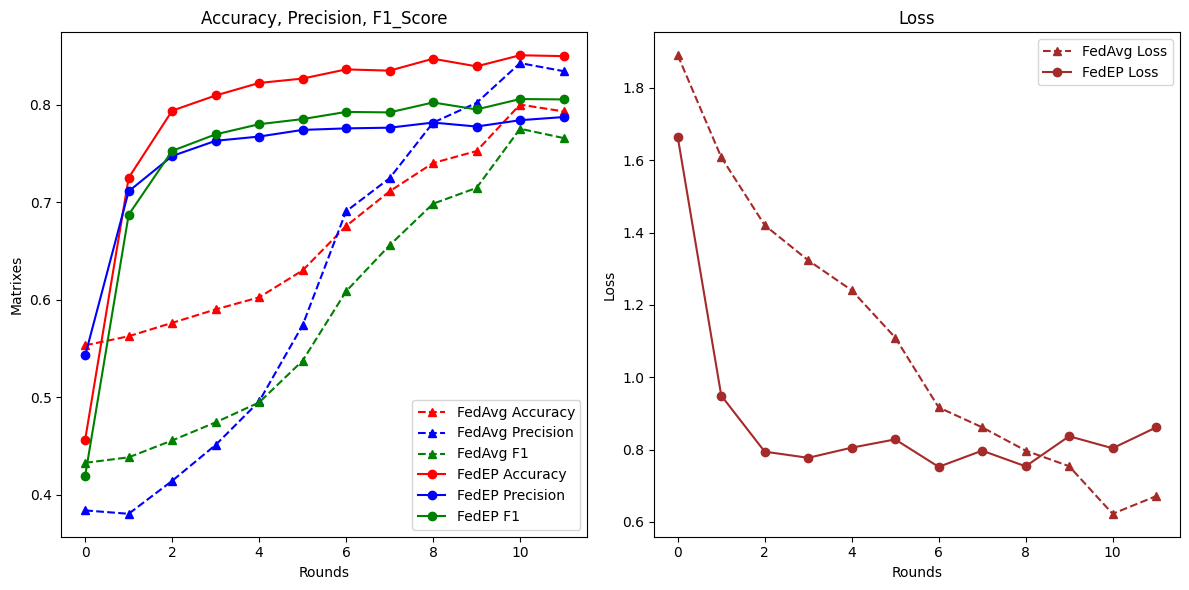

In [29]:
plot_result_comapare(FedAvg_a, FedEP_a)

## Special Case: d4 attackers

d_global [5500, 2000, 1500, 2000, 2000, 1500, 1000, 1500, 1500, 2500]


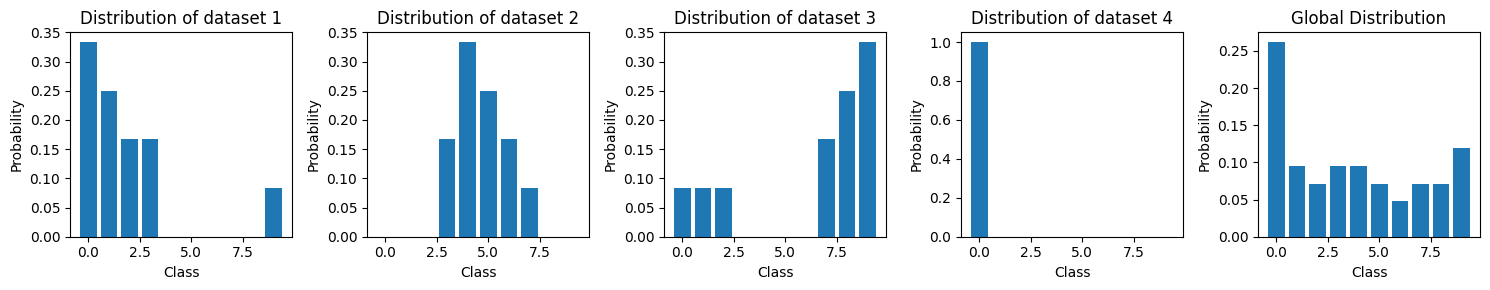

In [10]:
# number of sample in each class
d_1 = [2000, 1500, 1000, 1000, 0, 0, 0, 0, 0, 500]
d_2 = [0, 0, 0, 1000, 2000, 1500, 1000, 500, 0, 0]
d_3 = [500, 500, 500, 0, 0, 0, 0, 1000, 1500, 2000]
d_4 = [3000, 0, 0, 0, 0, 0, 0, 0,0,0]
d_global = [ d_1[i]+d_2[i]+d_3[i]+d_4[i] for i in range(10)]
print("d_global", d_global)

p_1 = [v / sum(d_1) for v in d_1]
p_2 = [v / sum(d_2) for v in d_2]
p_3 = [v / sum(d_3) for v in d_3]
p_4 = [v / sum(d_4) for v in d_4]
p_global = [v / sum(d_global) for v in d_global]

# Define the class labels
class_labels = list(range(10))

# Define the data
data = [p_1, p_2, p_3, p_4, p_global]

# Plot the histograms
fig, ax = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    ax[i].bar(class_labels, data[i])
    ax[i].set_xlabel('Class')
    ax[i].set_ylabel('Probability')
    if i == 4:
        ax[i].set_title(f'Global Distribution')
    else:
        ax[i].set_title(f'Distribution of dataset {i+1}')

plt.tight_layout()
plt.show()

In [11]:
# number of sample in each class
train_set1, train_set2, train_set3, test_set = distrbuted_data(starters, d_1, d_2, d_3)

# add an attacker
train_set4 = copy.deepcopy(mnist_train)
index_4 = []
for i in range(10):
        population = range(starters[i], starters[i+1]-1)
        index_4_i = np.random.choice(population, size=d_4[i], replace=False)
        index_4.extend(index_4_i)
train_set4.data = train_set4.data[index_4]
train_set4.targets = train_set4.targets[index_4]

In [15]:
np.random.seed(2023)

unique_sorted_labels_list = torch.unique(mnist_train.targets, sorted=True).tolist()

Y = train_set1.targets
theta1, likelihood1 = Distribution_Fitting(Y)

print(f"theta1: {theta1}")
print(f"likelihood1: {likelihood1}")

prob1 = predict_likelihood(theta1, unique_sorted_labels_list)
print(f"prob1: {prob1}")

Ms: 3
likelihood_hs: [ -8911.95074005  -7968.29019162 -10253.51083029]
BICs: [17823.9014801  15945.27989798 20524.42069007]
theta1: [[0.08333333 9.         0.1       ]
 [0.91666667 1.18181818 1.33966943]]
likelihood1: -7968.290191617825
prob1: [0.203 0.304 0.227 0.085 0.016 0.001 0.    0.    0.01  0.073]


In [16]:
np.random.seed(2023)

Y = train_set2.targets
theta2, likelihood2 = Distribution_Fitting(Y)

print(f"theta2: {theta2}")
print(f"likelihood2: {likelihood2}")

prob2 = predict_likelihood(theta2,unique_sorted_labels_list)
print(f"prob2: {prob2}")

Ms: 3
likelihood_hs: [ -6962.3448647   -9256.01780401 -11420.68515198]
BICs: [13924.6897294  18520.73512277 22858.76933345]
theta2: [[1.         4.66666667 1.48888889]]
likelihood2: -6962.3448646996185
prob2: [0.    0.006 0.04  0.146 0.286 0.298 0.166 0.049 0.008 0.001]


In [17]:
np.random.seed(2023)

Y = train_set3.targets
theta3, likelihood3 = Distribution_Fitting(Y)

print(f"theta3: {theta3}")
print(f"likelihood3: {likelihood3}")

prob3 = predict_likelihood(theta3,unique_sorted_labels_list)
print(f"prob3: {prob3}")

Ms: 3
likelihood_hs: [-10249.58881831  -8855.91689667  -9788.31219583]
BICs: [20499.17763662 17720.53330809 19594.02342116]
theta3: [[0.75       8.22222222 0.71728395]
 [0.25       1.         0.76666667]]
likelihood3: -8855.91689667205
prob3: [0.067 0.107 0.053 0.008 0.    0.001 0.021 0.153 0.328 0.207]


In [13]:
np.random.seed(2023)

Y = train_set4.targets
theta4, likelihood4 = Distribution_Fitting(Y)

print(f"theta4: {theta4}")
print(f"likelihood4: {likelihood4}")

prob4 = predict_likelihood(theta4, unique_sorted_labels_list)
print(f"prob4: {prob4}")


Ms: 1
likelihood_hs: [-91.26329251]
BICs: [182.52658502]
theta4: [[1.  0.  0.1]]
likelihood4: -91.26329251013497
prob4: [0.87  0.043 0.    0.    0.    0.    0.    0.    0.    0.   ]


theta_global: [[0.02380952 9.         0.1       ]
 [0.26190476 1.18181818 1.33966943]
 [0.28571429 4.66666667 1.48888889]
 [0.21428571 8.22222222 0.71728395]
 [0.07142857 1.         0.76666667]
 [0.14285714 0.         0.1       ]]


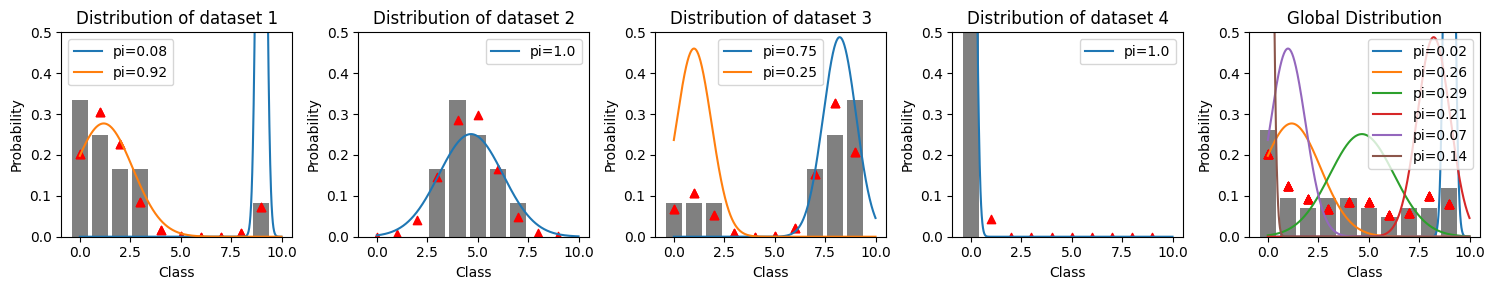

In [18]:
from scipy.stats import norm

normalized_d_1 = [v / sum(d_1) for v in d_1]
normalized_d_2 = [v / sum(d_2) for v in d_2]
normalized_d_3 = [v / sum(d_3) for v in d_3]
normalized_d_4 = [v / sum(d_4) for v in d_4]
normalized_d_global = [v / sum(d_global) for v in d_global]

def normalize_global_pi(theta, data_client, data_global):
    theta_new = np.copy(theta)
    theta_new[:,0] = theta[:,0]*data_client/data_global
    return theta_new

data1 = len(train_set1.targets)
data2 = len(train_set2.targets)
data3 = len(train_set3.targets)
data4 = len(train_set4.targets)
data_global = data1 + data2 + data3 + data4

theta_global = np.vstack((normalize_global_pi(theta1, data1, data_global),
                          normalize_global_pi(theta2, data2, data_global),
                          normalize_global_pi(theta3, data3, data_global),
                          normalize_global_pi(theta4, data4, data_global)))
print(f"theta_global: {theta_global}")

# Define the class labels
class_labels = list(range(10))

# Define the data
data = [normalized_d_1, normalized_d_2, normalized_d_3,normalized_d_4, normalized_d_global]
theta = [theta1, theta2, theta3,theta4, theta_global]


prob_global = predict_likelihood(theta_global,unique_sorted_labels_list)
prob = [prob1, prob2, prob3,prob4, prob_global]

# Plot the histograms
fig, ax = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    ax[i].bar(class_labels, data[i], color='grey')
    ax[i].set_xlabel('Class')
    ax[i].set_ylabel('Probability')
    ax[i].set_ylim(0, 0.5)
    
    for m in range(len(theta[i])):
        x = np.linspace(0, 10, 1000)
        ax[i].plot(x, norm.pdf(x, theta[i][m,1], theta[i][m,2]+epsilon_prime), label=f"pi={round(theta[i][m,0],2)}" )
        ax[i].scatter(class_labels, prob[i][class_labels], marker='^', color='red')
        ax[i].legend()
    if i == 4:
        ax[i].set_title(f'Global Distribution')
    else:
        ax[i].set_title(f'Distribution of dataset {i+1}')

plt.tight_layout()
plt.show()

In [24]:
model_global = MNISTModelMLP()
model1 = MNISTModelMLP()
model2 = MNISTModelMLP()
model3 = MNISTModelMLP()
model4 = MNISTModelMLP()

a = Server_FedEP(model_global, test_set)
b = Client_FedEP("node_b", model1, train_set1, test_set, Epochs=2)
c = Client_FedEP("node_c", model2, train_set2, test_set, Epochs=2)
d = Client_FedEP("node_d", model3, train_set3, test_set, Epochs=2)
e = Client_FedEP("node_d", model4, train_set4, test_set, Epochs=2)
a.add_client(b)
a.add_client(c)
a.add_client(d)
a.add_client(e)

a.train(rounds=5)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Ms: 3
likelihood_hs: [-12518.90905291  -9323.61302493  -9497.43900047]
BICs: [25037.81810581 18655.92556461 19012.27703045]
Ms: 3
likelihood_hs: [ -9160.05634124 -11043.12836172 -12452.08582874]
BICs: [18320.11268248 22094.95623818 24921.57068697]
Ms: 3
likelihood_hs: [-14655.72114018 -10291.27413321 -13386.22136274]
BICs: [29311.44228036 20591.24778117 26789.84175498]
Ms: 1
likelihood_hs: [3114.36135243]
BICs: [-6228.72270485]
theta_global: [[0.26190476 1.18181818 1.24966942]
 [0.02380952 9.         0.01      ]
 [0.28571429 4.66666667 1.39888889]
 [0.07142857 1.         0.67666667]
 [0.21428571 8.22222222 0.62728395]
 [0.14285714 0.         0.01      ]]
1.0000000000010973
24.070707070749002
3.9725089279595682
prob_global: [0.4729, 0.1272, 0.0951, 0.0628, 0.0863, 0.0924, 0.0529, 0.0475, 0.1052, 0.1329]
sum prob_global: 1.2752000000000001
KL_divergence: [1.2948082339451636, 3.5665923379583933, 1.8840069622291797, 1.5114680958843105]
alpha_k: [0.15681576082338186, 0.43195422793973093, 0.


  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.941     Total estimated model params size (MB)
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connecto

Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.62it/s, v_num=894, Train/Loss=0.0111, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.610, TrainEpoch/Precision=0.628, TrainEpoch/Recall=0.610, TrainEpoch/F1Score=0.618]Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.55it/s, v_num=894, Train/Loss=0.0111, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.610, TrainEpoch/Precision=0.628, TrainEpoch/Recall=0.610, TrainEpoch/F1Score=0.618]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.48it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.47645634412765503    │
│       Test/F1Score        │    0.3291465938091278     │
│         Test/Loss         │     6.108310222625732     │
│      Test/Precision       │    0.26215633749961853    │
│        Test/Recall        │    0.47645634412765503    │
│    TestEpoch/Accuracy     │    0.47663426399230957    │
│     TestEpoch/F1Score     │    0.32953059673309326    │
│    TestEpoch/Precision    │    0.2545489966869354     │
│     TestEpoch/Recall      │    0.47663426399230957    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.32it/s, v_num=896, Train/Loss=0.101, Train/Accuracy=0.962, Train/Precision=0.964, Train/Recall=0.962, Train/F1Score=0.962, TrainEpoch/Accuracy=0.574, TrainEpoch/Precision=0.626, TrainEpoch/Recall=0.574, TrainEpoch/F1Score=0.595] Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.22it/s, v_num=896, Train/Loss=0.101, Train/Accuracy=0.962, Train/Precision=0.964, Train/Recall=0.962, Train/F1Score=0.962, TrainEpoch/Accuracy=0.574, TrainEpoch/Precision=0.626, TrainEpoch/Recall=0.574, TrainEpoch/F1Score=0.595]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.16it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.472120076417923     │
│       Test/F1Score        │    0.32963934540748596    │
│         Test/Loss         │     6.495729923248291     │
│      Test/Precision       │    0.27690455317497253    │
│        Test/Recall        │     0.472120076417923     │
│    TestEpoch/Accuracy     │    0.47421830892562866    │
│     TestEpoch/F1Score     │    0.3330754339694977     │
│    TestEpoch/Precision    │    0.27401483058929443    │
│     TestEpoch/Recall      │    0.47421830892562866    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.77it/s, v_num=898, Train/Loss=0.178, Train/Accuracy=0.977, Train/Precision=0.951, Train/Recall=0.977, Train/F1Score=0.961, TrainEpoch/Accuracy=0.554, TrainEpoch/Precision=0.638, TrainEpoch/Recall=0.554, TrainEpoch/F1Score=0.585] Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.49it/s, v_num=898, Train/Loss=0.178, Train/Accuracy=0.977, Train/Precision=0.951, Train/Recall=0.977, Train/F1Score=0.961, TrainEpoch/Accuracy=0.554, TrainEpoch/Precision=0.638, TrainEpoch/Recall=0.554, TrainEpoch/F1Score=0.585]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.92it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5662834644317627     │
│       Test/F1Score        │    0.4468083381652832     │
│         Test/Loss         │    5.2742533683776855     │
│      Test/Precision       │    0.3937907814979553     │
│        Test/Recall        │    0.5662834644317627     │
│    TestEpoch/Accuracy     │    0.5671830177307129     │
│     TestEpoch/F1Score     │    0.44999685883522034    │
│    TestEpoch/Precision    │    0.38925933837890625    │
│     TestEpoch/Recall      │    0.5671830177307129     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_d finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (47) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 1: 100%|██████████| 47/47 [00:05<00:00,  7.96it/s, v_num=900, Train/Loss=1.7e-8, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.196, TrainEpoch/Precision=0.200, TrainEpoch/Recall=0.196, TrainEpoch/F1Score=0.198] Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 47/47 [00:05<00:00,  7.87it/s, v_num=900, Train/Loss=1.7e-8, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.196, TrainEpoch/Precision=0.200, TrainEpoch/Recall=0.196, TrainEpoch/F1Score=0.198]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.10014237463474274    │
│       Test/F1Score        │    0.01772802509367466    │
│         Test/Loss         │    19.423131942749023     │
│      Test/Precision       │   0.009813334792852402    │
│        Test/Recall        │    0.10014237463474274    │
│    TestEpoch/Accuracy     │    0.10000000149011612    │
│     TestEpoch/F1Score     │   0.017850637435913086    │
│    TestEpoch/Precision    │   0.009800000116229057    │
│     TestEpoch/Recall      │    0.10000000149011612    │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.49it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.43080878257751465    │
│       Test/F1Score        │    0.31730133295059204    │
│         Test/Loss         │     1.634260892868042     │
│      Test/Precision       │    0.37422648072242737    │
│        Test/Recall        │    0.43080878257751465    │
│    TestEpoch/Accuracy     │    0.4298083782196045     │
│     TestEpoch/F1Score     │    0.3317340612411499     │
│    TestEpoch/Precision    │    0.5200860500335693     │
│     TestEpoch/Recall      │    0.4298083782196045     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 1 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.14it/s, v_num=903, Train/Loss=0.128, Train/Accuracy=0.975, Train/Precision=0.950, Train/Recall=0.975, Train/F1Score=0.958, TrainEpoch/Accuracy=0.777, TrainEpoch/Precision=0.785, TrainEpoch/Recall=0.777, TrainEpoch/F1Score=0.781] Epoch end: Train, epoch number: 3


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.07it/s, v_num=903, Train/Loss=0.128, Train/Accuracy=0.975, Train/Precision=0.950, Train/Recall=0.975, Train/F1Score=0.958, TrainEpoch/Accuracy=0.777, TrainEpoch/Precision=0.785, TrainEpoch/Recall=0.777, TrainEpoch/F1Score=0.781]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.19it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.48256656527519226    │
│       Test/F1Score        │    0.3342861831188202     │
│         Test/Loss         │     4.978890419006348     │
│      Test/Precision       │    0.2683657705783844     │
│        Test/Recall        │    0.48256656527519226    │
│    TestEpoch/Accuracy     │    0.4827069938182831     │
│     TestEpoch/F1Score     │    0.3348000645637512     │
│    TestEpoch/Precision    │    0.26072514057159424    │
│     TestEpoch/Recall      │    0.4827069938182831     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.24it/s, v_num=905, Train/Loss=0.073, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.780, TrainEpoch/Precision=0.786, TrainEpoch/Recall=0.780, TrainEpoch/F1Score=0.783] Epoch end: Train, epoch number: 3


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.96it/s, v_num=905, Train/Loss=0.073, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.780, TrainEpoch/Precision=0.786, TrainEpoch/Recall=0.780, TrainEpoch/F1Score=0.783]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.53it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.47877293825149536    │
│       Test/F1Score        │    0.3292437493801117     │
│         Test/Loss         │     5.363192081451416     │
│      Test/Precision       │    0.2693580389022827     │
│        Test/Recall        │    0.47877293825149536    │
│    TestEpoch/Accuracy     │    0.48040592670440674    │
│     TestEpoch/F1Score     │    0.33256030082702637    │
│    TestEpoch/Precision    │    0.2658217251300812     │
│     TestEpoch/Recall      │    0.48040592670440674    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, v_num=907, Train/Loss=0.0808, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.588, TrainEpoch/Precision=0.604, TrainEpoch/Recall=0.588, TrainEpoch/F1Score=0.596]Epoch end: Train, epoch number: 3


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.93it/s, v_num=907, Train/Loss=0.0808, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.588, TrainEpoch/Precision=0.604, TrainEpoch/Recall=0.588, TrainEpoch/F1Score=0.596]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.62it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5693114399909973     │
│       Test/F1Score        │    0.4492987394332886     │
│         Test/Loss         │     3.968393325805664     │
│      Test/Precision       │    0.3965749144554138     │
│        Test/Recall        │    0.5693114399909973     │
│    TestEpoch/Accuracy     │    0.5704811811447144     │
│     TestEpoch/F1Score     │    0.45275336503982544    │
│    TestEpoch/Precision    │     0.393663227558136     │
│     TestEpoch/Recall      │    0.5704811811447144     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_d finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (47) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 1: 100%|██████████| 47/47 [00:05<00:00,  7.84it/s, v_num=909, Train/Loss=2.01e-6, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.500, TrainEpoch/Precision=0.500, TrainEpoch/Recall=0.500, TrainEpoch/F1Score=0.500]Epoch end: Train, epoch number: 3


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 47/47 [00:06<00:00,  7.69it/s, v_num=909, Train/Loss=2.01e-6, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.500, TrainEpoch/Precision=0.500, TrainEpoch/Recall=0.500, TrainEpoch/F1Score=0.500]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.41it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.10014237463474274    │
│       Test/F1Score        │    0.01772802509367466    │
│         Test/Loss         │     14.88404655456543     │
│      Test/Precision       │   0.009813334792852402    │
│        Test/Recall        │    0.10014237463474274    │
│    TestEpoch/Accuracy     │    0.10000000149011612    │
│     TestEpoch/F1Score     │   0.017850637435913086    │
│    TestEpoch/Precision    │   0.009800000116229057    │
│     TestEpoch/Recall      │    0.10000000149011612    │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.48it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.6551701426506042     │
│       Test/F1Score        │    0.5906221866607666     │
│         Test/Loss         │    1.1191959381103516     │
│      Test/Precision       │    0.6506233811378479     │
│        Test/Recall        │    0.6551701426506042     │
│    TestEpoch/Accuracy     │     0.654518187046051     │
│     TestEpoch/F1Score     │    0.6052775979042053     │
│    TestEpoch/Precision    │    0.6926244497299194     │
│     TestEpoch/Recall      │     0.654518187046051     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 2 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.68it/s, v_num=911, Train/Loss=0.0441, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.682, TrainEpoch/Precision=0.686, TrainEpoch/Recall=0.682, TrainEpoch/F1Score=0.684] Epoch end: Train, epoch number: 5


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.58it/s, v_num=911, Train/Loss=0.0441, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.682, TrainEpoch/Precision=0.686, TrainEpoch/Recall=0.682, TrainEpoch/F1Score=0.684]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.48it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4870963394641876     │
│       Test/F1Score        │    0.34026607871055603    │
│         Test/Loss         │     4.335424900054932     │
│      Test/Precision       │    0.2767971456050873     │
│        Test/Recall        │    0.4870963394641876     │
│    TestEpoch/Accuracy     │    0.4873218834400177     │
│     TestEpoch/F1Score     │    0.34094852209091187    │
│    TestEpoch/Precision    │    0.27112704515457153    │
│     TestEpoch/Recall      │    0.4873218834400177     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.09it/s, v_num=913, Train/Loss=0.0678, Train/Accuracy=0.982, Train/Precision=0.985, Train/Recall=0.982, Train/F1Score=0.982, TrainEpoch/Accuracy=0.797, TrainEpoch/Precision=0.800, TrainEpoch/Recall=0.797, TrainEpoch/F1Score=0.798]Epoch end: Train, epoch number: 5


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.00it/s, v_num=913, Train/Loss=0.0678, Train/Accuracy=0.982, Train/Precision=0.985, Train/Recall=0.982, Train/F1Score=0.982, TrainEpoch/Accuracy=0.797, TrainEpoch/Precision=0.800, TrainEpoch/Recall=0.797, TrainEpoch/F1Score=0.798]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.06it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.47970259189605713    │
│       Test/F1Score        │    0.32998380064964294    │
│         Test/Loss         │     4.621565818786621     │
│      Test/Precision       │    0.2691771984100342     │
│        Test/Recall        │    0.47970259189605713    │
│    TestEpoch/Accuracy     │    0.4810488224029541     │
│     TestEpoch/F1Score     │    0.3327639698982239     │
│    TestEpoch/Precision    │    0.2648763656616211     │
│     TestEpoch/Recall      │    0.4810488224029541     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.64it/s, v_num=915, Train/Loss=0.0635, Train/Accuracy=0.917, Train/Precision=0.992, Train/Recall=0.917, Train/F1Score=0.940, TrainEpoch/Accuracy=0.613, TrainEpoch/Precision=0.618, TrainEpoch/Recall=0.613, TrainEpoch/F1Score=0.616]Epoch end: Train, epoch number: 5


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.53it/s, v_num=915, Train/Loss=0.0635, Train/Accuracy=0.917, Train/Precision=0.992, Train/Recall=0.917, Train/F1Score=0.940, TrainEpoch/Accuracy=0.613, TrainEpoch/Precision=0.618, TrainEpoch/Recall=0.613, TrainEpoch/F1Score=0.616]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.89it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5683857202529907     │
│       Test/F1Score        │    0.44684267044067383    │
│         Test/Loss         │    3.2573649883270264     │
│      Test/Precision       │    0.39382699131965637    │
│        Test/Recall        │    0.5683857202529907     │
│    TestEpoch/Accuracy     │    0.5695877075195312     │
│     TestEpoch/F1Score     │     0.449968159198761     │
│    TestEpoch/Precision    │    0.38976535201072693    │
│     TestEpoch/Recall      │    0.5695877075195312     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_d finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (47) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 1: 100%|██████████| 47/47 [00:05<00:00,  8.22it/s, v_num=917, Train/Loss=1.49e-7, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=1.000, TrainEpoch/Precision=1.000, TrainEpoch/Recall=1.000, TrainEpoch/F1Score=1.000]Epoch end: Train, epoch number: 5


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 47/47 [00:05<00:00,  8.11it/s, v_num=917, Train/Loss=1.49e-7, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=1.000, TrainEpoch/Precision=1.000, TrainEpoch/Recall=1.000, TrainEpoch/F1Score=1.000]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.02it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.10014237463474274    │
│       Test/F1Score        │    0.01772802509367466    │
│         Test/Loss         │     13.96745491027832     │
│      Test/Precision       │   0.009813334792852402    │
│        Test/Recall        │    0.10014237463474274    │
│    TestEpoch/Accuracy     │    0.10000000149011612    │
│     TestEpoch/F1Score     │   0.017850637435913086    │
│    TestEpoch/Precision    │   0.009800000116229057    │
│     TestEpoch/Recall      │    0.10000000149011612    │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.84it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.7393829822540283     │
│       Test/F1Score        │    0.6880916357040405     │
│         Test/Loss         │    0.8770320415496826     │
│      Test/Precision       │    0.7190223336219788     │
│        Test/Recall        │    0.7393829822540283     │
│    TestEpoch/Accuracy     │    0.7390627861022949     │
│     TestEpoch/F1Score     │    0.7000794410705566     │
│    TestEpoch/Precision    │    0.7193742990493774     │
│     TestEpoch/Recall      │    0.7390627861022949     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 3 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.11it/s, v_num=919, Train/Loss=0.0803, Train/Accuracy=0.950, Train/Precision=0.983, Train/Recall=0.950, Train/F1Score=0.963, TrainEpoch/Accuracy=0.534, TrainEpoch/Precision=0.536, TrainEpoch/Recall=0.534, TrainEpoch/F1Score=0.535] Epoch end: Train, epoch number: 7


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.01it/s, v_num=919, Train/Loss=0.0803, Train/Accuracy=0.950, Train/Precision=0.983, Train/Recall=0.950, Train/F1Score=0.963, TrainEpoch/Accuracy=0.534, TrainEpoch/Precision=0.536, TrainEpoch/Recall=0.534, TrainEpoch/F1Score=0.535]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.84it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.48827335238456726    │
│       Test/F1Score        │    0.34344151616096497    │
│         Test/Loss         │    3.9282054901123047     │
│      Test/Precision       │    0.2813270688056946     │
│        Test/Recall        │    0.48827335238456726    │
│    TestEpoch/Accuracy     │    0.48818856477737427    │
│     TestEpoch/F1Score     │    0.3441784381866455     │
│    TestEpoch/Precision    │    0.27615052461624146    │
│     TestEpoch/Recall      │    0.48818856477737427    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.78it/s, v_num=921, Train/Loss=0.201, Train/Accuracy=0.958, Train/Precision=0.940, Train/Recall=0.958, Train/F1Score=0.942, TrainEpoch/Accuracy=0.807, TrainEpoch/Precision=0.810, TrainEpoch/Recall=0.807, TrainEpoch/F1Score=0.809] Epoch end: Train, epoch number: 7


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.71it/s, v_num=921, Train/Loss=0.201, Train/Accuracy=0.958, Train/Precision=0.940, Train/Recall=0.958, Train/F1Score=0.942, TrainEpoch/Accuracy=0.807, TrainEpoch/Precision=0.810, TrainEpoch/Recall=0.807, TrainEpoch/F1Score=0.809]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.74it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4779874384403229     │
│       Test/F1Score        │    0.31879186630249023    │
│         Test/Loss         │     4.936898708343506     │
│      Test/Precision       │    0.2502829432487488     │
│        Test/Recall        │    0.4779874384403229     │
│    TestEpoch/Accuracy     │    0.4790429472923279     │
│     TestEpoch/F1Score     │    0.3205050826072693     │
│    TestEpoch/Precision    │    0.24443936347961426    │
│     TestEpoch/Recall      │    0.4790429472923279     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.82it/s, v_num=923, Train/Loss=0.0328, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.622, TrainEpoch/Precision=0.626, TrainEpoch/Recall=0.622, TrainEpoch/F1Score=0.624]Epoch end: Train, epoch number: 7


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.72it/s, v_num=923, Train/Loss=0.0328, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.622, TrainEpoch/Precision=0.626, TrainEpoch/Recall=0.622, TrainEpoch/F1Score=0.624]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.51it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5767158269882202     │
│       Test/F1Score        │    0.4506344795227051     │
│         Test/Loss         │    2.5288939476013184     │
│      Test/Precision       │     0.391683965921402     │
│        Test/Recall        │    0.5767158269882202     │
│    TestEpoch/Accuracy     │    0.5785589814186096     │
│     TestEpoch/F1Score     │    0.4543752372264862     │
│    TestEpoch/Precision    │    0.48665136098861694    │
│     TestEpoch/Recall      │    0.5785589814186096     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_d finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (47) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 1: 100%|██████████| 47/47 [00:05<00:00,  8.08it/s, v_num=925, Train/Loss=1.43e-6, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.500, TrainEpoch/Precision=0.500, TrainEpoch/Recall=0.500, TrainEpoch/F1Score=0.500]Epoch end: Train, epoch number: 7


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 47/47 [00:05<00:00,  7.99it/s, v_num=925, Train/Loss=1.43e-6, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.500, TrainEpoch/Precision=0.500, TrainEpoch/Recall=0.500, TrainEpoch/F1Score=0.500]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.10014237463474274    │
│       Test/F1Score        │    0.01772802509367466    │
│         Test/Loss         │    13.582281112670898     │
│      Test/Precision       │   0.009813334792852402    │
│        Test/Recall        │    0.10014237463474274    │
│    TestEpoch/Accuracy     │    0.10000000149011612    │
│     TestEpoch/F1Score     │   0.017850637435913086    │
│    TestEpoch/Precision    │   0.009800000116229057    │
│     TestEpoch/Recall      │    0.10000000149011612    │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.53it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.7519946098327637     │
│       Test/F1Score        │    0.7015056610107422     │
│         Test/Loss         │    0.8306365013122559     │
│      Test/Precision       │    0.7249819040298462     │
│        Test/Recall        │    0.7519946098327637     │
│    TestEpoch/Accuracy     │    0.7517225742340088     │
│     TestEpoch/F1Score     │     0.711726188659668     │
│    TestEpoch/Precision    │     0.823218822479248     │
│     TestEpoch/Recall      │    0.7517225742340088     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 4 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.07it/s, v_num=927, Train/Loss=0.0118, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.605, TrainEpoch/Precision=0.606, TrainEpoch/Recall=0.605, TrainEpoch/F1Score=0.605] Epoch end: Train, epoch number: 9


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.00it/s, v_num=927, Train/Loss=0.0118, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.605, TrainEpoch/Precision=0.606, TrainEpoch/Recall=0.605, TrainEpoch/F1Score=0.605]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.32it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.49075010418891907    │
│       Test/F1Score        │    0.34191209077835083    │
│         Test/Loss         │     4.167540073394775     │
│      Test/Precision       │    0.2772592604160309     │
│        Test/Recall        │    0.49075010418891907    │
│    TestEpoch/Accuracy     │    0.49066880345344543    │
│     TestEpoch/F1Score     │    0.3420979380607605     │
│    TestEpoch/Precision    │    0.3691410422325134     │
│     TestEpoch/Recall      │    0.49066880345344543    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.34it/s, v_num=929, Train/Loss=0.0501, Train/Accuracy=0.960, Train/Precision=0.988, Train/Recall=0.960, Train/F1Score=0.972, TrainEpoch/Accuracy=0.696, TrainEpoch/Precision=0.699, TrainEpoch/Recall=0.696, TrainEpoch/F1Score=0.697] Epoch end: Train, epoch number: 9


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.21it/s, v_num=929, Train/Loss=0.0501, Train/Accuracy=0.960, Train/Precision=0.988, Train/Recall=0.960, Train/F1Score=0.972, TrainEpoch/Accuracy=0.696, TrainEpoch/Precision=0.699, TrainEpoch/Recall=0.696, TrainEpoch/F1Score=0.697]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.08it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4812527894973755     │
│       Test/F1Score        │    0.3281528055667877     │
│         Test/Loss         │     5.103939533233643     │
│      Test/Precision       │    0.26623231172561646    │
│        Test/Recall        │    0.4812527894973755     │
│    TestEpoch/Accuracy     │    0.4827669858932495     │
│     TestEpoch/F1Score     │    0.3310542702674866     │
│    TestEpoch/Precision    │    0.26226571202278137    │
│     TestEpoch/Recall      │    0.4827669858932495     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.73it/s, v_num=931, Train/Loss=0.0589, Train/Accuracy=0.944, Train/Precision=0.987, Train/Recall=0.944, Train/F1Score=0.960, TrainEpoch/Accuracy=0.565, TrainEpoch/Precision=0.569, TrainEpoch/Recall=0.565, TrainEpoch/F1Score=0.567]Epoch end: Train, epoch number: 9


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.65it/s, v_num=931, Train/Loss=0.0589, Train/Accuracy=0.944, Train/Precision=0.987, Train/Recall=0.944, Train/F1Score=0.960, TrainEpoch/Accuracy=0.565, TrainEpoch/Precision=0.569, TrainEpoch/Recall=0.565, TrainEpoch/F1Score=0.567]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.58it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.574161171913147     │
│       Test/F1Score        │    0.45703887939453125    │
│         Test/Loss         │     2.767860174179077     │
│      Test/Precision       │    0.40905657410621643    │
│        Test/Recall        │     0.574161171913147     │
│    TestEpoch/Accuracy     │    0.5757836103439331     │
│     TestEpoch/F1Score     │    0.4613322615623474     │
│    TestEpoch/Precision    │    0.5056357383728027     │
│     TestEpoch/Recall      │    0.5757836103439331     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_d finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/loops/fit_loop.py:293: The number of training batches (47) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Epoch 1: 100%|██████████| 47/47 [00:06<00:00,  7.37it/s, v_num=933, Train/Loss=3.28e-7, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.500, TrainEpoch/Precision=0.500, TrainEpoch/Recall=0.500, TrainEpoch/F1Score=0.500]Epoch end: Train, epoch number: 9


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 47/47 [00:06<00:00,  6.95it/s, v_num=933, Train/Loss=3.28e-7, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.500, TrainEpoch/Precision=0.500, TrainEpoch/Recall=0.500, TrainEpoch/F1Score=0.500]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.14it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.10043521970510483    │
│       Test/F1Score        │    0.01823561266064644    │
│         Test/Loss         │    11.639126777648926     │
│      Test/Precision       │   0.011736190877854824    │
│        Test/Recall        │    0.10043521970510483    │
│    TestEpoch/Accuracy     │    0.10029183328151703    │
│     TestEpoch/F1Score     │   0.018437474966049194    │
│    TestEpoch/Precision    │    0.10980294644832611    │
│     TestEpoch/Recall      │    0.10029183328151703    │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.00it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.7953879237174988     │
│       Test/F1Score        │    0.7490314245223999     │
│         Test/Loss         │    0.7302995324134827     │
│      Test/Precision       │    0.7525159120559692     │
│        Test/Recall        │    0.7953879237174988     │
│    TestEpoch/Accuracy     │    0.7967854738235474     │
│     TestEpoch/F1Score     │    0.7578885555267334     │
│    TestEpoch/Precision    │     0.746097207069397     │
│     TestEpoch/Recall      │    0.7967854738235474     │
└───────────────────────────┴───────────────────────────┘

Evaluating at Server finished
Round 5 finished
train took 668.7883 seconds


In [25]:
FedEP_non_iid_s3_r5_e2={'Scenario3':[a,b,c,d,e]}
pickle.dump(FedEP_non_iid_s3_r5_e2, open("FedEP_non_iid_s3_r5_e2.pkl", "wb"))

d_global [8500, 2000, 1500, 2000, 2000, 1500, 1000, 1500, 1500, 2500]


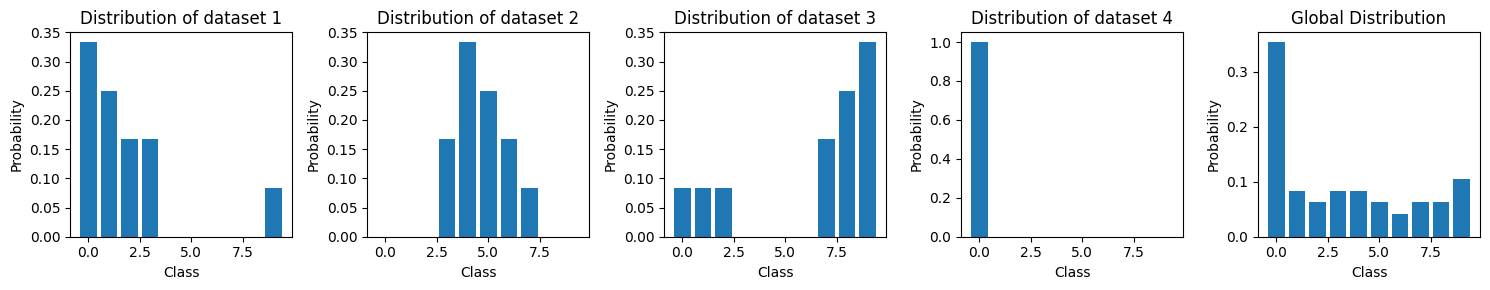

In [26]:
# number of sample in each class
d_1 = [2000, 1500, 1000, 1000, 0, 0, 0, 0, 0, 500]
d_2 = [0, 0, 0, 1000, 2000, 1500, 1000, 500, 0, 0]
d_3 = [500, 500, 500, 0, 0, 0, 0, 1000, 1500, 2000]
d_4 = [6000, 0, 0, 0, 0, 0, 0, 0,0,0]
d_global = [ d_1[i]+d_2[i]+d_3[i]+d_4[i] for i in range(10)]
print("d_global", d_global)

p_1 = [v / sum(d_1) for v in d_1]
p_2 = [v / sum(d_2) for v in d_2]
p_3 = [v / sum(d_3) for v in d_3]
p_4 = [v / sum(d_4) for v in d_4]
p_global = [v / sum(d_global) for v in d_global]

# Define the class labels
class_labels = list(range(10))

# Define the data
data = [p_1, p_2, p_3, p_4, p_global]

# Plot the histograms
fig, ax = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    ax[i].bar(class_labels, data[i])
    ax[i].set_xlabel('Class')
    ax[i].set_ylabel('Probability')
    if i == 4:
        ax[i].set_title(f'Global Distribution')
    else:
        ax[i].set_title(f'Distribution of dataset {i+1}')

plt.tight_layout()
plt.show()

In [28]:
# number of sample in each class
train_set1, train_set2, train_set3, test_set = distrbuted_data(starters, d_1, d_2, d_3)

# add an attacker
train_set4 = copy.deepcopy(mnist_train)
index_4 = []
for i in range(10):
        population = range(starters[i], starters[i+1]-1)
        index_4_i = np.random.choice(population, size=d_4[i], replace=True)
        index_4.extend(index_4_i)
train_set4.data = train_set4.data[index_4]
train_set4.targets = train_set4.targets[index_4]

In [29]:
np.random.seed(2023)

unique_sorted_labels_list = torch.unique(mnist_train.targets, sorted=True).tolist()

Y = train_set1.targets
theta1, likelihood1 = Distribution_Fitting(Y)

print(f"theta1: {theta1}")
print(f"likelihood1: {likelihood1}")

prob1 = predict_likelihood(theta1, unique_sorted_labels_list)
print(f"prob1: {prob1}")

Ms: 3
likelihood_hs: [-12518.90905291  -9323.61302493  -7161.80964318]
BICs: [25037.81810581 18655.92556461 14341.01831585]
theta1: [[5.94603788e-01 1.82194153e+00 7.54860172e-01]
 [8.33333333e-02 9.00000000e+00 1.00000000e-02]
 [3.22062890e-01 3.36168414e-11 1.00000000e-02]]
likelihood1: -7161.809643175771
prob1: [0.938 0.176 0.265 0.108 0.012 0.    0.    0.    0.    0.234]


In [30]:
np.random.seed(2023)

Y = train_set2.targets
theta2, likelihood2 = Distribution_Fitting(Y)

print(f"theta2: {theta2}")
print(f"likelihood2: {likelihood2}")

prob2 = predict_likelihood(theta2,unique_sorted_labels_list)
print(f"prob2: {prob2}")

Ms: 3
likelihood_hs: [ -9160.05634124 -11012.85299237 -12914.59389276]
BICs: [18320.11268248 22034.40549949 25846.58681502]
theta2: [[1.         4.66666667 1.39888889]]
likelihood2: -9160.05634124042
prob2: [0.    0.003 0.027 0.127 0.288 0.322 0.177 0.048 0.006 0.   ]


In [31]:
np.random.seed(2023)

Y = train_set3.targets
theta3, likelihood3 = Distribution_Fitting(Y)

print(f"theta3: {theta3}")
print(f"likelihood3: {likelihood3}")

prob3 = predict_likelihood(theta3,unique_sorted_labels_list)
print(f"prob3: {prob3}")

Ms: 3
likelihood_hs: [-14655.72114018 -10291.27413321 -11122.7086254 ]
BICs: [29311.44228036 20591.24778117 22262.8162803 ]
theta3: [[0.75       8.22222222 0.62728395]
 [0.25       1.         0.67666667]]
likelihood3: -10291.27413320842
prob3: [0.059 0.12  0.057 0.006 0.    0.    0.008 0.118 0.362 0.23 ]


In [32]:
np.random.seed(2023)

Y = train_set4.targets
theta4, likelihood4 = Distribution_Fitting(Y)

print(f"theta4: {theta4}")
print(f"likelihood4: {likelihood4}")

prob4 = predict_likelihood(theta4, unique_sorted_labels_list)
print(f"prob4: {prob4}")


Ms: 1
likelihood_hs: [6228.72270485]
BICs: [-12457.4454097]
theta4: [[1.   0.   0.01]]
likelihood4: 6228.722704850967
prob4: [2.814 0.    0.    0.    0.    0.    0.    0.    0.    0.   ]


theta_global: [[1.48650947e-01 1.82194153e+00 7.54860172e-01]
 [2.08333333e-02 9.00000000e+00 1.00000000e-02]
 [8.05157224e-02 3.36168414e-11 1.00000000e-02]
 [2.50000000e-01 4.66666667e+00 1.39888889e+00]
 [1.87500000e-01 8.22222222e+00 6.27283951e-01]
 [6.25000000e-02 1.00000000e+00 6.76666667e-01]
 [2.50000000e-01 0.00000000e+00 1.00000000e-02]]


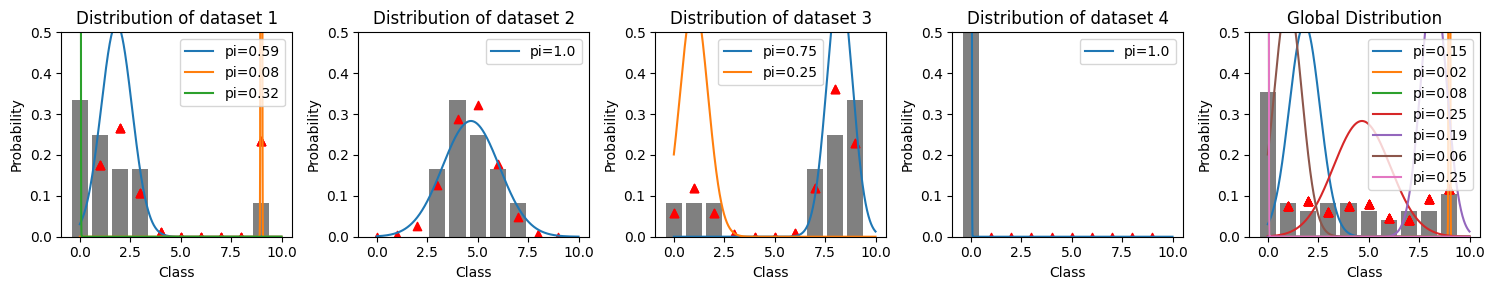

In [33]:
from scipy.stats import norm

normalized_d_1 = [v / sum(d_1) for v in d_1]
normalized_d_2 = [v / sum(d_2) for v in d_2]
normalized_d_3 = [v / sum(d_3) for v in d_3]
normalized_d_4 = [v / sum(d_4) for v in d_4]
normalized_d_global = [v / sum(d_global) for v in d_global]

def normalize_global_pi(theta, data_client, data_global):
    theta_new = np.copy(theta)
    theta_new[:,0] = theta[:,0]*data_client/data_global
    return theta_new

data1 = len(train_set1.targets)
data2 = len(train_set2.targets)
data3 = len(train_set3.targets)
data4 = len(train_set4.targets)
data_global = data1 + data2 + data3 + data4

theta_global = np.vstack((normalize_global_pi(theta1, data1, data_global),
                          normalize_global_pi(theta2, data2, data_global),
                          normalize_global_pi(theta3, data3, data_global),
                          normalize_global_pi(theta4, data4, data_global)))
print(f"theta_global: {theta_global}")

# Define the class labels
class_labels = list(range(10))

# Define the data
data = [normalized_d_1, normalized_d_2, normalized_d_3,normalized_d_4, normalized_d_global]
theta = [theta1, theta2, theta3,theta4, theta_global]


prob_global = predict_likelihood(theta_global,unique_sorted_labels_list)
prob = [prob1, prob2, prob3,prob4, prob_global]

# Plot the histograms
fig, ax = plt.subplots(1, 5, figsize=(15, 3))

for i in range(5):
    ax[i].bar(class_labels, data[i], color='grey')
    ax[i].set_xlabel('Class')
    ax[i].set_ylabel('Probability')
    ax[i].set_ylim(0, 0.5)
    
    for m in range(len(theta[i])):
        x = np.linspace(0, 10, 1000)
        ax[i].plot(x, norm.pdf(x, theta[i][m,1], theta[i][m,2]+epsilon_prime), label=f"pi={round(theta[i][m,0],2)}" )
        ax[i].scatter(class_labels, prob[i][class_labels], marker='^', color='red')
        ax[i].legend()
    if i == 4:
        ax[i].set_title(f'Global Distribution')
    else:
        ax[i].set_title(f'Distribution of dataset {i+1}')

plt.tight_layout()
plt.show()

In [34]:
model_global = MNISTModelMLP()
model1 = MNISTModelMLP()
model2 = MNISTModelMLP()
model3 = MNISTModelMLP()
model4 = MNISTModelMLP()

a = Server_FedEP(model_global, test_set)
b = Client_FedEP("node_b", model1, train_set1, test_set, Epochs=2)
c = Client_FedEP("node_c", model2, train_set2, test_set, Epochs=2)
d = Client_FedEP("node_d", model3, train_set3, test_set, Epochs=2)
e = Client_FedEP("node_d", model4, train_set4, test_set, Epochs=2)
a.add_client(b)
a.add_client(c)
a.add_client(d)
a.add_client(e)

a.train(rounds=5)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] |

Ms: 3
likelihood_hs: [-12518.90905291  -9323.61302493  -9421.76021561]
BICs: [25037.81810581 18655.92556461 18860.91946071]
Ms: 3
likelihood_hs: [ -9160.05634124 -10969.4206249  -12970.21093552]
BICs: [18320.11268248 21947.54076455 25957.82090054]
Ms: 3
likelihood_hs: [-14655.72114018 -18788.73489198 -13354.61790151]
BICs: [29311.44228036 37586.16929872 26726.63483251]
Ms: 1
likelihood_hs: [6228.72270485]
BICs: [-12457.4454097]
theta_global: [[0.22916667 1.18181818 1.24966942]
 [0.02083333 9.         0.01      ]
 [0.25       4.66666667 1.39888889]
 [0.10848559 8.22222219 0.62728395]
 [0.0790144  8.22222222 0.62728394]
 [0.0625     1.         0.67666667]
 [0.25       0.         0.01      ]]
0.9999999968965517
32.292929252121496
4.599792865756699
prob_global: [0.7655, 0.1113, 0.0832, 0.0549, 0.0755, 0.0809, 0.0463, 0.0416, 0.092, 0.1163]
sum prob_global: 1.4675
KL_divergence: [1.9853616404945371, 5.480137385269291, 3.038058732053863, 0.8285603434171664]
alpha_k: [0.17519775409666732, 0.4

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.21it/s, v_num=935, Train/Loss=0.165, Train/Accuracy=0.899, Train/Precision=0.908, Train/Recall=0.899, Train/F1Score=0.886, TrainEpoch/Accuracy=0.460, TrainEpoch/Precision=0.493, TrainEpoch/Recall=0.460, TrainEpoch/F1Score=0.474] Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.13it/s, v_num=935, Train/Loss=0.165, Train/Accuracy=0.899, Train/Precision=0.908, Train/Recall=0.899, Train/F1Score=0.886, TrainEpoch/Accuracy=0.460, TrainEpoch/Precision=0.493, TrainEpoch/Recall=0.460, TrainEpoch/F1Score=0.474]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.85it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4814158082008362     │
│       Test/F1Score        │    0.33442604541778564    │
│         Test/Loss         │     6.32541561126709      │
│      Test/Precision       │    0.26932790875434875    │
│        Test/Recall        │    0.4814158082008362     │
│    TestEpoch/Accuracy     │    0.48087969422340393    │
│     TestEpoch/F1Score     │    0.3349299430847168     │
│    TestEpoch/Precision    │    0.26300233602523804    │
│     TestEpoch/Recall      │    0.48087969422340393    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.94it/s, v_num=937, Train/Loss=0.124, Train/Accuracy=0.964, Train/Precision=0.965, Train/Recall=0.964, Train/F1Score=0.963, TrainEpoch/Accuracy=0.504, TrainEpoch/Precision=0.545, TrainEpoch/Recall=0.504, TrainEpoch/F1Score=0.520] Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.86it/s, v_num=937, Train/Loss=0.124, Train/Accuracy=0.964, Train/Precision=0.965, Train/Recall=0.964, Train/F1Score=0.963, TrainEpoch/Accuracy=0.504, TrainEpoch/Precision=0.545, TrainEpoch/Recall=0.504, TrainEpoch/F1Score=0.520]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.12it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4722181558609009     │
│       Test/F1Score        │    0.32635605335235596    │
│         Test/Loss         │     7.13075065612793      │
│      Test/Precision       │    0.2703157067298889     │
│        Test/Recall        │    0.4722181558609009     │
│    TestEpoch/Accuracy     │    0.47401919960975647    │
│     TestEpoch/F1Score     │    0.32986992597579956    │
│    TestEpoch/Precision    │    0.26766836643218994    │
│     TestEpoch/Recall      │    0.47401919960975647    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.17it/s, v_num=939, Train/Loss=0.153, Train/Accuracy=0.936, Train/Precision=0.890, Train/Recall=0.936, Train/F1Score=0.905, TrainEpoch/Accuracy=0.575, TrainEpoch/Precision=0.655, TrainEpoch/Recall=0.575, TrainEpoch/F1Score=0.605] Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.08it/s, v_num=939, Train/Loss=0.153, Train/Accuracy=0.936, Train/Precision=0.890, Train/Recall=0.936, Train/F1Score=0.905, TrainEpoch/Accuracy=0.575, TrainEpoch/Precision=0.655, TrainEpoch/Recall=0.575, TrainEpoch/F1Score=0.605]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.03it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5659526586532593     │
│       Test/F1Score        │    0.45296964049339294    │
│         Test/Loss         │     5.176140785217285     │
│      Test/Precision       │    0.4060044288635254     │
│        Test/Recall        │    0.5659526586532593     │
│    TestEpoch/Accuracy     │    0.5676321983337402     │
│     TestEpoch/F1Score     │    0.45633751153945923    │
│    TestEpoch/Precision    │    0.4018830955028534     │
│     TestEpoch/Recall      │    0.5676321983337402     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_d finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.26it/s, v_num=941, Train/Loss=1.74e-8, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.165, TrainEpoch/Precision=0.167, TrainEpoch/Recall=0.165, TrainEpoch/F1Score=0.166]Epoch end: Train, epoch number: 1


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.16it/s, v_num=941, Train/Loss=1.74e-8, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.165, TrainEpoch/Precision=0.167, TrainEpoch/Recall=0.165, TrainEpoch/F1Score=0.166]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.67it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.10014237463474274    │
│       Test/F1Score        │    0.01772802509367466    │
│         Test/Loss         │     21.10065460205078     │
│      Test/Precision       │   0.009813334792852402    │
│        Test/Recall        │    0.10014237463474274    │
│    TestEpoch/Accuracy     │    0.10000000149011612    │
│     TestEpoch/F1Score     │   0.017850637435913086    │
│    TestEpoch/Precision    │   0.009800000116229057    │
│     TestEpoch/Recall      │    0.10000000149011612    │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.70it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.3924655020236969     │
│       Test/F1Score        │    0.29024240374565125    │
│         Test/Loss         │     1.88912034034729      │
│      Test/Precision       │    0.3143763542175293     │
│        Test/Recall        │    0.3924655020236969     │
│    TestEpoch/Accuracy     │    0.39274299144744873    │
│     TestEpoch/F1Score     │    0.3006960153579712     │
│    TestEpoch/Precision    │    0.5197216272354126     │
│     TestEpoch/Recall      │    0.39274299144744873    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 1 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.19it/s, v_num=944, Train/Loss=0.0375, Train/Accuracy=0.978, Train/Precision=0.987, Train/Recall=0.978, Train/F1Score=0.981, TrainEpoch/Accuracy=0.579, TrainEpoch/Precision=0.584, TrainEpoch/Recall=0.579, TrainEpoch/F1Score=0.581]Epoch end: Train, epoch number: 3


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.07it/s, v_num=944, Train/Loss=0.0375, Train/Accuracy=0.978, Train/Precision=0.987, Train/Recall=0.978, Train/F1Score=0.981, TrainEpoch/Accuracy=0.579, TrainEpoch/Precision=0.584, TrainEpoch/Recall=0.579, TrainEpoch/F1Score=0.581]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.93it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4824962317943573     │
│       Test/F1Score        │    0.3353995978832245     │
│         Test/Loss         │      5.1929030418396      │
│      Test/Precision       │    0.26995882391929626    │
│        Test/Recall        │    0.4824962317943573     │
│    TestEpoch/Accuracy     │    0.48202309012413025    │
│     TestEpoch/F1Score     │    0.3361920118331909     │
│    TestEpoch/Precision    │    0.2638874053955078     │
│     TestEpoch/Recall      │    0.48202309012413025    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.72it/s, v_num=946, Train/Loss=0.0405, Train/Accuracy=0.967, Train/Precision=0.986, Train/Recall=0.967, Train/F1Score=0.974, TrainEpoch/Accuracy=0.783, TrainEpoch/Precision=0.786, TrainEpoch/Recall=0.783, TrainEpoch/F1Score=0.784]Epoch end: Train, epoch number: 3


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.61it/s, v_num=946, Train/Loss=0.0405, Train/Accuracy=0.967, Train/Precision=0.986, Train/Recall=0.967, Train/F1Score=0.974, TrainEpoch/Accuracy=0.783, TrainEpoch/Precision=0.786, TrainEpoch/Recall=0.783, TrainEpoch/F1Score=0.784]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.56it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4748741090297699     │
│       Test/F1Score        │    0.3259008824825287     │
│         Test/Loss         │     5.848435401916504     │
│      Test/Precision       │    0.26790982484817505    │
│        Test/Recall        │    0.4748741090297699     │
│    TestEpoch/Accuracy     │    0.47690045833587646    │
│     TestEpoch/F1Score     │    0.32938987016677856    │
│    TestEpoch/Precision    │    0.26498469710350037    │
│     TestEpoch/Recall      │    0.47690045833587646    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.88it/s, v_num=948, Train/Loss=0.0763, Train/Accuracy=0.990, Train/Precision=0.983, Train/Recall=0.990, Train/F1Score=0.986, TrainEpoch/Accuracy=0.593, TrainEpoch/Precision=0.609, TrainEpoch/Recall=0.593, TrainEpoch/F1Score=0.600]Epoch end: Train, epoch number: 3


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.79it/s, v_num=948, Train/Loss=0.0763, Train/Accuracy=0.990, Train/Precision=0.983, Train/Recall=0.990, Train/F1Score=0.986, TrainEpoch/Accuracy=0.593, TrainEpoch/Precision=0.609, TrainEpoch/Recall=0.593, TrainEpoch/F1Score=0.600]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.65it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5648902058601379     │
│       Test/F1Score        │    0.44892802834510803    │
│         Test/Loss         │     4.015827655792236     │
│      Test/Precision       │    0.40196600556373596    │
│        Test/Recall        │    0.5648902058601379     │
│    TestEpoch/Accuracy     │    0.5658048391342163     │
│     TestEpoch/F1Score     │    0.4526563584804535     │
│    TestEpoch/Precision    │    0.39900243282318115    │
│     TestEpoch/Recall      │    0.5658048391342163     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_d finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.92it/s, v_num=950, Train/Loss=3.53e-7, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.248, TrainEpoch/Precision=0.250, TrainEpoch/Recall=0.248, TrainEpoch/F1Score=0.249]Epoch end: Train, epoch number: 3


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.83it/s, v_num=950, Train/Loss=3.53e-7, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.248, TrainEpoch/Precision=0.250, TrainEpoch/Recall=0.248, TrainEpoch/F1Score=0.249]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.84it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.10014237463474274    │
│       Test/F1Score        │    0.01772802509367466    │
│         Test/Loss         │    15.566692352294922     │
│      Test/Precision       │   0.009813334792852402    │
│        Test/Recall        │    0.10014237463474274    │
│    TestEpoch/Accuracy     │    0.10000000149011612    │
│     TestEpoch/F1Score     │   0.017850637435913086    │
│    TestEpoch/Precision    │   0.009800000116229057    │
│     TestEpoch/Recall      │    0.10000000149011612    │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.72it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.6998645663261414     │
│       Test/F1Score        │    0.6447327733039856     │
│         Test/Loss         │    1.1058045625686646     │
│      Test/Precision       │    0.6924896240234375     │
│        Test/Recall        │    0.6998645663261414     │
│    TestEpoch/Accuracy     │    0.7006896734237671     │
│     TestEpoch/F1Score     │    0.6595629453659058     │
│    TestEpoch/Precision    │    0.7087878584861755     │
│     TestEpoch/Recall      │    0.7006896734237671     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 2 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.02it/s, v_num=952, Train/Loss=0.0402, Train/Accuracy=0.986, Train/Precision=0.975, Train/Recall=0.986, Train/F1Score=0.979, TrainEpoch/Accuracy=0.529, TrainEpoch/Precision=0.532, TrainEpoch/Recall=0.529, TrainEpoch/F1Score=0.531] Epoch end: Train, epoch number: 5


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.91it/s, v_num=952, Train/Loss=0.0402, Train/Accuracy=0.986, Train/Precision=0.975, Train/Recall=0.986, Train/F1Score=0.979, TrainEpoch/Accuracy=0.529, TrainEpoch/Precision=0.532, TrainEpoch/Recall=0.529, TrainEpoch/F1Score=0.531]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.93it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.4869987666606903     │
│       Test/F1Score        │     0.343639075756073     │
│         Test/Loss         │    4.2285661697387695     │
│      Test/Precision       │     0.282064288854599     │
│        Test/Recall        │    0.4869987666606903     │
│    TestEpoch/Accuracy     │    0.48692652583122253    │
│     TestEpoch/F1Score     │    0.3451492488384247     │
│    TestEpoch/Precision    │    0.3746684193611145     │
│     TestEpoch/Recall      │    0.48692652583122253    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.24it/s, v_num=954, Train/Loss=0.0939, Train/Accuracy=0.944, Train/Precision=0.938, Train/Recall=0.944, Train/F1Score=0.940, TrainEpoch/Accuracy=0.688, TrainEpoch/Precision=0.689, TrainEpoch/Recall=0.688, TrainEpoch/F1Score=0.688]Epoch end: Train, epoch number: 5


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.13it/s, v_num=954, Train/Loss=0.0939, Train/Accuracy=0.944, Train/Precision=0.938, Train/Recall=0.944, Train/F1Score=0.940, TrainEpoch/Accuracy=0.688, TrainEpoch/Precision=0.689, TrainEpoch/Recall=0.688, TrainEpoch/F1Score=0.688]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.98it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.47770771384239197    │
│       Test/F1Score        │    0.32077059149742126    │
│         Test/Loss         │     4.452820301055908     │
│      Test/Precision       │    0.2548650801181793     │
│        Test/Recall        │    0.47770771384239197    │
│    TestEpoch/Accuracy     │    0.4792332053184509     │
│     TestEpoch/F1Score     │     0.323711633682251     │
│    TestEpoch/Precision    │    0.25027719140052795    │
│     TestEpoch/Recall      │    0.4792332053184509     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.00it/s, v_num=956, Train/Loss=0.0545, Train/Accuracy=0.979, Train/Precision=0.992, Train/Recall=0.979, Train/F1Score=0.985, TrainEpoch/Accuracy=0.620, TrainEpoch/Precision=0.629, TrainEpoch/Recall=0.620, TrainEpoch/F1Score=0.624]Epoch end: Train, epoch number: 5


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.85it/s, v_num=956, Train/Loss=0.0545, Train/Accuracy=0.979, Train/Precision=0.992, Train/Recall=0.979, Train/F1Score=0.985, TrainEpoch/Accuracy=0.620, TrainEpoch/Precision=0.629, TrainEpoch/Recall=0.620, TrainEpoch/F1Score=0.624]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.98it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5736213326454163     │
│       Test/F1Score        │    0.4528367817401886     │
│         Test/Loss         │    3.4060819149017334     │
│      Test/Precision       │    0.4010428190231323     │
│        Test/Recall        │    0.5736213326454163     │
│    TestEpoch/Accuracy     │    0.5748303532600403     │
│     TestEpoch/F1Score     │    0.45633137226104736    │
│    TestEpoch/Precision    │     0.39786496758461      │
│     TestEpoch/Recall      │    0.5748303532600403     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_d finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.29it/s, v_num=958, Train/Loss=1.14e-7, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.250, TrainEpoch/Precision=0.250, TrainEpoch/Recall=0.250, TrainEpoch/F1Score=0.250]Epoch end: Train, epoch number: 5


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.22it/s, v_num=958, Train/Loss=1.14e-7, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.250, TrainEpoch/Precision=0.250, TrainEpoch/Recall=0.250, TrainEpoch/F1Score=0.250]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.06it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.10014237463474274    │
│       Test/F1Score        │    0.01772802509367466    │
│         Test/Loss         │    13.917337417602539     │
│      Test/Precision       │   0.009813334792852402    │
│        Test/Recall        │    0.10014237463474274    │
│    TestEpoch/Accuracy     │    0.10000000149011612    │
│     TestEpoch/F1Score     │   0.017850637435913086    │
│    TestEpoch/Precision    │   0.009800000116229057    │
│     TestEpoch/Recall      │    0.10000000149011612    │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.84it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.7587601542472839     │
│       Test/F1Score        │    0.7033071517944336     │
│         Test/Loss         │    0.8490296006202698     │
│      Test/Precision       │    0.7176368236541748     │
│        Test/Recall        │    0.7587601542472839     │
│    TestEpoch/Accuracy     │    0.7605770230293274     │
│     TestEpoch/F1Score     │    0.7149804830551147     │
│    TestEpoch/Precision    │    0.7197046279907227     │
│     TestEpoch/Recall      │    0.7605770230293274     │
└───────────────────────────┴───────────────────────────┘

Evaluating at Server finished
Round 3 finished


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.30it/s, v_num=960, Train/Loss=0.0276, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.600, TrainEpoch/Precision=0.603, TrainEpoch/Recall=0.600, TrainEpoch/F1Score=0.601] Epoch end: Train, epoch number: 7


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.23it/s, v_num=960, Train/Loss=0.0276, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.600, TrainEpoch/Precision=0.603, TrainEpoch/Recall=0.600, TrainEpoch/F1Score=0.601]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.03it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.489943265914917     │
│       Test/F1Score        │    0.34641221165657043    │
│         Test/Loss         │     4.23728609085083      │
│      Test/Precision       │    0.28743723034858704    │
│        Test/Recall        │     0.489943265914917     │
│    TestEpoch/Accuracy     │     0.489565908908844     │
│     TestEpoch/F1Score     │    0.3475220501422882     │
│    TestEpoch/Precision    │    0.3786507546901703     │
│     TestEpoch/Recall      │     0.489565908908844     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.08it/s, v_num=962, Train/Loss=0.0148, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.810, TrainEpoch/Precision=0.810, TrainEpoch/Recall=0.810, TrainEpoch/F1Score=0.810] Epoch end: Train, epoch number: 7


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.98it/s, v_num=962, Train/Loss=0.0148, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.810, TrainEpoch/Precision=0.810, TrainEpoch/Recall=0.810, TrainEpoch/F1Score=0.810]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.70it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.47774219512939453    │
│       Test/F1Score        │    0.31998583674430847    │
│         Test/Loss         │    4.5469183921813965     │
│      Test/Precision       │    0.2555331885814667     │
│        Test/Recall        │    0.47774219512939453    │
│    TestEpoch/Accuracy     │    0.4795933961868286     │
│     TestEpoch/F1Score     │    0.32304248213768005    │
│    TestEpoch/Precision    │    0.25114357471466064    │
│     TestEpoch/Recall      │    0.4795933961868286     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.08it/s, v_num=964, Train/Loss=0.0875, Train/Accuracy=0.954, Train/Precision=0.980, Train/Recall=0.954, Train/F1Score=0.965, TrainEpoch/Accuracy=0.564, TrainEpoch/Precision=0.570, TrainEpoch/Recall=0.564, TrainEpoch/F1Score=0.567]Epoch end: Train, epoch number: 7


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00,  9.99it/s, v_num=964, Train/Loss=0.0875, Train/Accuracy=0.954, Train/Precision=0.980, Train/Recall=0.954, Train/F1Score=0.965, TrainEpoch/Accuracy=0.564, TrainEpoch/Precision=0.570, TrainEpoch/Recall=0.564, TrainEpoch/F1Score=0.567]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.00it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.5741124153137207     │
│       Test/F1Score        │    0.45233890414237976    │
│         Test/Loss         │    2.9705567359924316     │
│      Test/Precision       │    0.40196657180786133    │
│        Test/Recall        │    0.5741124153137207     │
│    TestEpoch/Accuracy     │    0.5752793550491333     │
│     TestEpoch/F1Score     │     0.456230103969574     │
│    TestEpoch/Precision    │    0.49720120429992676    │
│     TestEpoch/Recall      │    0.5752793550491333     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_d finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.17it/s, v_num=966, Train/Loss=3.28e-7, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.200, TrainEpoch/Precision=0.200, TrainEpoch/Recall=0.200, TrainEpoch/F1Score=0.200]Epoch end: Train, epoch number: 7


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.09it/s, v_num=966, Train/Loss=3.28e-7, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.200, TrainEpoch/Precision=0.200, TrainEpoch/Recall=0.200, TrainEpoch/F1Score=0.200]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.86it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.10043521970510483    │
│       Test/F1Score        │   0.018234845250844955    │
│         Test/Loss         │    10.230329513549805     │
│      Test/Precision       │   0.011735714972019196    │
│        Test/Recall        │    0.10043521970510483    │
│    TestEpoch/Accuracy     │    0.10029183328151703    │
│     TestEpoch/F1Score     │   0.018437474966049194    │
│    TestEpoch/Precision    │    0.10980294644832611    │
│     TestEpoch/Recall      │    0.10029183328151703    │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.93it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.7771092057228088     │
│       Test/F1Score        │    0.7274278998374939     │
│         Test/Loss         │    0.7625210881233215     │
│      Test/Precision       │     0.740990400314331     │
│        Test/Recall        │    0.7771092057228088     │
│    TestEpoch/Accuracy     │    0.7800456285476685     │
│     TestEpoch/F1Score     │    0.7385324239730835     │
│    TestEpoch/Precision    │    0.8395397663116455     │
│     TestEpoch/Recall      │    0.7800456285476685     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at Server finished
Round 4 finished
Training at node_b:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.30it/s, v_num=968, Train/Loss=0.185, Train/Accuracy=0.921, Train/Precision=0.917, Train/Recall=0.921, Train/F1Score=0.914, TrainEpoch/Accuracy=0.537, TrainEpoch/Precision=0.539, TrainEpoch/Recall=0.537, TrainEpoch/F1Score=0.538]  Epoch end: Train, epoch number: 9


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.21it/s, v_num=968, Train/Loss=0.185, Train/Accuracy=0.921, Train/Precision=0.917, Train/Recall=0.921, Train/F1Score=0.914, TrainEpoch/Accuracy=0.537, TrainEpoch/Precision=0.539, TrainEpoch/Recall=0.537, TrainEpoch/F1Score=0.538]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_b finished
Evaluating at node_b


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 15.02it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.49137070775032043    │
│       Test/F1Score        │    0.34397733211517334    │
│         Test/Loss         │     3.586782693862915     │
│      Test/Precision       │    0.28831422328948975    │
│        Test/Recall        │    0.49137070775032043    │
│    TestEpoch/Accuracy     │    0.4907650649547577     │
│     TestEpoch/F1Score     │    0.3453623652458191     │
│    TestEpoch/Precision    │    0.3650059103965759     │
│     TestEpoch/Recall      │    0.4907650649547577     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_b finished
Training at node_c:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.25it/s, v_num=970, Train/Loss=0.0105, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.699, TrainEpoch/Precision=0.698, TrainEpoch/Recall=0.699, TrainEpoch/F1Score=0.699] Epoch end: Train, epoch number: 9


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.12it/s, v_num=970, Train/Loss=0.0105, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.699, TrainEpoch/Precision=0.698, TrainEpoch/Recall=0.699, TrainEpoch/F1Score=0.699]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_c finished
Evaluating at node_c


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.78it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.48319312930107117    │
│       Test/F1Score        │    0.3270483911037445     │
│         Test/Loss         │     4.650185585021973     │
│      Test/Precision       │    0.26275762915611267    │
│        Test/Recall        │    0.48319312930107117    │
│    TestEpoch/Accuracy     │    0.48457491397857666    │
│     TestEpoch/F1Score     │    0.3305974006652832     │
│    TestEpoch/Precision    │    0.25955021381378174    │
│     TestEpoch/Recall      │    0.48457491397857666    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_c finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.13it/s, v_num=972, Train/Loss=0.141, Train/Accuracy=0.900, Train/Precision=0.946, Train/Recall=0.900, Train/F1Score=0.908, TrainEpoch/Accuracy=0.574, TrainEpoch/Precision=0.579, TrainEpoch/Recall=0.574, TrainEpoch/F1Score=0.576] Epoch end: Train, epoch number: 9


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.03it/s, v_num=972, Train/Loss=0.141, Train/Accuracy=0.900, Train/Precision=0.946, Train/Recall=0.900, Train/F1Score=0.908, TrainEpoch/Accuracy=0.574, TrainEpoch/Precision=0.579, TrainEpoch/Recall=0.574, TrainEpoch/F1Score=0.576]


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Training at node_d finished
Evaluating at node_d


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.92it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │     0.578896164894104     │
│       Test/F1Score        │    0.4626820385456085     │
│         Test/Loss         │     2.843775749206543     │
│      Test/Precision       │     0.417965829372406     │
│        Test/Recall        │     0.578896164894104     │
│    TestEpoch/Accuracy     │    0.5799353718757629     │
│     TestEpoch/F1Score     │    0.46554964780807495    │
│    TestEpoch/Precision    │     0.507426381111145     │
│     TestEpoch/Recall      │    0.5799353718757629     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name          | Type                      | Params | In sizes | Out sizes
-----------------------------------------------------------------------------------
0 | train_metrics | MetricCollection          | 0      | ?        | ?        
1 | test_metrics  | MetricCollection          | 0      | ?        | ?        
2 | cm            | MulticlassConfusionMatrix | 0      | ?        | ?        
3 | criterion     | CrossEntropyLoss          | 0      | ?        | ?        
4 | l1            | Linear                    | 200 K  | [1, 784] | [1, 256] 
5 | l2            | Linear                    | 32.9 K | [1, 256] | [1, 128] 
6 | l3            | Linear                    | 1.3 K  | [1, 128] | [1, 10]  
-----------------------------------------------------------------------------------
235 K     Trainable params
0         Non-trainable param

Evaluating at node_d finished
Training at node_d:


/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'train_dataloader' to speed up the dataloader worker initialization.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.11it/s, v_num=974, Train/Loss=4.97e-9, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.250, TrainEpoch/Precision=0.250, TrainEpoch/Recall=0.250, TrainEpoch/F1Score=0.250]Epoch end: Train, epoch number: 9


`Trainer.fit` stopped: `max_epochs=2` reached.


Epoch 1: 100%|██████████| 94/94 [00:09<00:00, 10.00it/s, v_num=974, Train/Loss=4.97e-9, Train/Accuracy=1.000, Train/Precision=1.000, Train/Recall=1.000, Train/F1Score=1.000, TrainEpoch/Accuracy=0.250, TrainEpoch/Precision=0.250, TrainEpoch/Recall=0.250, TrainEpoch/F1Score=0.250]
Training at node_d finished
Evaluating at node_d


GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initialization.


Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.86it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.10065465420484543    │
│       Test/F1Score        │   0.018611345440149307    │
│         Test/Loss         │    11.834295272827148     │
│      Test/Precision       │   0.013017622753977776    │
│        Test/Recall        │    0.10065465420484543    │
│    TestEpoch/Accuracy     │    0.1004863828420639     │
│     TestEpoch/F1Score     │    0.01882682368159294    │
│    TestEpoch/Precision    │    0.1098049059510231     │
│     TestEpoch/Recall      │    0.1004863828420639     │
└───────────────────────────┴───────────────────────────┘

/opt/homebrew/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=10` in the `DataLoader` to improve performance.


Evaluating at node_d finished
Evaluating at Server
Testing DataLoader 0: 100%|██████████| 157/157 [00:10<00:00, 14.80it/s]


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       Test/Accuracy       │    0.7754029035568237     │
│       Test/F1Score        │    0.7238473296165466     │
│         Test/Loss         │    0.7586182355880737     │
│      Test/Precision       │    0.7448154091835022     │
│        Test/Recall        │    0.7754029035568237     │
│    TestEpoch/Accuracy     │    0.7768926620483398     │
│     TestEpoch/F1Score     │     0.734420657157898     │
│    TestEpoch/Precision    │    0.8393572568893433     │
│     TestEpoch/Recall      │    0.7768926620483398     │
└───────────────────────────┴───────────────────────────┘

Evaluating at Server finished
Round 5 finished
train took 696.3399 seconds


In [35]:
FedEP_non_iid_s3_r5_e2_attackerHas6kData={'Scenario3':[a,b,c,d,e]}
pickle.dump(FedEP_non_iid_s3_r5_e2_attackerHas6kData, open("FedEP_non_iid_s3_r5_e2_attackerHas6kData.pkl", "wb"))